# Business Case 

A significant part of the sales at Albert Heijn are promotion sales. In order to run a successful promotion campaign, it is important to obtain an understanding of the uplift in sales of certain items when put on promotion. This is not only necessary to decide on what type of promotions to run, but also to get an idea on the required levels of stock to discuss with our suppliers. The Commerce Business Unit is developing a planning tool in which they want to see the effect of promotions for the upcoming weeks  

 

# Task 

* Target: Create one or more models to forecast the Unit Sales one week ahead in case of a promotion or no promotion on an article level. 

* Data: A redacted dataset is made available together with this assignment. This dataset contains daily sales of various AH products.. 

* Use the dataset.parquet file (containing data of 2016 and 2017) to build and evaluate your models. 

 

## Hard Requirements 

Note that the interview round will only go forward if all the below requirements are met: 

* Deadline <b>Monday 10:00 AM (Amsterdam Local Time)</b> before your scheduled interview 

* Your code is in <b>Python</b>

* Your solution is made in a <b>Jupyter Notebook</b>

* Your solution contains <b> at least the following components</b>: an EDA, a working model and model evaluation 

 

## Hints 

* Put your assumptions, decisions and approach in your Notebook (markdown) 

* Explain your Feature Engineering 

* Explain your Modeling choices 

* Explain your Model Evaluation and choice of metric(s). 

* Explain next steps to deploy your solution in production.

### Explanation of data: 

* DateKey: date identifier
* StoreCount: number of stores the article is available at
* ShelfCapacity: total capacity of shelfs over all stores
* PromoShelfCapacity: additional ShelfCapacity during promotion 
* UnitPromotionThreshold: minimal number of articles per basket before promotion is applied
* IsPromo: indicator if article is in promotion 
* national_holiday_[…]: indicator for specified holiday 
* SchoolHoliday[…]: indicator for holiday in north, middle or south part of NL 
* Temp[…]: minimal/maximum/average temperature of day 
* RainFallSum: total rainfall during the day (mm) 
* SundurationSum: total hours of sun during the day 
* MinAge: minimal accepted age to buy article 
* AlcoholPercentage: alcohol percentage of the article 
* CommunicationChannel: type of communication of promotion
* ItemNumber: item identification number
* CategoryCode: catergory identification number (product hierarchy) 
* GroupCode: group identification number (product hierarchy) 
* UnitSales: number of consumer units sold
* DiscountPercentage: discount percentage applied when threshold is reached 
* BasePrice: price of article when article is not in promotion

### Getting started
The data for this interview case is provided in a parquet file that can be loaded directly into a pandas dataframe as shown below. In order for reading parquet file make sure the pyarrow package is installed.

In [1]:
# Importing required libraries
import numpy as np
import pandas as pd, datetime
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from matplotlib import rcParams
get_ipython().run_line_magic('matplotlib', 'inline')
from time import time
import os
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.arima_model import  ARIMA
import hts
from hts.hierarchy import HierarchyTree
import pmdarima as pm
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from pandas import DataFrame
import xgboost as xgb
from xgboost import XGBRegressor
from fbprophet import Prophet
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
import joblib
import warnings
warnings.filterwarnings('ignore')

Importing plotly failed. Interactive plots will not work.


In [2]:
# import the data
# path to the data parquet file
path = "dataset.parquet"

df = pd.read_parquet(path)
df.head(5)


DateKey  StoreCount  ShelfCapacity  PromoShelfCapacity  \
0  20160104         221         3066.0                   0   
1  20160105         221         3066.0                   0   
2  20160106         221         3066.0                   0   
3  20160107         221         3066.0                   0   
4  20160108         221         3066.0                   0   

   UnitPromotionThreshold  IsPromo  national_holiday_new_years_day  \
0                     NaN    False                               0   
1                     NaN    False                               0   
2                     NaN    False                               0   
3                     NaN    False                               0   
4                     NaN    False                               0   

   national_holiday_good_friday  national_holiday_easter_sunday  \
0                             0                               0   
1                             0                               0   
2                             0                               0   
3                             0                               0   
4                             0                               0   

   national_holiday_easter_monday  ...  SundurationSum  MinAge  \
0                               0  ...        1.733333     NaN   
1                               0  ...        1.394444     NaN   
2                               0  ...        1.616667     NaN   
3                               0  ...        0.927778     NaN   
4                               0  ...        5.405555     NaN   

   AlcoholPercentage  CommunicationChannel  ItemNumber  CategoryCode  \
0                NaN                  None       10032          7291   
1                NaN                  None       10032          7291   
2                NaN                  None       10032          7291   
3                NaN                  None       10032          7291   
4                NaN                  None       10032          7291   

   GroupCode  UnitSales  BasePrice  DiscountPercentage  
0       5572     1151.0        NaN                 NaN  
1       5572      900.0        NaN                 NaN  
2       5572     1017.0        NaN                 NaN  
3       5572     1202.0        NaN                 NaN  
4       5572     1903.0        NaN                 NaN  

[5 rows x 35 columns]

In [3]:
df.shape

(1597612, 35)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1597612 entries, 0 to 1597611
Data columns (total 35 columns):
 #   Column                             Non-Null Count    Dtype  
---  ------                             --------------    -----  
 0   DateKey                            1597612 non-null  int32  
 1   StoreCount                         1597612 non-null  int64  
 2   ShelfCapacity                      1563220 non-null  float64
 3   PromoShelfCapacity                 1597612 non-null  int64  
 4   UnitPromotionThreshold             121232 non-null   float64
 5   IsPromo                            1597612 non-null  bool   
 6   national_holiday_new_years_day     1597612 non-null  int32  
 7   national_holiday_good_friday       1597612 non-null  int32  
 8   national_holiday_easter_sunday     1597612 non-null  int32  
 9   national_holiday_easter_monday     1597612 non-null  int32  
 10  national_holiday_kings_day         1597612 non-null  int32  
 11  national_holiday_remembe

# Data Preparation

### Missing Values Check and Imputation

In [5]:
# Checking for percentage of missing values in each column
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'percent_missing': percent_missing})
missing_value_df

percent_missing
DateKey                                   0.000000
StoreCount                                0.000000
ShelfCapacity                             2.152713
PromoShelfCapacity                        0.000000
UnitPromotionThreshold                   92.411674
IsPromo                                   0.000000
national_holiday_new_years_day            0.000000
national_holiday_good_friday              0.000000
national_holiday_easter_sunday            0.000000
national_holiday_easter_monday            0.000000
national_holiday_kings_day                0.000000
national_holiday_rememberance_day         0.000000
national_holiday_liberation_day           0.000000
national_holiday_ascension                0.000000
national_holiday_white_sunday             0.000000
national_holiday_white_monday             0.000000
national_holiday_christmas                0.000000
national_holiday_boxing_day               0.000000
SchoolHolidayMiddle                      69.236398
SchoolHolidayNorth                       69.236398
SchoolHolidaySouth                       69.236398
TempMin                                   0.000000
TempMax                                   0.000000
TempAvg                                   0.000000
RainFallSum                               0.000000
SundurationSum                            0.000000
MinAge                                  100.000000
AlcoholPercentage                       100.000000
CommunicationChannel                     92.317096
ItemNumber                                0.000000
CategoryCode                              0.000000
GroupCode                                 0.000000
UnitSales                                 6.667389
BasePrice                                92.317096
DiscountPercentage                       92.317096

In [6]:
missing_value_df.shape

(35, 1)

#### Dropping the columns with more than 60% nulls 

In [7]:
# Dropping the columns with more than 60% nulls , because these faetures will not add value to the model and if we impute model might get biased 
sales_df = df.loc[:, df.isnull().mean() <= .6]

In [210]:
df.loc[:, df.isnull().mean() >= .6].columns

Index(['UnitPromotionThreshold', 'SchoolHolidayMiddle', 'SchoolHolidayNorth',
       'SchoolHolidaySouth', 'MinAge', 'AlcoholPercentage',
       'CommunicationChannel', 'BasePrice', 'DiscountPercentage'],
      dtype='object')

In [8]:
percent_missing_sales_df = sales_df.isnull().sum() * 100 / len(sales_df)
missing_value_sales_df = pd.DataFrame({'percent_missing': percent_missing_sales_df})
missing_value_sales_df

percent_missing
DateKey                                   0.000000
StoreCount                                0.000000
ShelfCapacity                             2.152713
PromoShelfCapacity                        0.000000
IsPromo                                   0.000000
national_holiday_new_years_day            0.000000
national_holiday_good_friday              0.000000
national_holiday_easter_sunday            0.000000
national_holiday_easter_monday            0.000000
national_holiday_kings_day                0.000000
national_holiday_rememberance_day         0.000000
national_holiday_liberation_day           0.000000
national_holiday_ascension                0.000000
national_holiday_white_sunday             0.000000
national_holiday_white_monday             0.000000
national_holiday_christmas                0.000000
national_holiday_boxing_day               0.000000
TempMin                                   0.000000
TempMax                                   0.000000
TempAvg                                   0.000000
RainFallSum                               0.000000
SundurationSum                            0.000000
ItemNumber                                0.000000
CategoryCode                              0.000000
GroupCode                                 0.000000
UnitSales                                 6.667389

In [9]:
missing_value_sales_df.shape

(26, 1)

In [10]:
# Imputing the missing values in Shelf Capacity and UnitSales with mean value. Mean imputation was done to visualize the outliers if any .
cols = ['ShelfCapacity','UnitSales']
sales_df[cols] = sales_df[cols].fillna(sales_df[cols].mean())

In [11]:
percent_missing_sales_df = sales_df.isnull().sum() * 100 / len(sales_df)
missing_value_sales_df = pd.DataFrame({'percent_missing': percent_missing_sales_df})
missing_value_sales_df

percent_missing
DateKey                                        0.0
StoreCount                                     0.0
ShelfCapacity                                  0.0
PromoShelfCapacity                             0.0
IsPromo                                        0.0
national_holiday_new_years_day                 0.0
national_holiday_good_friday                   0.0
national_holiday_easter_sunday                 0.0
national_holiday_easter_monday                 0.0
national_holiday_kings_day                     0.0
national_holiday_rememberance_day              0.0
national_holiday_liberation_day                0.0
national_holiday_ascension                     0.0
national_holiday_white_sunday                  0.0
national_holiday_white_monday                  0.0
national_holiday_christmas                     0.0
national_holiday_boxing_day                    0.0
TempMin                                        0.0
TempMax                                        0.0
TempAvg                                        0.0
RainFallSum                                    0.0
SundurationSum                                 0.0
ItemNumber                                     0.0
CategoryCode                                   0.0
GroupCode                                      0.0
UnitSales                                      0.0

In [12]:
sales_df.head()

DateKey  StoreCount  ShelfCapacity  PromoShelfCapacity  IsPromo  \
0  20160104         221         3066.0                   0    False   
1  20160105         221         3066.0                   0    False   
2  20160106         221         3066.0                   0    False   
3  20160107         221         3066.0                   0    False   
4  20160108         221         3066.0                   0    False   

   national_holiday_new_years_day  national_holiday_good_friday  \
0                               0                             0   
1                               0                             0   
2                               0                             0   
3                               0                             0   
4                               0                             0   

   national_holiday_easter_sunday  national_holiday_easter_monday  \
0                               0                               0   
1                               0                               0   
2                               0                               0   
3                               0                               0   
4                               0                               0   

   national_holiday_kings_day  ...  national_holiday_boxing_day   TempMin  \
0                           0  ...                            0  3.572222   
1                           0  ...                            0  3.083333   
2                           0  ...                            0  1.911111   
3                           0  ...                            0  2.477778   
4                           0  ...                            0  2.777778   

    TempMax   TempAvg  RainFallSum  SundurationSum  ItemNumber  CategoryCode  \
0  4.527778  4.002315          0.0        1.733333       10032          7291   
1  5.416667  4.355093          0.0        1.394444       10032          7291   
2  2.844444  2.303472          0.0        1.616667       10032          7291   
3  6.433333  4.659722          0.0        0.927778       10032          7291   
4  7.911111  5.444444          0.0        5.405555       10032          7291   

   GroupCode  UnitSales  
0       5572     1151.0  
1       5572      900.0  
2       5572     1017.0  
3       5572     1202.0  
4       5572     1903.0  

[5 rows x 26 columns]

In [13]:
sales_df.shape

(1597612, 26)

In [14]:
sales_df.describe()

DateKey    StoreCount  ShelfCapacity  PromoShelfCapacity  \
count  1.597612e+06  1.597612e+06   1.597612e+06        1.597612e+06   
mean   2.016598e+07  4.467702e+02   6.119501e+03        6.278720e+01   
std    4.999779e+03  3.407143e+02   8.396284e+03        8.589696e+02   
min    2.016010e+07  1.000000e+00   0.000000e+00        0.000000e+00   
25%    2.016072e+07  8.400000e+01   1.104000e+03        0.000000e+00   
50%    2.017012e+07  4.720000e+02   4.112000e+03        0.000000e+00   
75%    2.017072e+07  8.040000e+02   8.450000e+03        0.000000e+00   
max    2.017123e+07  9.340000e+02   2.202050e+05        1.602600e+05   

       national_holiday_new_years_day  national_holiday_good_friday  \
count                    1.597612e+06                  1.597612e+06   
mean                     1.398963e-03                  2.677747e-03   
std                      3.737655e-02                  5.167763e-02   
min                      0.000000e+00                  0.000000e+00   
25%                      0.000000e+00                  0.000000e+00   
50%                      0.000000e+00                  0.000000e+00   
75%                      0.000000e+00                  0.000000e+00   
max                      1.000000e+00                  1.000000e+00   

       national_holiday_easter_sunday  national_holiday_easter_monday  \
count                    1.597612e+06                    1.597612e+06   
mean                     2.677747e-03                    2.678372e-03   
std                      5.167763e-02                    5.168366e-02   
min                      0.000000e+00                    0.000000e+00   
25%                      0.000000e+00                    0.000000e+00   
50%                      0.000000e+00                    0.000000e+00   
75%                      0.000000e+00                    0.000000e+00   
max                      1.000000e+00                    1.000000e+00   

       national_holiday_kings_day  national_holiday_rememberance_day  ...  \
count                1.597612e+06                       1.597612e+06  ...   
mean                 2.675243e-03                       2.661472e-03  ...   
std                  5.165353e-02                       5.152078e-02  ...   
min                  0.000000e+00                       0.000000e+00  ...   
25%                  0.000000e+00                       0.000000e+00  ...   
50%                  0.000000e+00                       0.000000e+00  ...   
75%                  0.000000e+00                       0.000000e+00  ...   
max                  1.000000e+00                       1.000000e+00  ...   

       national_holiday_boxing_day       TempMin       TempMax       TempAvg  \
count                 1.597612e+06  1.597612e+06  1.597612e+06  1.597612e+06   
mean                  2.935005e-03  7.742609e+00  1.383149e+01  1.085710e+01   
std                   5.409615e-02  5.538930e+00  6.831356e+00  6.079579e+00   
min                   0.000000e+00 -5.833333e+00 -1.500000e+00 -3.183796e+00   
25%                   0.000000e+00  3.511111e+00  8.466667e+00  6.237037e+00   
50%                   0.000000e+00  7.716667e+00  1.319444e+01  1.020556e+01   
75%                   0.000000e+00  1.248333e+01  1.944444e+01  1.622454e+01   
max                   1.000000e+00  1.950556e+01  3.107778e+01  2.476852e+01   

       RainFallSum  SundurationSum    ItemNumber  CategoryCode     GroupCode  \
count    1597612.0    1.597612e+06  1.597612e+06  1.597612e+06  1.597612e+06   
mean           0.0    4.999443e+00  9.733369e+03  7.290811e+03  5.551337e+03   
std            0.0    2.448168e+00  1.000738e+03  1.281750e+00  3.760921e+01   
min            0.0    4.222222e-01  8.001000e+03  7.289000e+03  5.484000e+03   
25%            0.0    3.088889e+00  8.866000e+03  7.289000e+03  5.520000e+03   
50%            0.0    4.750000e+00  9.737000e+03  7.291000e+03  5.555000e+03   
75%            0.0    6.483333e+00  1.060800e+04  7.292000e+03  5.582000e+03   
max       

In [15]:
# Dropping RainFallSum column as all values are 0
del sales_df['RainFallSum']

In [16]:
sales_df.shape

(1597612, 25)

In [17]:
# Convert Datekey to datetime
sales_df['Date'] = pd.to_datetime(sales_df['DateKey'].astype(str), format='%Y%m%d')
del sales_df['DateKey']

In [18]:
sales_df.head(2)

StoreCount  ShelfCapacity  PromoShelfCapacity  IsPromo  \
0         221         3066.0                   0    False   
1         221         3066.0                   0    False   

   national_holiday_new_years_day  national_holiday_good_friday  \
0                               0                             0   
1                               0                             0   

   national_holiday_easter_sunday  national_holiday_easter_monday  \
0                               0                               0   
1                               0                               0   

   national_holiday_kings_day  national_holiday_rememberance_day  ...  \
0                           0                                  0  ...   
1                           0                                  0  ...   

   national_holiday_boxing_day   TempMin   TempMax   TempAvg  SundurationSum  \
0                            0  3.572222  4.527778  4.002315        1.733333   
1                            0  3.083333  5.416667  4.355093        1.394444   

   ItemNumber  CategoryCode  GroupCode  UnitSales       Date  
0       10032          7291       5572     1151.0 2016-01-04  
1       10032          7291       5572      900.0 2016-01-05  

[2 rows x 25 columns]

In [19]:
# convert IsPromo boolean to integer
sales_df["IsPromo"] = sales_df["IsPromo"].astype(int)

In [20]:
sales_df['IsPromo'].value_counts()

0    1479417
1     118195
Name: IsPromo, dtype: int64

In [21]:
sales_df.columns

Index(['StoreCount', 'ShelfCapacity', 'PromoShelfCapacity', 'IsPromo',
       'national_holiday_new_years_day', 'national_holiday_good_friday',
       'national_holiday_easter_sunday', 'national_holiday_easter_monday',
       'national_holiday_kings_day', 'national_holiday_rememberance_day',
       'national_holiday_liberation_day', 'national_holiday_ascension',
       'national_holiday_white_sunday', 'national_holiday_white_monday',
       'national_holiday_christmas', 'national_holiday_boxing_day', 'TempMin',
       'TempMax', 'TempAvg', 'SundurationSum', 'ItemNumber', 'CategoryCode',
       'GroupCode', 'UnitSales', 'Date'],
      dtype='object')

In [22]:
sales_df_new = sales_df.copy()

In [23]:
sales_df_new.head(2)

StoreCount  ShelfCapacity  PromoShelfCapacity  IsPromo  \
0         221         3066.0                   0        0   
1         221         3066.0                   0        0   

   national_holiday_new_years_day  national_holiday_good_friday  \
0                               0                             0   
1                               0                             0   

   national_holiday_easter_sunday  national_holiday_easter_monday  \
0                               0                               0   
1                               0                               0   

   national_holiday_kings_day  national_holiday_rememberance_day  ...  \
0                           0                                  0  ...   
1                           0                                  0  ...   

   national_holiday_boxing_day   TempMin   TempMax   TempAvg  SundurationSum  \
0                            0  3.572222  4.527778  4.002315        1.733333   
1                            0  3.083333  5.416667  4.355093        1.394444   

   ItemNumber  CategoryCode  GroupCode  UnitSales       Date  
0       10032          7291       5572     1151.0 2016-01-04  
1       10032          7291       5572      900.0 2016-01-05  

[2 rows x 25 columns]

### Adding new column 'Is_Holiday' by checking rest fo the holiday columns

In [24]:
sales_df_new['Is_Holiday'] = 0 # add a class column with 0 as default value
sales_df_new.head(2)

StoreCount  ShelfCapacity  PromoShelfCapacity  IsPromo  \
0         221         3066.0                   0        0   
1         221         3066.0                   0        0   

   national_holiday_new_years_day  national_holiday_good_friday  \
0                               0                             0   
1                               0                             0   

   national_holiday_easter_sunday  national_holiday_easter_monday  \
0                               0                               0   
1                               0                               0   

   national_holiday_kings_day  national_holiday_rememberance_day  ...  \
0                           0                                  0  ...   
1                           0                                  0  ...   

    TempMin   TempMax   TempAvg  SundurationSum  ItemNumber  CategoryCode  \
0  3.572222  4.527778  4.002315        1.733333       10032          7291   
1  3.083333  5.416667  4.355093        1.394444       10032          7291   

   GroupCode  UnitSales       Date  Is_Holiday  
0       5572     1151.0 2016-01-04           0  
1       5572      900.0 2016-01-05           0  

[2 rows x 26 columns]

In [25]:
sales_df_new['Is_Holiday'].value_counts()

0    1597612
Name: Is_Holiday, dtype: int64

In [26]:
# find all rows that fulfills your conditions and set Is_Holiday to 1
cond1 = sales_df_new['national_holiday_new_years_day'] == 1
cond2 = sales_df_new['national_holiday_good_friday'] == 1
cond3 = sales_df['national_holiday_easter_sunday'] == 1
cond4 = sales_df['national_holiday_easter_monday'] == 1 
cond5 = sales_df['national_holiday_kings_day'] == 1
cond6 = sales_df['national_holiday_rememberance_day'] == 1
cond7 = sales_df['national_holiday_liberation_day'] == 1
cond8 = sales_df['national_holiday_ascension'] == 1
cond9 = sales_df['national_holiday_white_sunday'] == 1
cond10 = sales_df['national_holiday_white_monday'] == 1
cond11 = sales_df['national_holiday_christmas'] == 1
cond12 = sales_df['national_holiday_boxing_day'] == 1
sales_df_new.loc[(cond1)|(cond2)|(cond3)|(cond4)|(cond5)|(cond6)|(cond7)|(cond8)|(cond9)|(cond10)|(cond11)|(cond12),  'Is_Holiday'] = 1 # then set class to 1

In [27]:
sales_df_new['Is_Holiday'].value_counts()

0    1547618
1      49994
Name: Is_Holiday, dtype: int64

In [28]:
sales_df_new['Is_Holiday'].sum()

49994

In [29]:
sales_df_new.head(2)

StoreCount  ShelfCapacity  PromoShelfCapacity  IsPromo  \
0         221         3066.0                   0        0   
1         221         3066.0                   0        0   

   national_holiday_new_years_day  national_holiday_good_friday  \
0                               0                             0   
1                               0                             0   

   national_holiday_easter_sunday  national_holiday_easter_monday  \
0                               0                               0   
1                               0                               0   

   national_holiday_kings_day  national_holiday_rememberance_day  ...  \
0                           0                                  0  ...   
1                           0                                  0  ...   

    TempMin   TempMax   TempAvg  SundurationSum  ItemNumber  CategoryCode  \
0  3.572222  4.527778  4.002315        1.733333       10032          7291   
1  3.083333  5.416667  4.355093        1.394444       10032          7291   

   GroupCode  UnitSales       Date  Is_Holiday  
0       5572     1151.0 2016-01-04           0  
1       5572      900.0 2016-01-05           0  

[2 rows x 26 columns]

In [30]:
sales_df_new.tail(2)

StoreCount  ShelfCapacity  PromoShelfCapacity  IsPromo  \
1597610          31          124.0                   0        0   
1597611          31          124.0                   0        0   

         national_holiday_new_years_day  national_holiday_good_friday  \
1597610                               0                             0   
1597611                               0                             0   

         national_holiday_easter_sunday  national_holiday_easter_monday  \
1597610                               0                               0   
1597611                               0                               0   

         national_holiday_kings_day  national_holiday_rememberance_day  ...  \
1597610                           0                                  0  ...   
1597611                           0                                  0  ...   

          TempMin   TempMax   TempAvg  SundurationSum  ItemNumber  \
1597610  5.188889  7.050000  5.892824        2.072222       10275   
1597611  4.800000  7.516667  5.904398        1.855556       10275   

         CategoryCode  GroupCode  UnitSales       Date  Is_Holiday  
1597610          7289       5559      239.0 2016-12-22           0  
1597611          7289       5559      314.0 2016-12-23           0  

[2 rows x 26 columns]

In [31]:
sales_df_new.columns

Index(['StoreCount', 'ShelfCapacity', 'PromoShelfCapacity', 'IsPromo',
       'national_holiday_new_years_day', 'national_holiday_good_friday',
       'national_holiday_easter_sunday', 'national_holiday_easter_monday',
       'national_holiday_kings_day', 'national_holiday_rememberance_day',
       'national_holiday_liberation_day', 'national_holiday_ascension',
       'national_holiday_white_sunday', 'national_holiday_white_monday',
       'national_holiday_christmas', 'national_holiday_boxing_day', 'TempMin',
       'TempMax', 'TempAvg', 'SundurationSum', 'ItemNumber', 'CategoryCode',
       'GroupCode', 'UnitSales', 'Date', 'Is_Holiday'],
      dtype='object')

In [32]:
# Checking when Is_Holiday is 1 if there is atleast 1 holiday column with 1
sales_df_new[sales_df_new['Is_Holiday']==1][['national_holiday_new_years_day', 'national_holiday_good_friday',
       'national_holiday_easter_sunday', 'national_holiday_easter_monday',
       'national_holiday_kings_day', 'national_holiday_rememberance_day',
       'national_holiday_liberation_day', 'national_holiday_ascension',
       'national_holiday_white_sunday', 'national_holiday_white_monday',
       'national_holiday_christmas', 'national_holiday_boxing_day']].describe()

national_holiday_new_years_day  national_holiday_good_friday  \
count                    49994.000000                  49994.000000   
mean                         0.044705                      0.085570   
std                          0.206658                      0.279731   
min                          0.000000                      0.000000   
25%                          0.000000                      0.000000   
50%                          0.000000                      0.000000   
75%                          0.000000                      0.000000   
max                          1.000000                      1.000000   

       national_holiday_easter_sunday  national_holiday_easter_monday  \
count                    49994.000000                    49994.000000   
mean                         0.085570                        0.085590   
std                          0.279731                        0.279761   
min                          0.000000                        0.000000   
25%                          0.000000                        0.000000   
50%                          0.000000                        0.000000   
75%                          0.000000                        0.000000   
max                          1.000000                        1.000000   

       national_holiday_kings_day  national_holiday_rememberance_day  \
count                49994.000000                       49994.000000   
mean                     0.085490                           0.085050   
std                      0.279613                           0.278959   
min                      0.000000                           0.000000   
25%                      0.000000                           0.000000   
50%                      0.000000                           0.000000   
75%                      0.000000                           0.000000   
max                      1.000000                           1.000000   

       national_holiday_liberation_day  national_holiday_ascension  \
count                     49994.000000                49994.000000   
mean                          0.085070                    0.085150   
std                           0.278989                    0.279108   
min                           0.000000                    0.000000   
25%                           0.000000                    0.000000   
50%                           0.000000                    0.000000   
75%                           0.000000                    0.000000   
max                           1.000000                    1.000000   

       national_holiday_white_sunday  national_holiday_white_monday  \
count                   49994.000000                   49994.000000   
mean                        0.085050                       0.085130   
std                         0.278959                       0.279078   
min                         0.000000                       0.000000   
25%                         0.000000                       0.000000   
50%                         0.000000                       0.000000   
75%                         0.000000                       0.000000   
max                         1.000000                       1.000000   

       national_holiday_christmas  national_holiday_boxing_day  
count                49994.000000                 49994.000000  
mean                     0.093831                     0.093791  
std                      0.291597                     0.291541  
min                      0.000000                     0.000000  
25%                      0.000000                     0.000000  
50%                      0.000000                     0.000000  
75%                      0.000000                     0.000000  
max                      1.000000                     1.000000

In [33]:
sales_df_new[['Date','CategoryCode','GroupCode','ItemNumber','IsPromo','Is_Holiday','UnitSales']].describe()

CategoryCode     GroupCode    ItemNumber       IsPromo    Is_Holiday  \
count  1.597612e+06  1.597612e+06  1.597612e+06  1.597612e+06  1.597612e+06   
mean   7.290811e+03  5.551337e+03  9.733369e+03  7.398229e-02  3.129295e-02   
std    1.281750e+00  3.760921e+01  1.000738e+03  2.617422e-01  1.741084e-01   
min    7.289000e+03  5.484000e+03  8.001000e+03  0.000000e+00  0.000000e+00   
25%    7.289000e+03  5.520000e+03  8.866000e+03  0.000000e+00  0.000000e+00   
50%    7.291000e+03  5.555000e+03  9.737000e+03  0.000000e+00  0.000000e+00   
75%    7.292000e+03  5.582000e+03  1.060800e+04  0.000000e+00  0.000000e+00   
max    7.292000e+03  5.620000e+03  1.144800e+04  1.000000e+00  1.000000e+00   

          UnitSales  
count  1.597612e+06  
mean   1.532750e+03  
std    6.257294e+03  
min    1.000000e+00  
25%    4.300000e+01  
50%    1.950000e+02  
75%    1.107000e+03  
max    3.504100e+05

### Creating dataframe with Average Unitsales grouped on Selected Columns 'Date','CategoryCode','GroupCode','ItemNumber','IsPromo','Is_Holiday'

In [34]:
#  Avg Unit Sales of all items
item_avg_unitsale = sales_df_new.groupby(['Date','CategoryCode','GroupCode','ItemNumber','IsPromo','Is_Holiday'])['UnitSales'].mean().reset_index()

In [35]:
item_avg_unitsale.head(2)

Date  CategoryCode  GroupCode  ItemNumber  IsPromo  Is_Holiday  \
0 2016-01-04          7289       5484        8842        0           0   
1 2016-01-04          7289       5484        8913        0           0   

   UnitSales  
0       34.0  
1       15.0

In [36]:
item_avg_unitsale.describe()

CategoryCode     GroupCode    ItemNumber       IsPromo    Is_Holiday  \
count  1.597612e+06  1.597612e+06  1.597612e+06  1.597612e+06  1.597612e+06   
mean   7.290811e+03  5.551337e+03  9.733369e+03  7.398229e-02  3.129295e-02   
std    1.281750e+00  3.760921e+01  1.000738e+03  2.617422e-01  1.741084e-01   
min    7.289000e+03  5.484000e+03  8.001000e+03  0.000000e+00  0.000000e+00   
25%    7.289000e+03  5.520000e+03  8.866000e+03  0.000000e+00  0.000000e+00   
50%    7.291000e+03  5.555000e+03  9.737000e+03  0.000000e+00  0.000000e+00   
75%    7.292000e+03  5.582000e+03  1.060800e+04  0.000000e+00  0.000000e+00   
max    7.292000e+03  5.620000e+03  1.144800e+04  1.000000e+00  1.000000e+00   

          UnitSales  
count  1.597612e+06  
mean   1.532750e+03  
std    6.257294e+03  
min    1.000000e+00  
25%    4.300000e+01  
50%    1.950000e+02  
75%    1.107000e+03  
max    3.504100e+05

In [37]:
item_avg_unitsale['Is_Holiday'].value_counts()

0    1547618
1      49994
Name: Is_Holiday, dtype: int64

In [38]:
item_avg_unitsale['ItemNumber'].nunique()

3420

In [39]:
# Get Week, month , year, weekday from Date
item_avg_unitsale['Week'] = item_avg_unitsale['Date'].dt.week
item_avg_unitsale['Month'] = item_avg_unitsale['Date'].dt.month
item_avg_unitsale['Year'] = item_avg_unitsale['Date'].dt.year
item_avg_unitsale['Weekday'] = item_avg_unitsale['Date'].dt.weekday

In [40]:
item_avg_unitsale.head()

Date  CategoryCode  GroupCode  ItemNumber  IsPromo  Is_Holiday  \
0 2016-01-04          7289       5484        8842        0           0   
1 2016-01-04          7289       5484        8913        0           0   
2 2016-01-04          7289       5484        9425        0           0   
3 2016-01-04          7289       5484        9554        0           0   
4 2016-01-04          7289       5484        9626        0           0   

     UnitSales  Week  Month  Year  Weekday  
0    34.000000     1      1  2016        0  
1    15.000000     1      1  2016        0  
2    81.000000     1      1  2016        0  
3     9.000000     1      1  2016        0  
4  1532.750408     1      1  2016        0

In [41]:
item_avg_unitsale.Date.nunique()

728

In [42]:
# Checking number of unique items 
item_avg_unitsale['CategoryCode'].nunique()

3

In [43]:
# Checking number of unique items 
item_avg_unitsale['GroupCode'].nunique()

136

In [44]:
# Checking number of unique items 
item_avg_unitsale['ItemNumber'].nunique()

3420

In [45]:
# Checking overall distribution of the product heirarchy (CategoryCode -> GroupCode -> ItemNumber )
item_avg_unitsale.groupby(['CategoryCode'])[['GroupCode','ItemNumber']].nunique()

GroupCode  ItemNumber
CategoryCode                       
7289                 31        1193
7291                 47         829
7292                 58        1398

In [209]:
item_avg_unitsale.columns

Index(['Date', 'CategoryCode', 'GroupCode', 'ItemNumber', 'IsPromo',
       'Is_Holiday', 'UnitSales', 'Week', 'Month', 'Year', 'Weekday'],
      dtype='object')

### Assumption
* As Sales forecast is expected at an article level, I am making the following assumptions
    * In the dataset we have the following Product heirarchy 
        * CategoryCode -> GroupCode -> ItemNumber
        * For Example,
            * CategoryCode : Food
                * GroupCode : Meat
                    * ItemNumber : Chicken, Beef, Pork, etc.
                * GroupCode : Dairy
                    * ItemNumber : Milk, Cheese, Butter, etc.
    * Based on the above assumption let us forecast the sale at an article level using ItemNumber

# Exploratory Data Analysis

### Descriptive statistics of quantitative data

In [46]:
item_avg_unitsale.describe()

CategoryCode     GroupCode    ItemNumber       IsPromo    Is_Holiday  \
count  1.597612e+06  1.597612e+06  1.597612e+06  1.597612e+06  1.597612e+06   
mean   7.290811e+03  5.551337e+03  9.733369e+03  7.398229e-02  3.129295e-02   
std    1.281750e+00  3.760921e+01  1.000738e+03  2.617422e-01  1.741084e-01   
min    7.289000e+03  5.484000e+03  8.001000e+03  0.000000e+00  0.000000e+00   
25%    7.289000e+03  5.520000e+03  8.866000e+03  0.000000e+00  0.000000e+00   
50%    7.291000e+03  5.555000e+03  9.737000e+03  0.000000e+00  0.000000e+00   
75%    7.292000e+03  5.582000e+03  1.060800e+04  0.000000e+00  0.000000e+00   
max    7.292000e+03  5.620000e+03  1.144800e+04  1.000000e+00  1.000000e+00   

          UnitSales          Week         Month          Year       Weekday  
count  1.597612e+06  1.597612e+06  1.597612e+06  1.597612e+06  1.597612e+06  
mean   1.532750e+03  2.703907e+01  6.664114e+00  2.016530e+03  3.000543e+00  
std    6.257294e+03  1.505657e+01  3.449617e+00  4.990841e-01  1.999952e+00  
min    1.000000e+00  1.000000e+00  1.000000e+00  2.016000e+03  0.000000e+00  
25%    4.300000e+01  1.400000e+01  4.000000e+00  2.016000e+03  1.000000e+00  
50%    1.950000e+02  2.700000e+01  7.000000e+00  2.017000e+03  3.000000e+00  
75%    1.107000e+03  4.000000e+01  1.000000e+01  2.017000e+03  5.000000e+00  
max    3.504100e+05  5.200000e+01  1.200000e+01  2.017000e+03  6.000000e+00

##### The minimum, maximum and the range of these numbers all seem appropriate for their corresponding columns. The mean and standard deviation do not indicate anything wrong.

##### Are Overall Daily normally distributed?

In [47]:
#compute the kurtosis and skewness of Weekly_Sales
print('Daily Unit Sales Skewness:', item_avg_unitsale['UnitSales'].skew())
print('Daily Unit Sales Kurtosis:', item_avg_unitsale['UnitSales'].kurt())
print('\n')
if -0.5 <= item_avg_unitsale['UnitSales'].skew() <= 0.5:
    print('Daily Unit Sales distribution is approximately symmetric')
elif -0.5 > item_avg_unitsale['UnitSales'].skew() or item_avg_unitsale['UnitSales'].skew() > 0.5:
    print('Daily Unit Sales distribution is skewed')

Daily Unit Sales Skewness: 15.327336188087127
Daily Unit Sales Kurtosis: 369.5994067913015


Daily Unit Sales distribution is skewed


##### Checking for Outliers in Daily Unit Sales

In [48]:
#We use IQR to identify potential outliers 
stats = item_avg_unitsale['UnitSales'].describe()
IQR = stats['75%'] - stats['25%']
upper_bound = stats['75%'] + 1.5 * IQR
lower_bound = stats['25%'] - 1.5 * IQR
print('The lower and upper bounds of possible outliers:', lower_bound, upper_bound)

The lower and upper bounds of possible outliers: -1553.0 2703.0


<AxesSubplot:xlabel='UnitSales', ylabel='Density'>

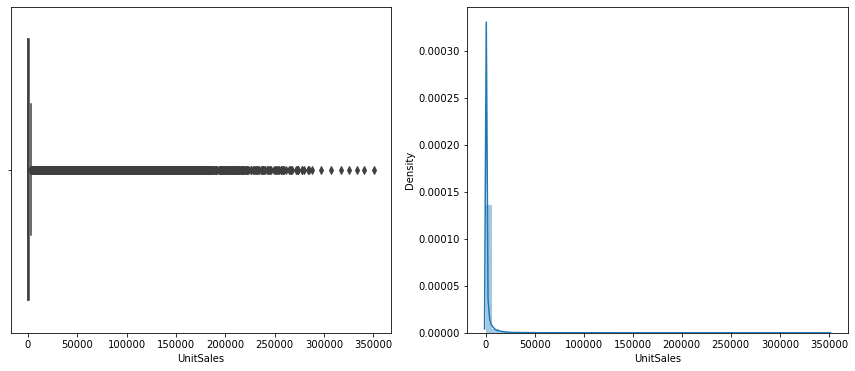

In [49]:
#plot boxplot & distribution plot of the target variable
plt.figure(figsize = (15,6))
plt.subplot(1,2,1)
sns.boxplot(item_avg_unitsale['UnitSales'])
plt.subplot(1,2,2)
sns.distplot(item_avg_unitsale['UnitSales'])

##### As seen by the box plot & distribution plot, the distribution of the target variable, overall daily unit sales is positively skewed with a lot of outliers. Let us deep-dive into the outliers to understand better.

In [50]:
#examine the outliers below the lower_bound
item_avg_unitsale[item_avg_unitsale['UnitSales'] < lower_bound]

Empty DataFrame
Columns: [Date, CategoryCode, GroupCode, ItemNumber, IsPromo, Is_Holiday, UnitSales, Week, Month, Year, Weekday]
Index: []

In [51]:
#examine the outliers below the upper_bound
item_avg_unitsale[item_avg_unitsale['UnitSales'] > upper_bound]

Date  CategoryCode  GroupCode  ItemNumber  IsPromo  Is_Holiday  \
67      2016-01-04          7289       5512        8714        0           0   
68      2016-01-04          7289       5512        8741        0           0   
70      2016-01-04          7289       5512        9076        0           0   
80      2016-01-04          7289       5512       10341        0           0   
82      2016-01-04          7289       5512       10476        0           0   
...            ...           ...        ...         ...      ...         ...   
1597502 2017-12-31          7292       5606       10702        0           0   
1597516 2017-12-31          7292       5610        9690        1           0   
1597520 2017-12-31          7292       5610       11430        0           0   
1597590 2017-12-31          7292       5616        8492        1           0   
1597591 2017-12-31          7292       5616       10812        0           0   

         UnitSales  Week  Month  Year  Weekday  
67          6908.0     1      1  2016        0  
68         23255.0     1      1  2016        0  
70          8637.0     1      1  2016        0  
80         14949.0     1      1  2016        0  
82         16161.0     1      1  2016        0  
...            ...   ...    ...   ...      ...  
1597502     2706.0    52     12  2017        6  
1597516    32163.0    52     12  2017        6  
1597520     2709.0    52     12  2017        6  
1597590    17384.0    52     12  2017        6  
1597591    12041.0    52     12  2017        6  

[160959 rows x 11 columns]

In [52]:
item_avg_unitsale[item_avg_unitsale['UnitSales'] > upper_bound]['ItemNumber'].nunique()

1084

##### There are quite a lot of outliers, 1084 Items out of 3420 with outliers in unit sales at some point of time

In [53]:
item_avg_unitsale[item_avg_unitsale['UnitSales'] > upper_bound].groupby(['Year','Month'])['ItemNumber'].nunique()

Year  Month
2016  1        413
      2        409
      3        481
      4        415
      5        470
      6        418
      7        426
      8        469
      9        482
      10       466
      11       418
      12       488
2017  1        468
      2        410
      3        435
      4        517
      5        469
      6        428
      7        441
      8        409
      9        490
      10       449
      11       448
      12       518
Name: ItemNumber, dtype: int64

### Visualize features & trends (Daily / Weekly / Monthly) of UnitSales 

### Daily Trends

#### High-level overview of daily sales performance of all product categories.

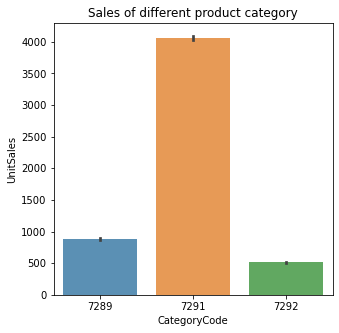

In [216]:
# plot bar chart to see daily unit sales performance of each product category
plt.figure(figsize=(5,5))
ax= sns.barplot(item_avg_unitsale.CategoryCode, item_avg_unitsale.UnitSales, alpha=0.8)
plt.title("Sales of different product category")
plt.show()

##### Here we see that the daily unit sales of a particular category '7291' is high, while the other 2 categories are quite low. There could be various influencing factors for this.

#### High-level overview of daily unit sales performance of all product groups.

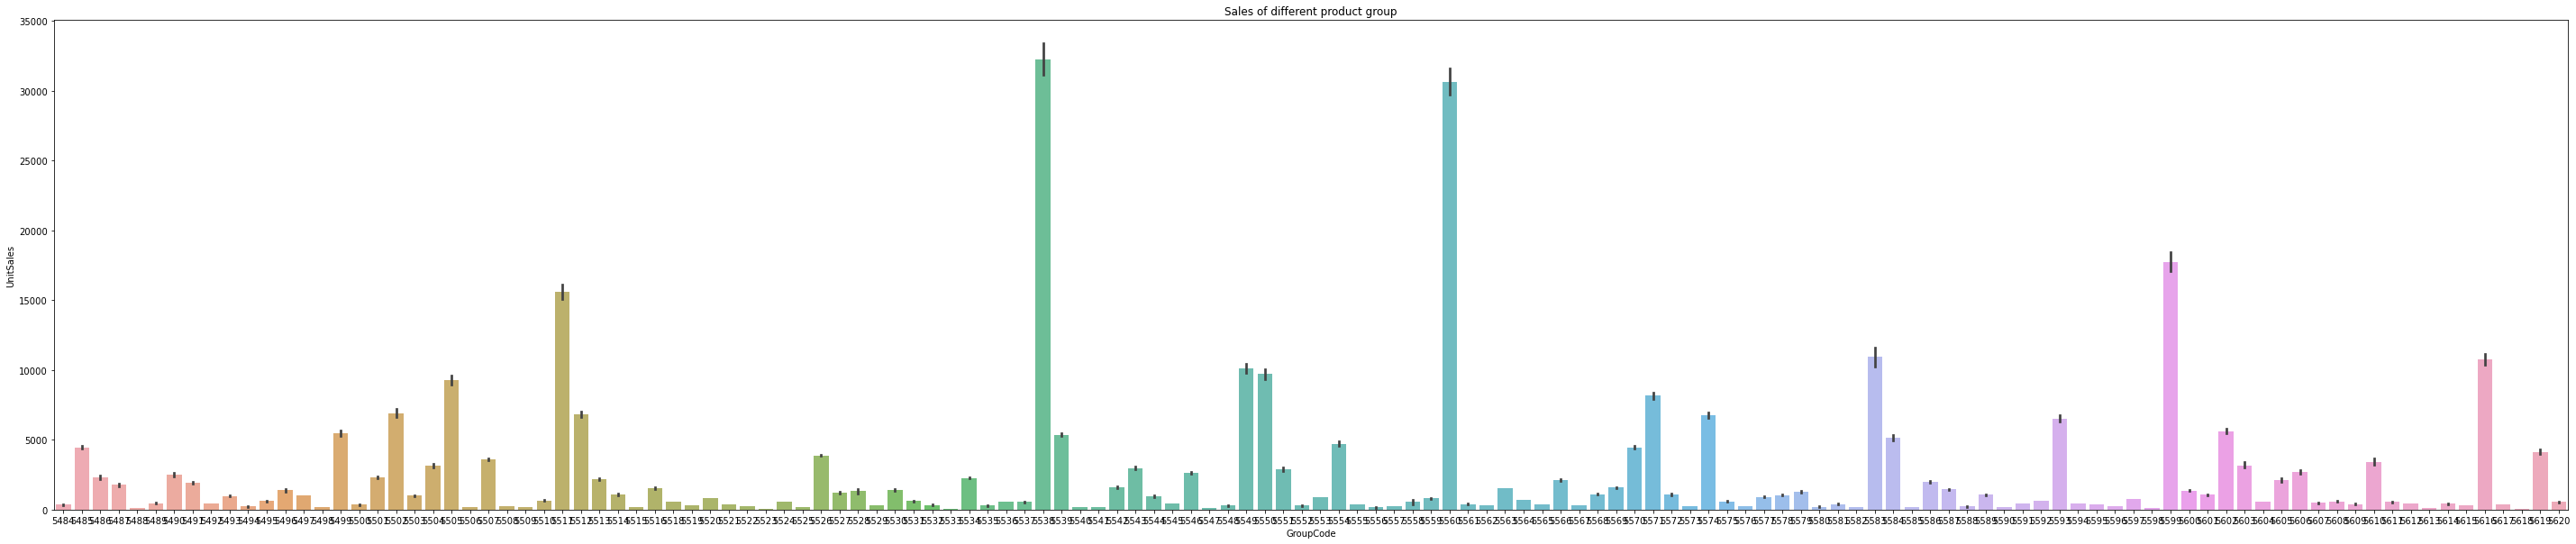

In [54]:
# plot bar chart to see daily unit sales of each product group
plt.figure(figsize=(50,10))
ax= sns.barplot(item_avg_unitsale.GroupCode, item_avg_unitsale.UnitSales, alpha=0.8)
plt.title("Sales of different product group")
plt.show()

<AxesSubplot:xlabel='GroupCode', ylabel='UnitSales'>

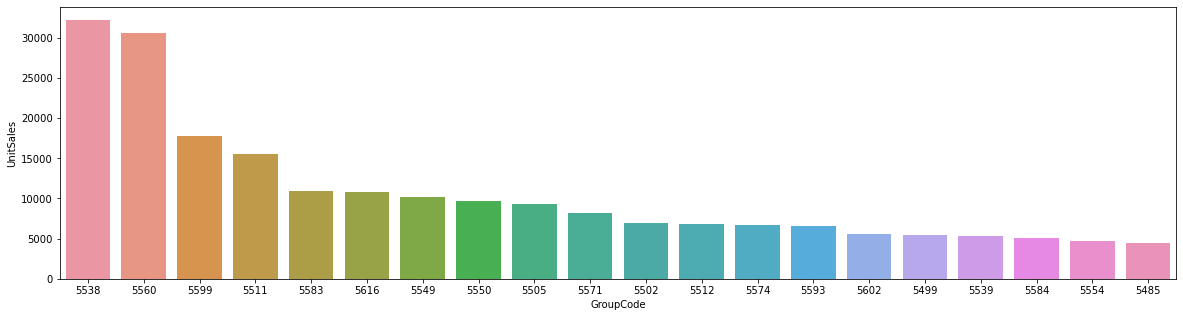

In [213]:
# Top 20 Group based on Average Daily Unit Sales
avg_grp_sales = item_avg_unitsale.groupby(["GroupCode"])['UnitSales'].aggregate(np.mean).reset_index().sort_values('UnitSales',ascending = False).reset_index()
del avg_grp_sales['index']
fig, ax = plt.subplots(figsize=(20,5))
sns.barplot(x='GroupCode', y="UnitSales", data=avg_grp_sales, order=avg_grp_sales['GroupCode'][0:20])

##### Here we see that the daily unit sales of groups '5538' & '5560' are the highest

#### High-level overview of daily sales performance of top 20 Items. (Plotting only top 20 as there more than 300 items)

<AxesSubplot:xlabel='ItemNumber', ylabel='UnitSales'>

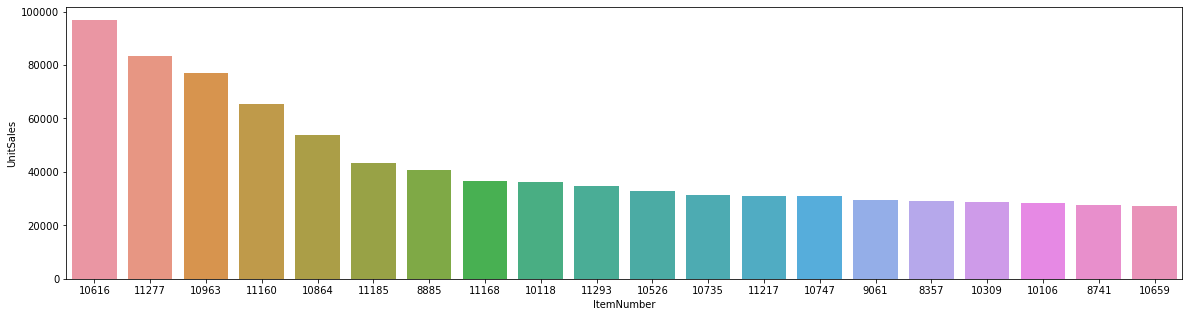

In [214]:
avg_itm_sales = item_avg_unitsale.groupby(["ItemNumber"])['UnitSales'].aggregate(np.mean).reset_index().sort_values('UnitSales',ascending = False).reset_index()
del avg_itm_sales['index']
fig, ax = plt.subplots(figsize=(20,5))
sns.barplot(x='ItemNumber', y="UnitSales", data=avg_itm_sales, order=avg_itm_sales['ItemNumber'][0:20])

##### Here we see that the daily unit sales of items '10616', '11277' & '10963' are top

### Weekly Trends

#### Weekly trends of unit sales for each year

<AxesSubplot:title={'center':'Overall Unit Sales for each Year by Weeks'}, xlabel='Week', ylabel='UnitSales'>

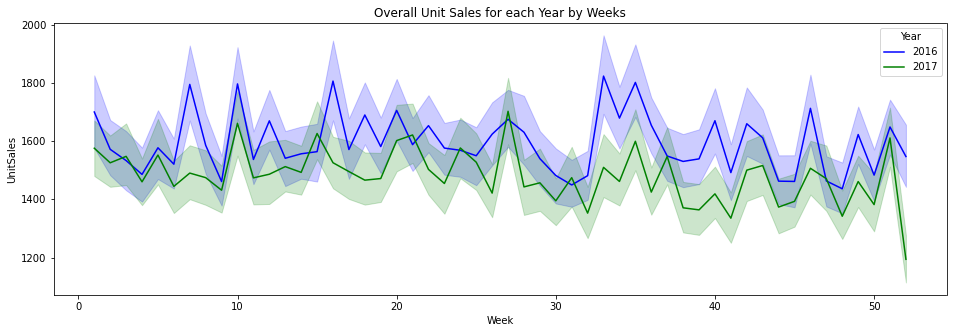

In [217]:
#plot line plot to visualize the trends of unit sales for each year by weeks
plt.figure(figsize=(16,5))
plt.title('Overall Unit Sales for each Year by Weeks')
plt.xlabel('Week')
plt.ylabel('UnitSales')
sns.lineplot(item_avg_unitsale.Week, item_avg_unitsale.UnitSales, hue = item_avg_unitsale.Year, palette=['b', 'g'])

##### Weekly Unit Sale is quite has some trend with a spike around 25-27 weeks and some drop around last weeks in both years

#### To see how the Category wise Unit Sales vary across week, year with and without Promo

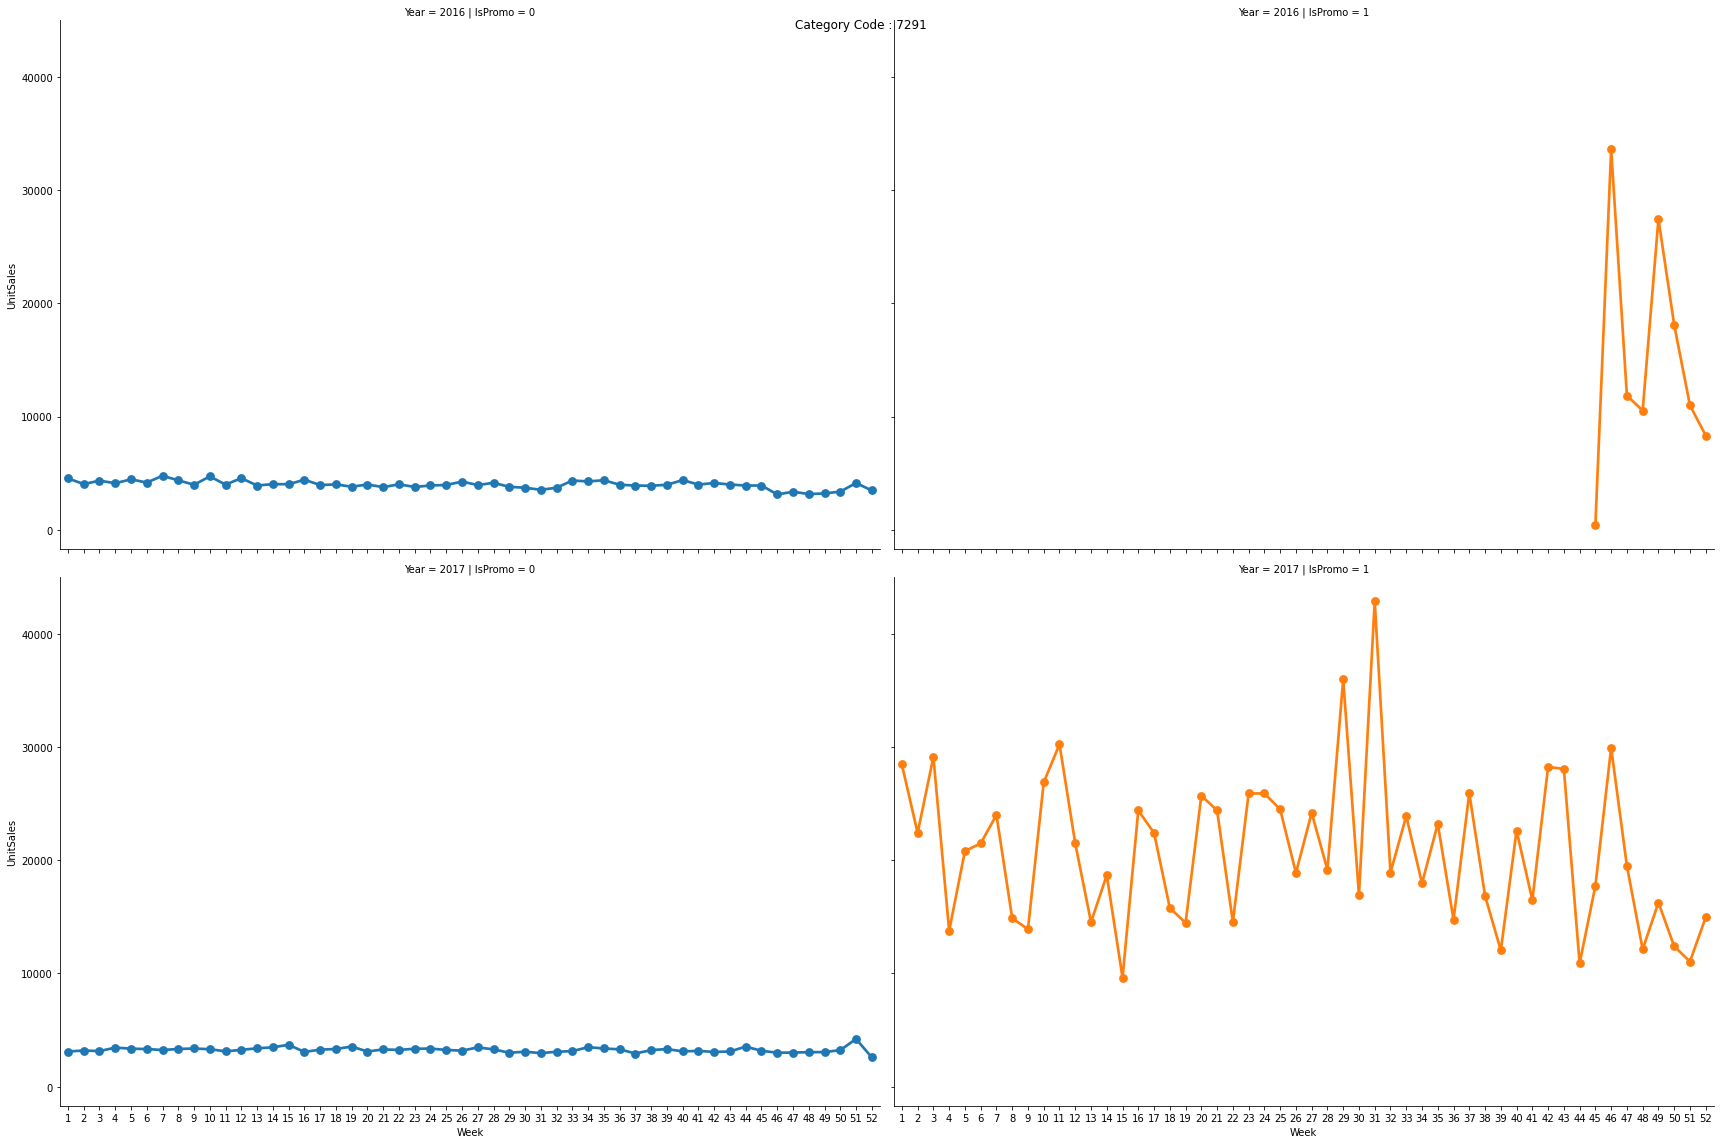

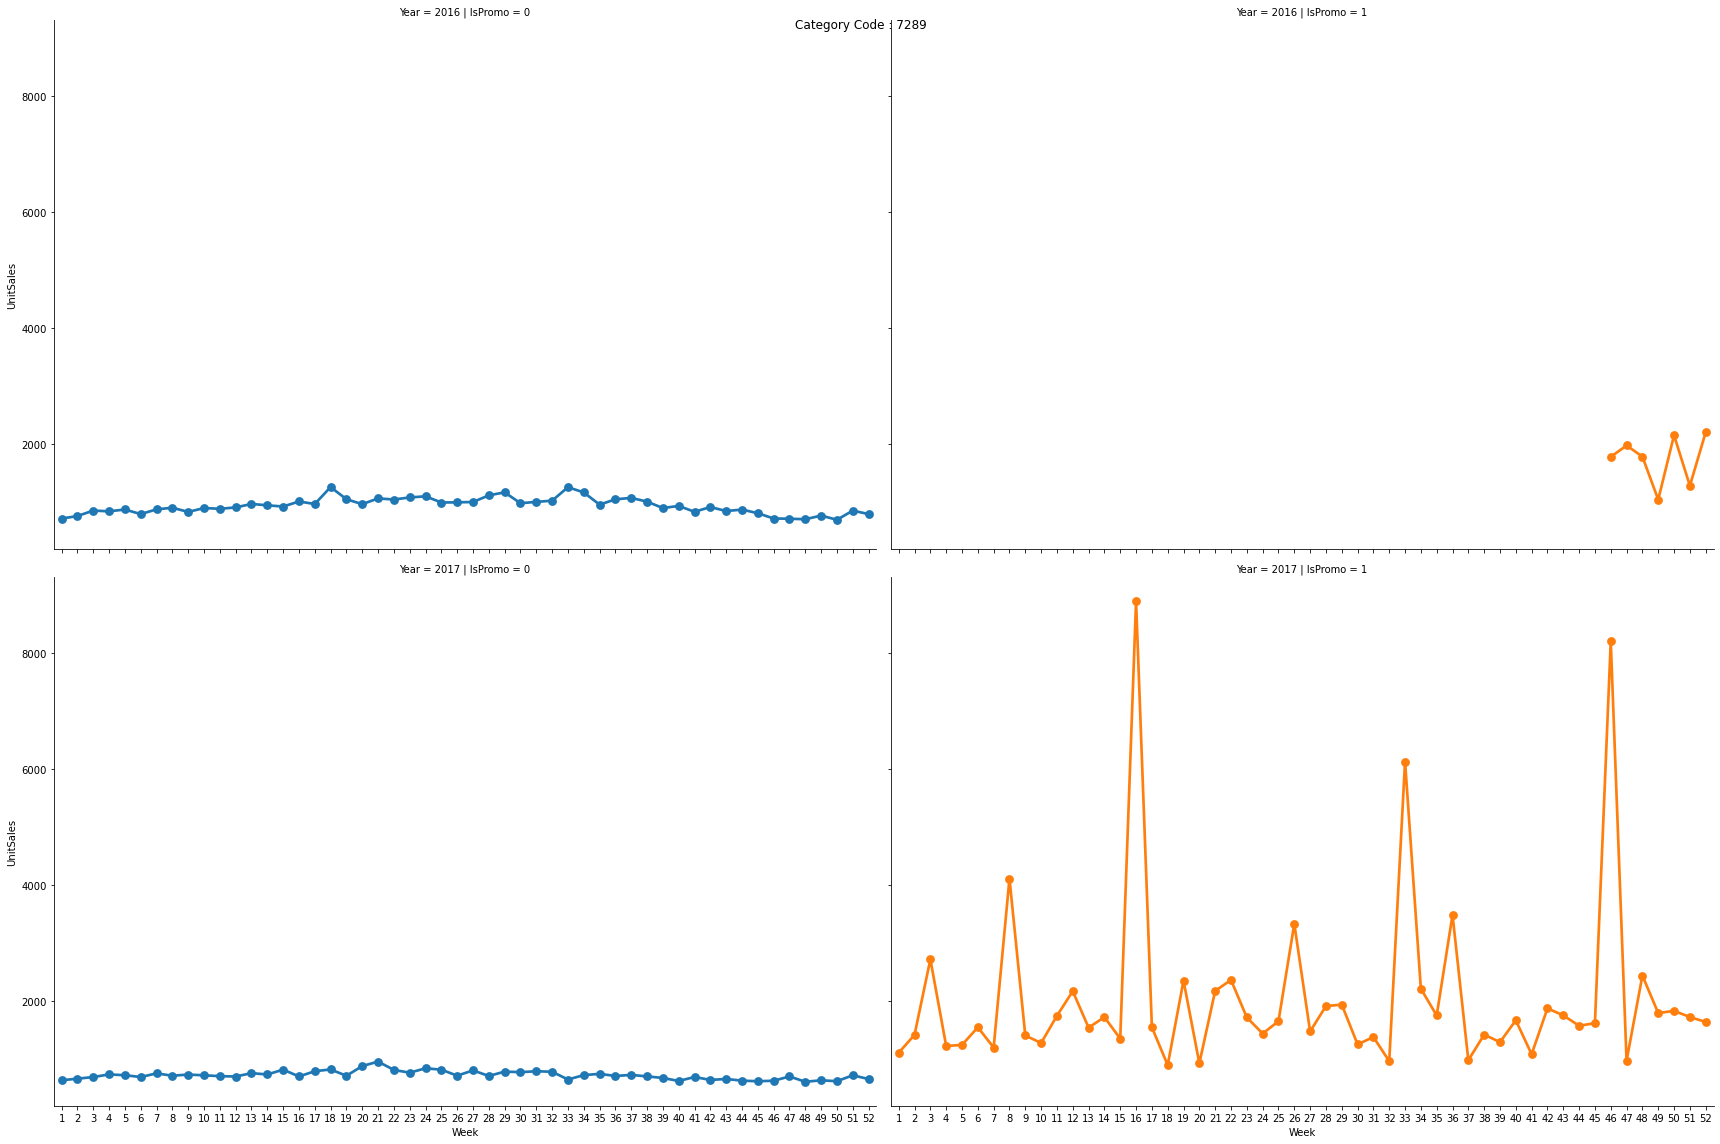

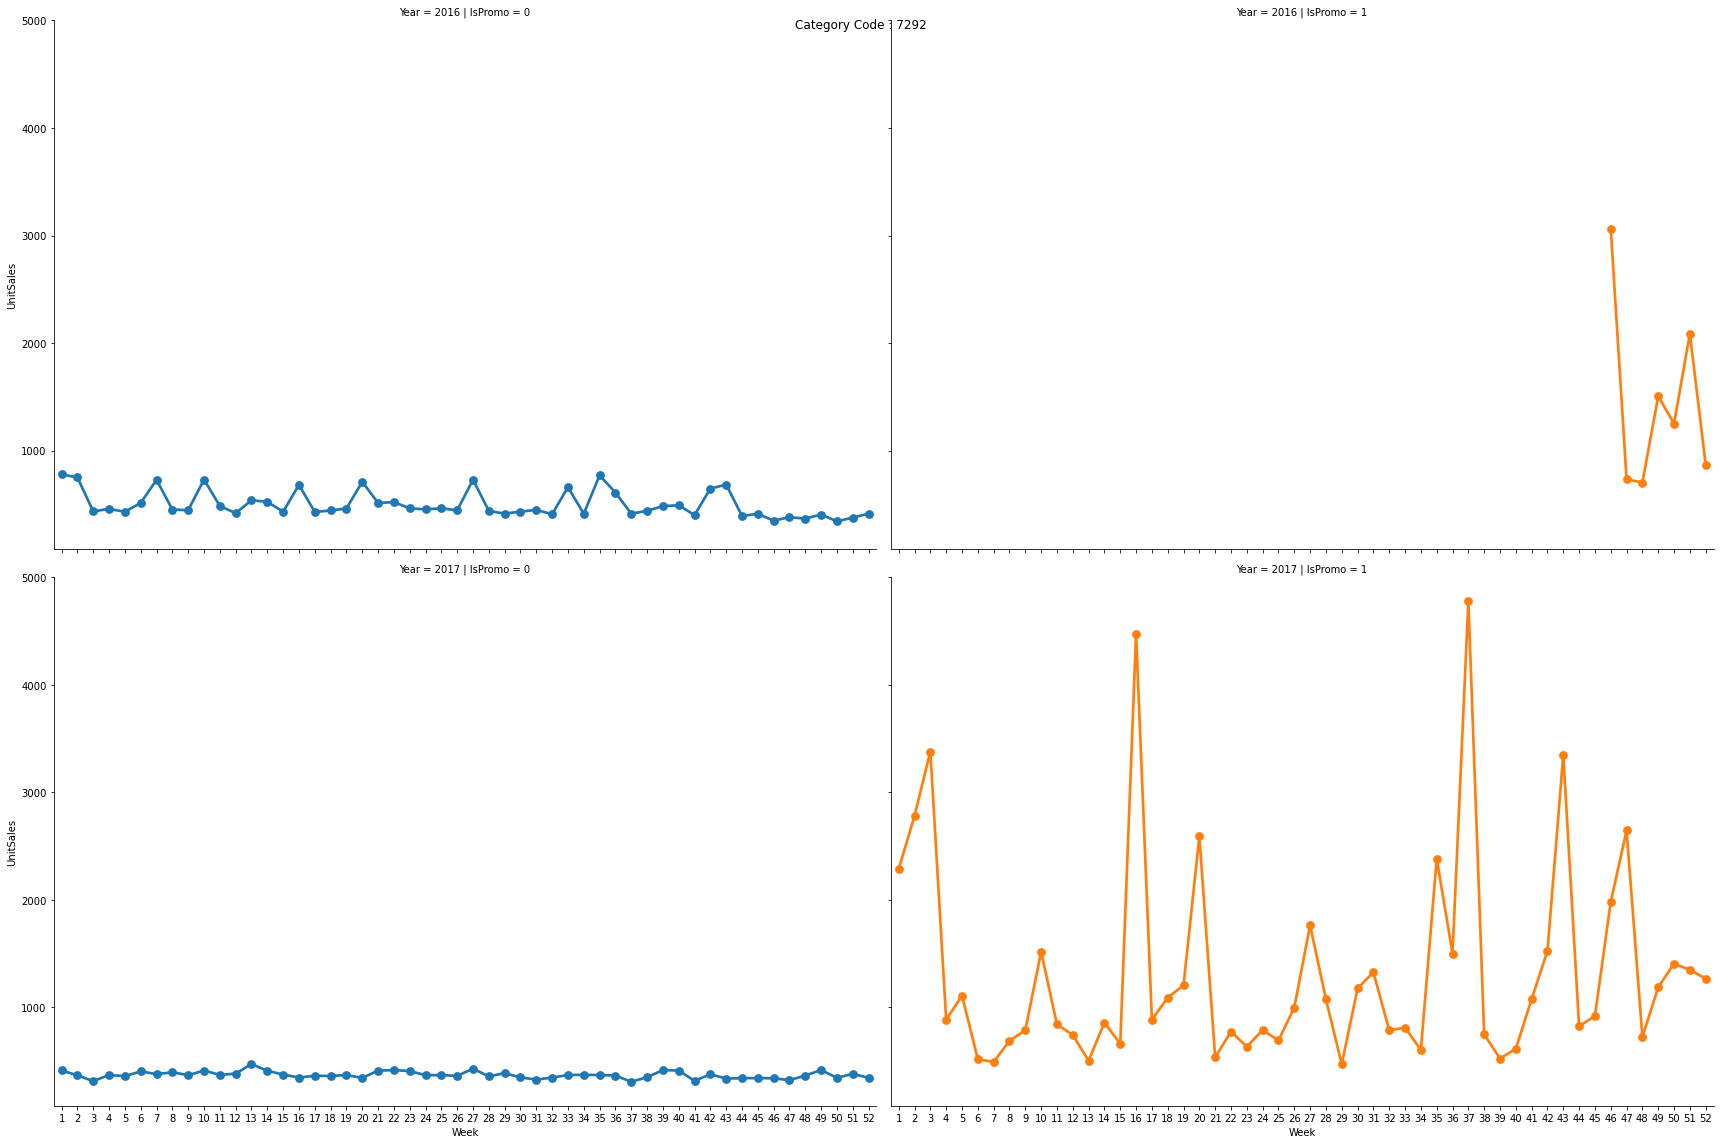

In [58]:
# Sales trend over the weeks and year across each category
wk_avg_cat_sales_promo = item_avg_unitsale.groupby(["CategoryCode","Year","Week","IsPromo"])['UnitSales'].aggregate(np.mean).reset_index().sort_values('UnitSales',ascending = False).reset_index()
del wk_avg_cat_sales_promo['index']
for code in wk_avg_cat_sales_promo['CategoryCode'].unique():
    rel = sns.factorplot(data = wk_avg_cat_sales_promo[wk_avg_cat_sales_promo['CategoryCode']==code], x ="Week", y = "UnitSales", col = 'IsPromo',hue = 'IsPromo',row = "Year", height=8, aspect=12/8)
    rel.fig.suptitle('Category Code : %i' %code)

##### Here, 
##### The overall weekly sales across all 3 categories (7289,7291,7292) has increased in both 2016 and 2017 with promotion
##### In 2016 The Promotion of all 3 categories of product was done only towards the year end 
##### In 2017 the promotion for all 3 categories has been done throughout the year
##### In2017 With Promotion,
* Category 7292 has seen significant spikes around week 14 -15 (April) and week 34 -39 (Aug-September)
* Category 7289 has seen significant spikes around week 15 - 20 (April-May), week 32 -38 (August-Sep),and week 45 -49 (November-Dec)
* Category 7291 has seen significant spikes around week 27 - 32 (July - August)

### Monthly Trends

#### Monthly trends of overall unit sales for each year

<AxesSubplot:title={'center':'Overall Unit Sales for each Year by Months'}, xlabel='Month', ylabel='UnitSales'>

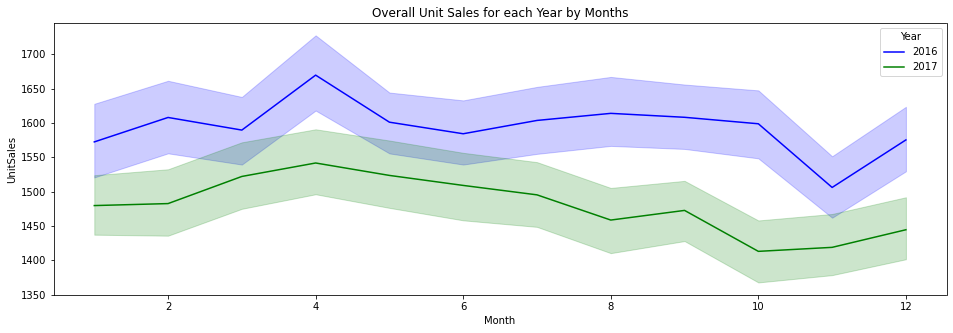

In [218]:
#plot line plot to visualize the trends of unit sales for each year by months
plt.figure(figsize=(16,5))
plt.title('Overall Unit Sales for each Year by Months')
plt.xlabel('Month')
plt.ylabel('UnitSales')
sns.lineplot(item_avg_unitsale.Month, item_avg_unitsale.UnitSales, hue = item_avg_unitsale.Year, palette=['b', 'g'])

##### The overall monthly sales in both 2016 and 2017 has seen an increase in unit sales around Summer months (April – Aug), (Sep –Oct) and slight decrease towards November and again increase in December.

#### To see how the Category wise Unit Sales vary across month, year with and without Promo

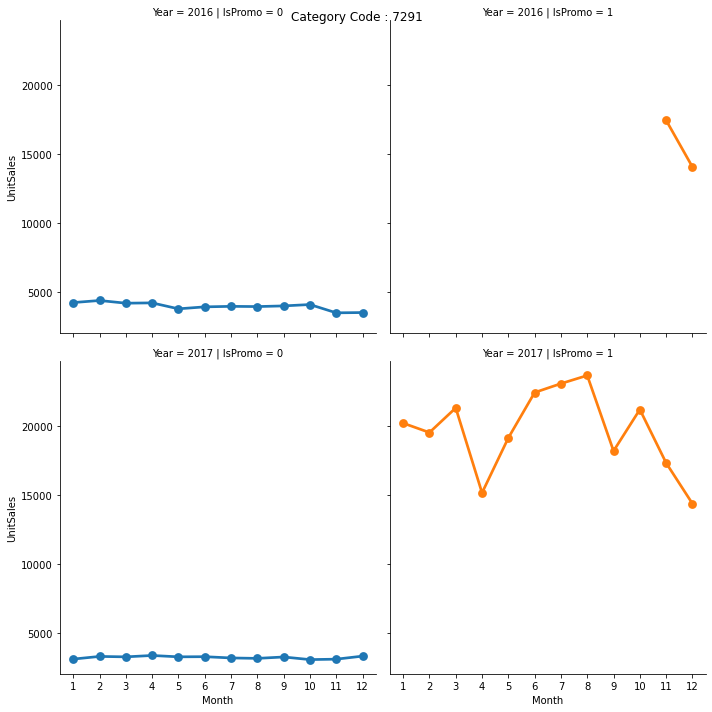

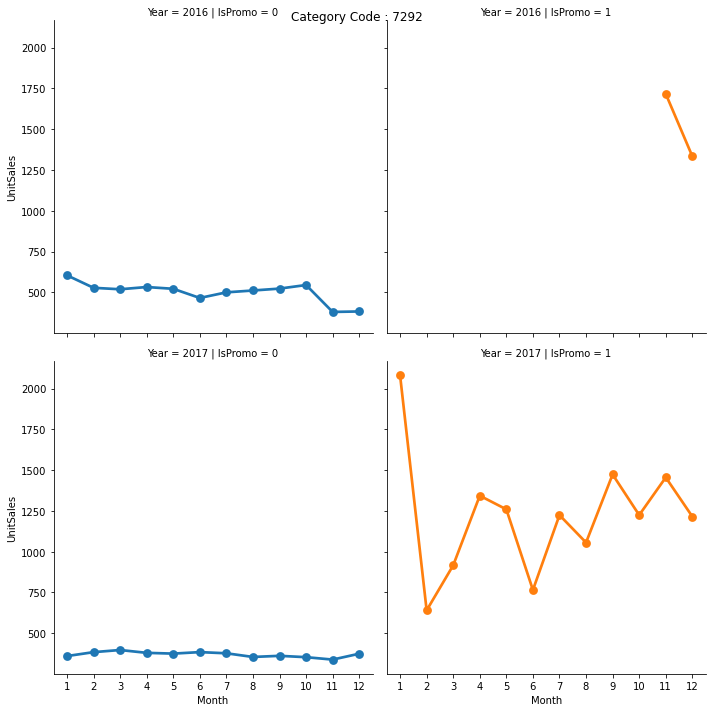

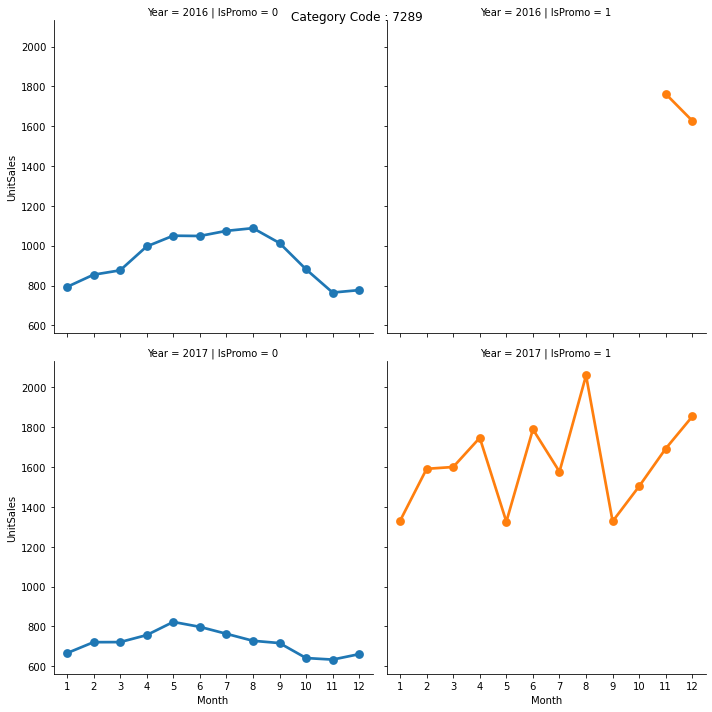

In [60]:
# Sales trend over the months and year across each category
month_avg_cat_sales_promo = item_avg_unitsale.groupby(["CategoryCode","Year","Month","IsPromo"])['UnitSales'].aggregate(np.mean).reset_index().sort_values('UnitSales',ascending = False).reset_index()
del month_avg_cat_sales_promo['index']
for code in month_avg_cat_sales_promo['CategoryCode'].unique():
    rel = sns.factorplot(data = month_avg_cat_sales_promo[month_avg_cat_sales_promo['CategoryCode']==code], x ="Month", y = "UnitSales", col = 'IsPromo',hue = 'IsPromo',row = "Year")
    rel.fig.suptitle('Category Code : %i' %code)

* Without Promo the Unit sales across all 3 categories through both the years seems quite stationary
* With Promo the the Unit sales across all 3 categories through both the years has signifinactly increased but there quite some seasonality

### Let us picture how the sales vary during holidays.

### Overall Category Wise Weekly - Yearly Unit Sale during Holidays

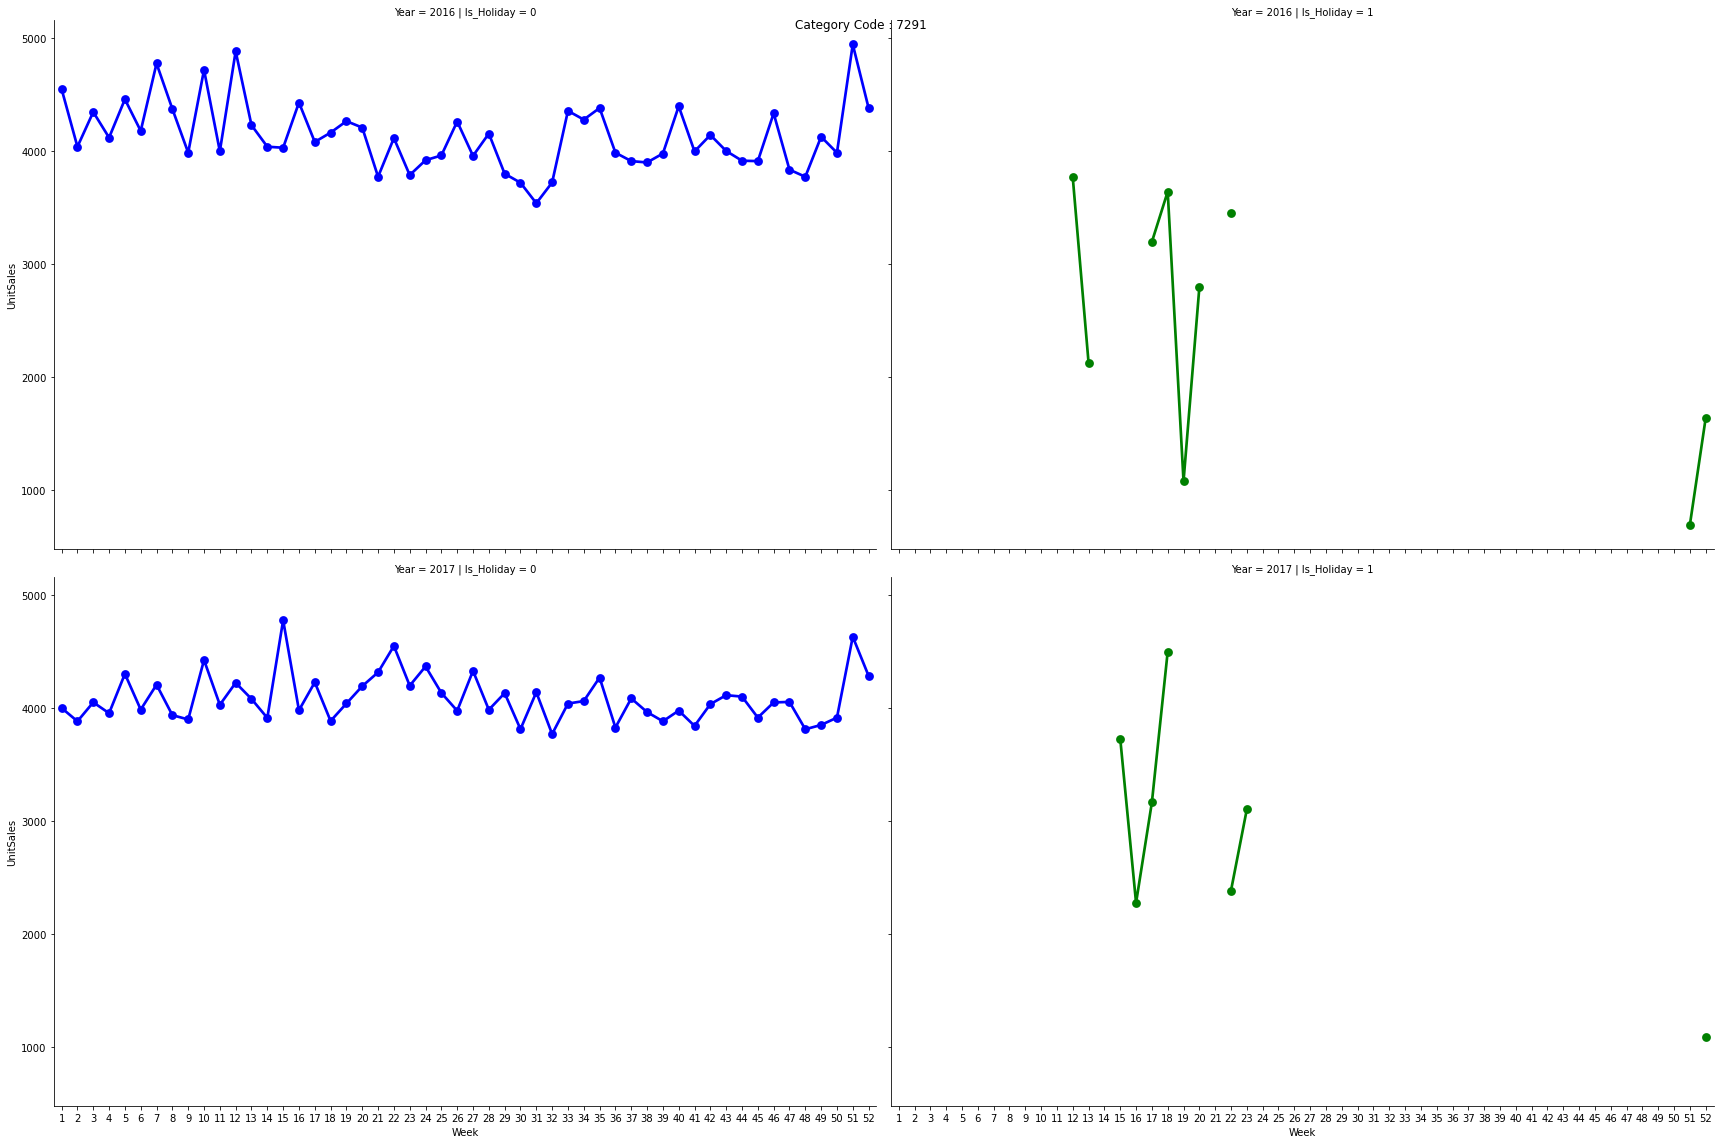

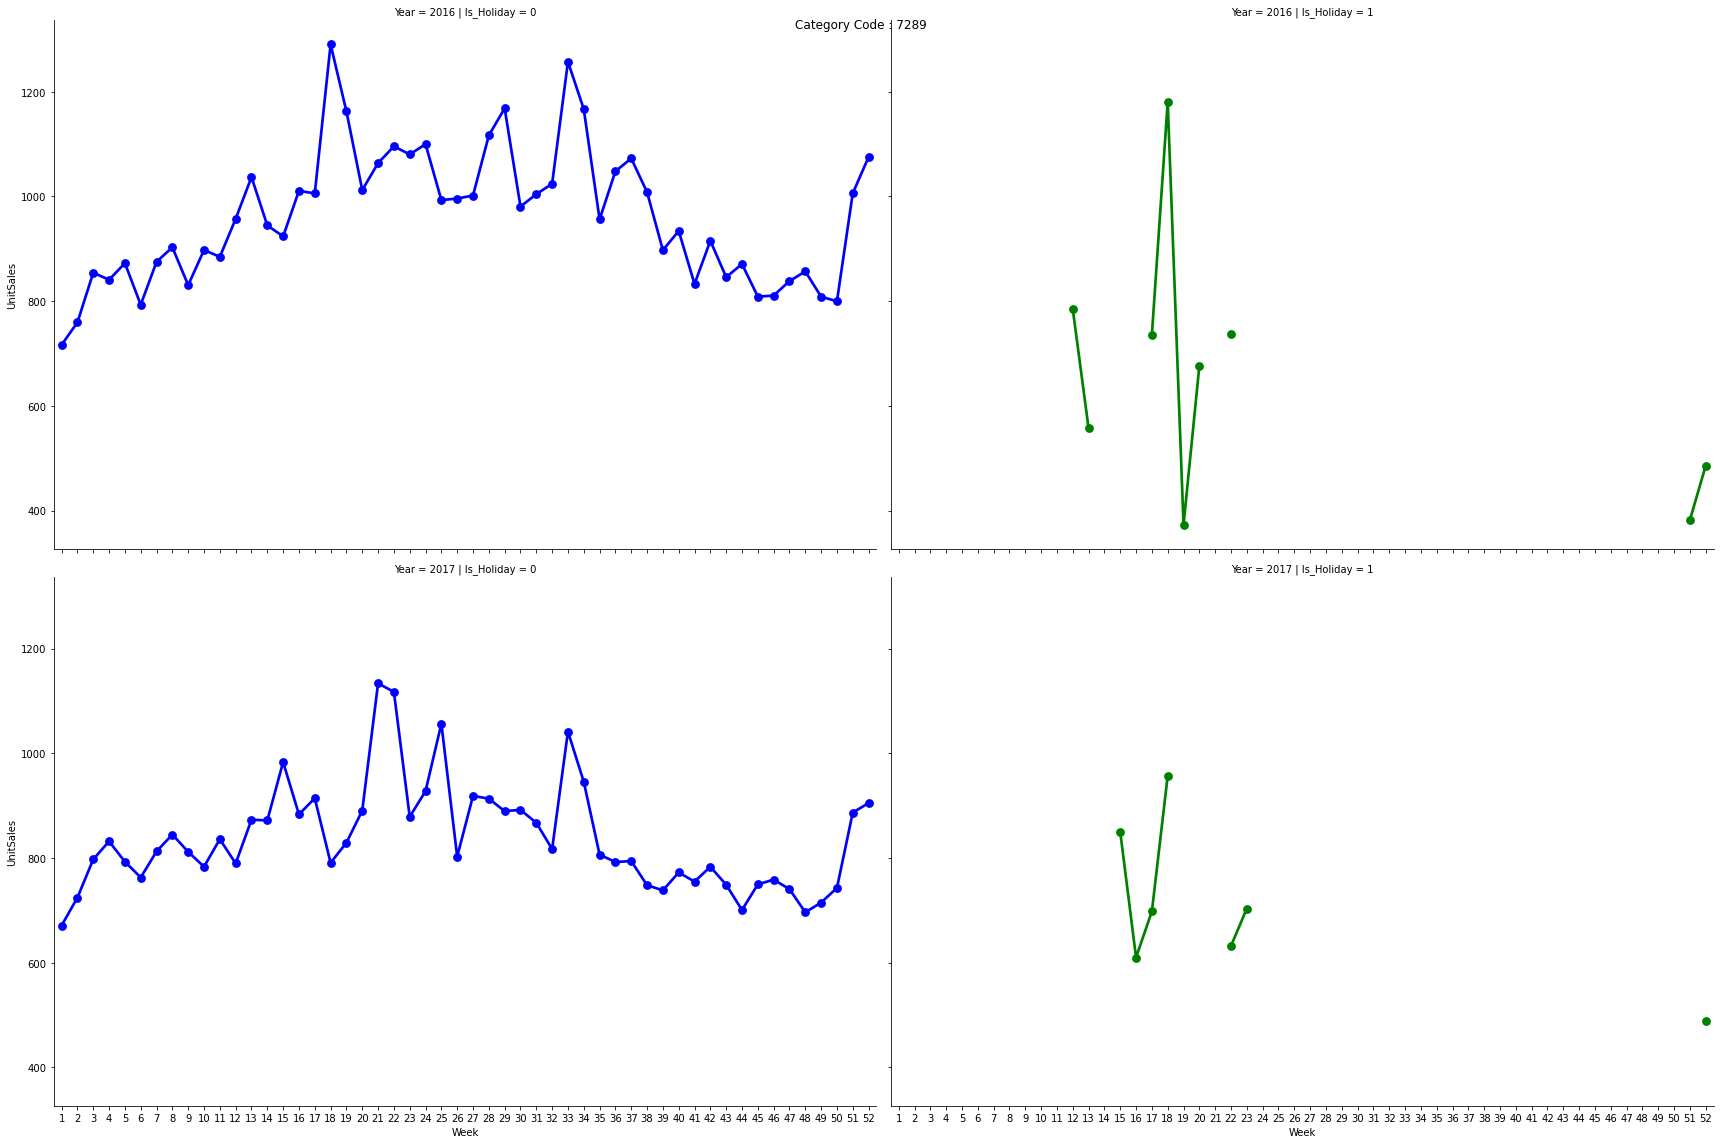

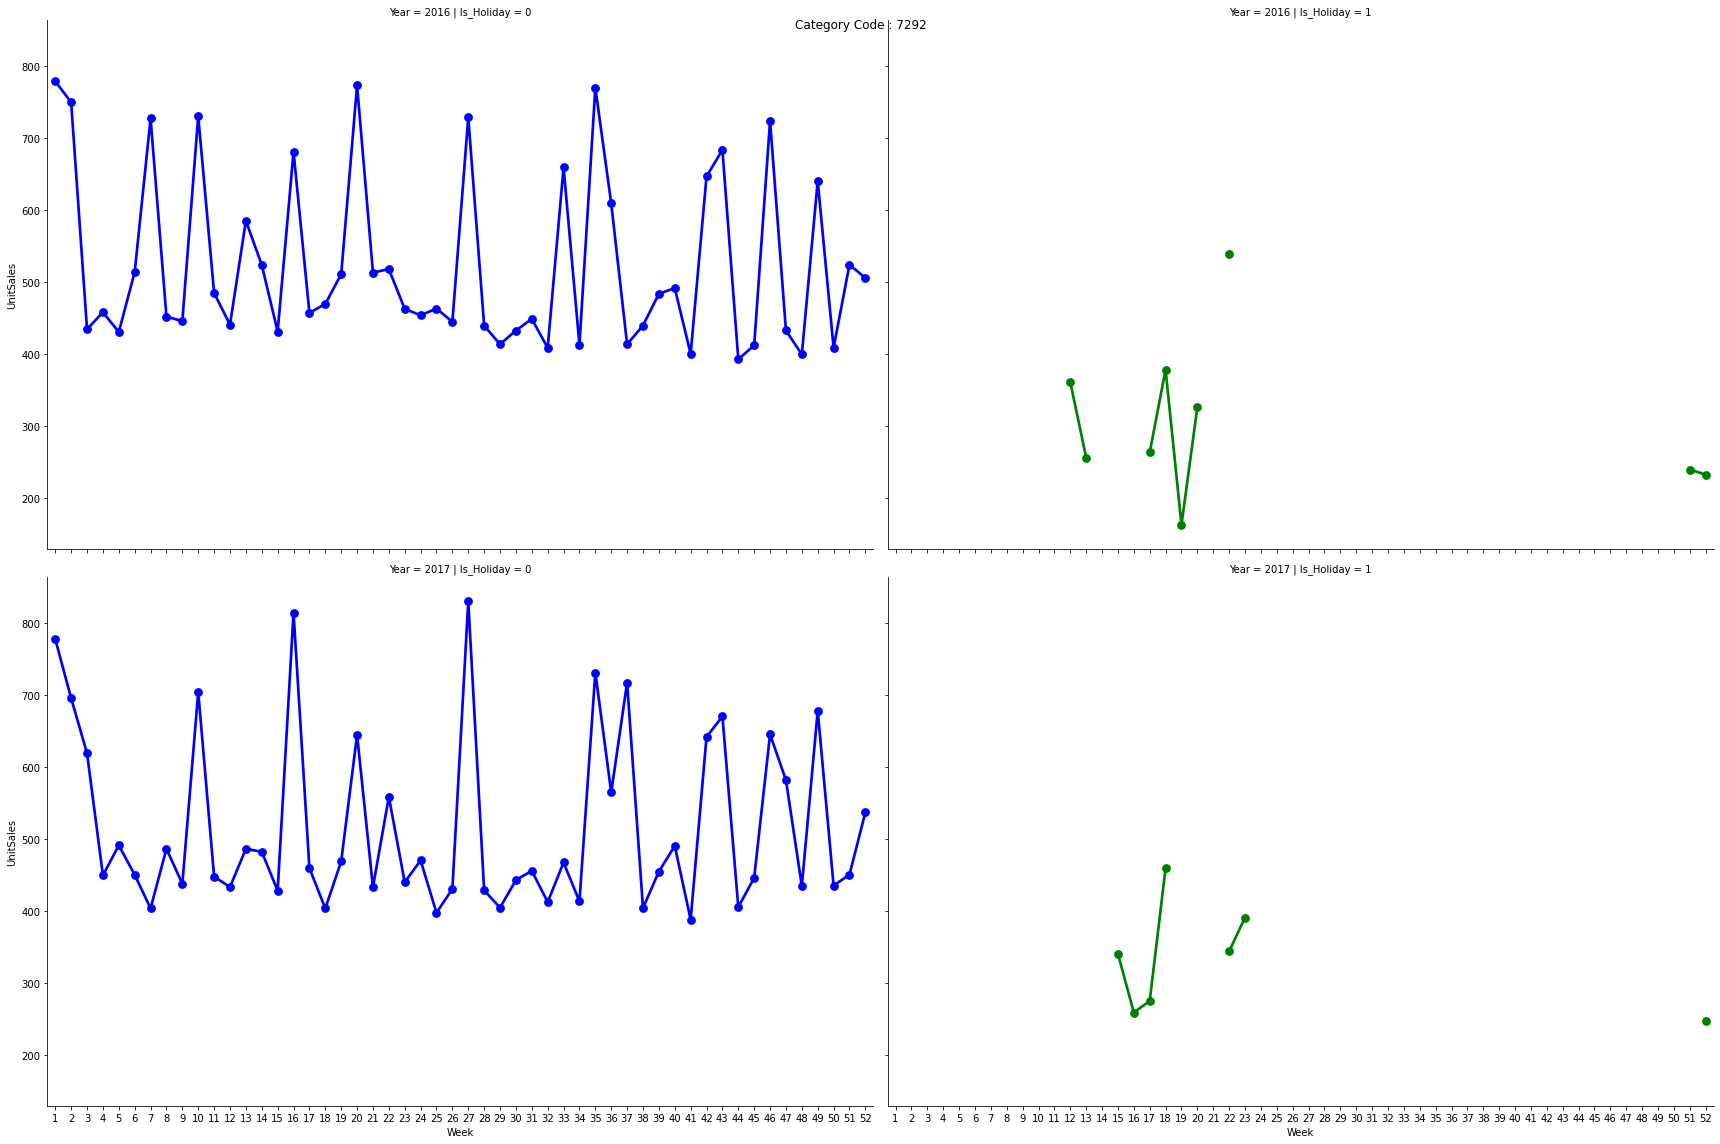

In [205]:
wk_avg_cat_sales_holiday = item_avg_unitsale.groupby(["CategoryCode","Year","Week","Is_Holiday"])['UnitSales'].aggregate(np.mean).reset_index().sort_values('UnitSales',ascending = False).reset_index()
del wk_avg_cat_sales_holiday['index']
for code in wk_avg_cat_sales_holiday['CategoryCode'].unique():
    rel = sns.factorplot(data = wk_avg_cat_sales_holiday[wk_avg_cat_sales_holiday['CategoryCode']==code], x ="Week", y = "UnitSales", col = 'Is_Holiday',hue = 'Is_Holiday',row = "Year", palette=['b', 'g'],height=8, aspect=12/8)
    rel.fig.suptitle('Category Code : %i' %code)

#### The Weekly Sales during Holiday Weeks is not very similar to sales during non holidays, the sales during holidays has gradations and tends to slightly go down as people might be travelling on vacation or could be eating at restaurants.

##### 7291
 * 2016 - Slight decrease during holidays
 * 2017 - Sales was more or less similar to non holiday days with slight gradations

##### 7289
 * 2016 - Sales was more or less similar to non holiday days with slight gradations
 * 2017 - Sales was more or less similar to non holiday days with slight gradations

##### 7292
 * 2016 - Sales decreased during Holidays
 * 2017 - Sales decreased during Holidays
 
#### In Both the Years across all weeks irrespective of holiday or not the Sales of category 7291 was always been high amongst the 3 categories

#### Category wise UnitSales during Holidays

<AxesSubplot:title={'center':'Unitsales of Categories during Holidays by Years'}, xlabel='CategoryCode', ylabel='UnitSales'>

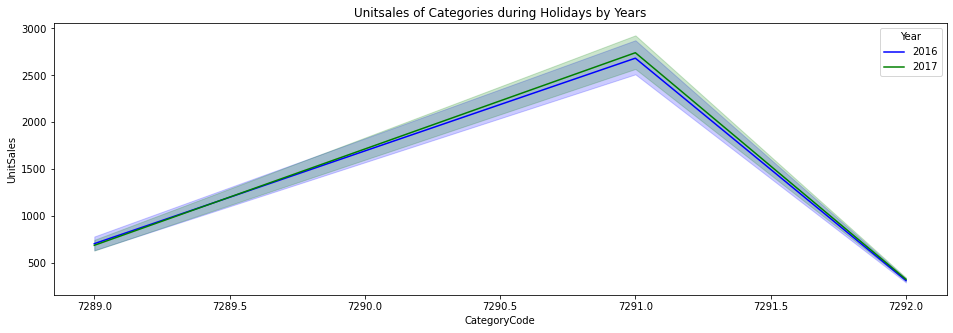

In [223]:
plt.figure(figsize=(16,5))
plt.title('Unitsales of Categories during Holidays by Years')
plt.xlabel('CategoryCode')
plt.ylabel('UnitSales')
holiday = item_avg_unitsale['Is_Holiday'] == 1
mnth=item_avg_unitsale[holiday]
sns.lineplot(mnth.CategoryCode, mnth.UnitSales, hue = mnth.Year, palette=['b', 'g'])

##### The Unit sale of product category 7291 has a good spike in both 2016 and 2017

### Lets see for some specific holidays for example

#### Sales during Christmas Week

<AxesSubplot:title={'center':'Unitsales of Categories during Christmas Week by Years'}, xlabel='CategoryCode', ylabel='UnitSales'>

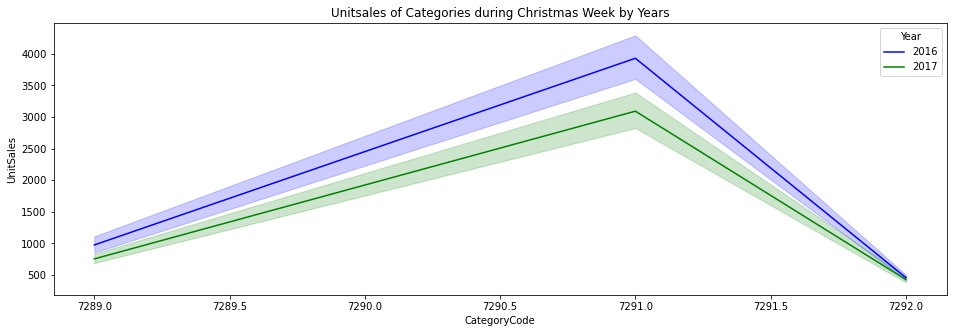

In [220]:
#plot bar chart to visualize sales year-wise for the Chriatmas week
plt.figure(figsize=(16,5))
plt.title('Unitsales of Categories during Christmas Week by Years')
plt.xlabel('CategoryCode')
plt.ylabel('UnitSales')
mnth_12 = item_avg_unitsale['Week'] == 52
december=item_avg_unitsale[mnth_12]
sns.lineplot(december.CategoryCode, december.UnitSales, hue = december.Year, palette=['b', 'g'])

##### The sale of product category 7291 has a good spike during Christmas Week 52 in both years with a slight drop in 2017 compared to 2016

#### Sales during Kings day Week

<AxesSubplot:title={'center':'Unitsales of Categories around Kings day by Years'}, xlabel='CategoryCode', ylabel='UnitSales'>

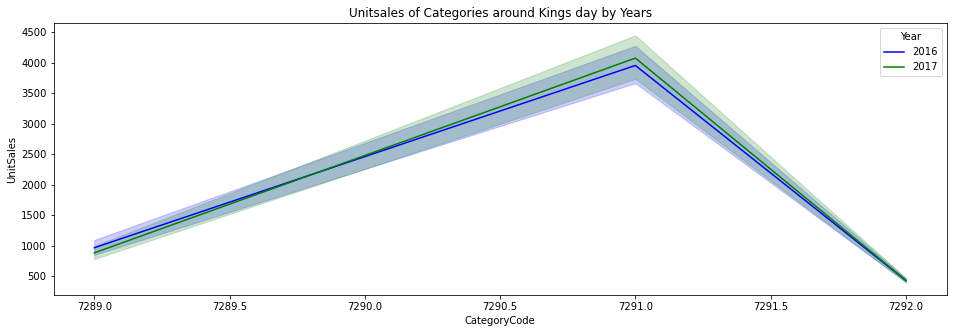

In [221]:
#plot bar chart to visualize sales year-wise for the Kings day Week
plt.figure(figsize=(16,5))
plt.title('Unitsales of Categories around Kings day by Years')
plt.xlabel('CategoryCode')
plt.ylabel('UnitSales')
mnth_4 = item_avg_unitsale['Week'] == 17
april=item_avg_unitsale[mnth_4]
sns.lineplot(april.CategoryCode, april.UnitSales, hue = april.Year, palette=['b', 'g'])

##### The sale of product category 7291 has a good spike around  Kings Day week in both 2016 and 2017

### The performance of Product Groups with respect to different Product Categories sorted by date.

(11433, 11)


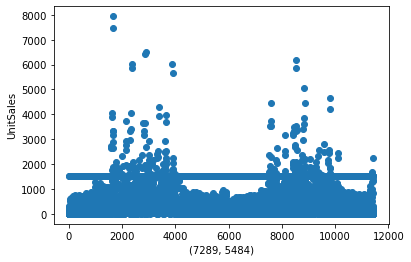

(11966, 11)


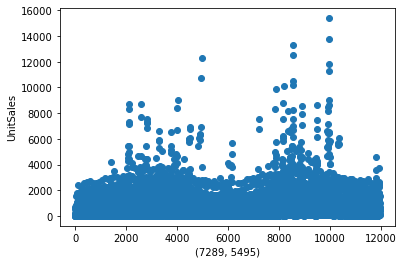

(635, 11)


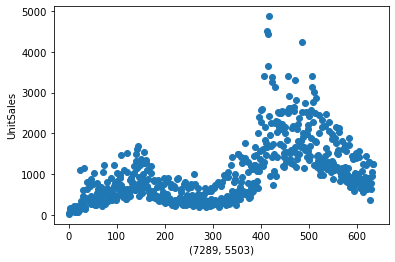

(6543, 11)


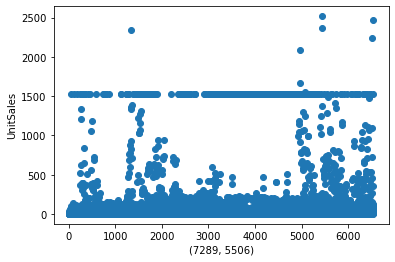

(17503, 11)


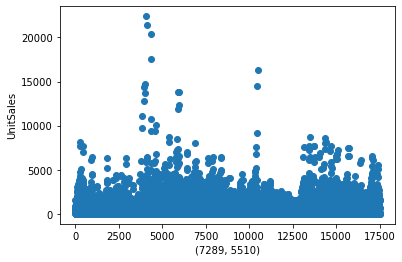

(20441, 11)


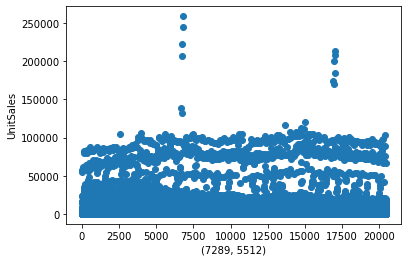

(10362, 11)


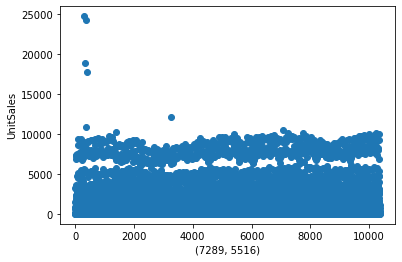

(33654, 11)


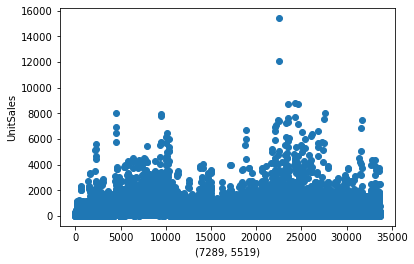

(7784, 11)


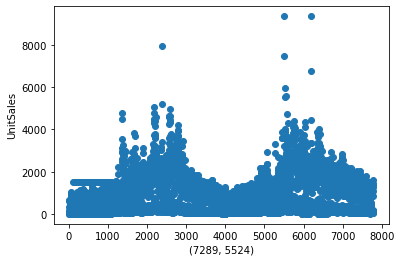

(64419, 11)


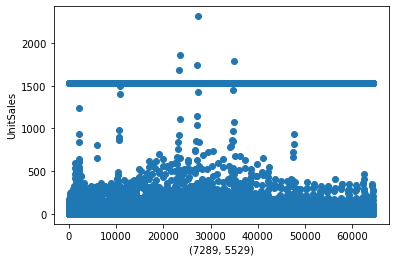

(7101, 11)


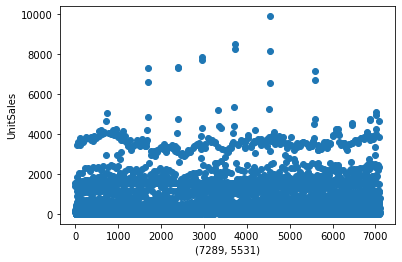

(15781, 11)


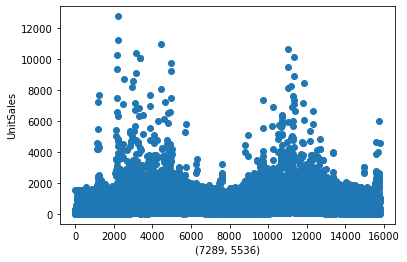

In [64]:
count = 0
for category, group in item_avg_unitsale.groupby(["CategoryCode", "GroupCode"]):
    plt.ylabel('UnitSales')
    plt.xlabel(category)
    print(group.shape)
    group = group.sort_values(by=['Date'])
    plt.scatter(range(len(group)), group["UnitSales"])
    plt.show()
    if count > 10:
        break
    count += 1

##### Group-vs-UnitSales plot shows noticable relations, but no obvious linearality has been observed in any plot.

##### In the plots of the daily unitsales of each product category and group, we see different trends in each plot, indicating that the features may affect the weekly unitsales of each product group in each category differently.

# Stationarity of Time Series

#### In order to use time series forecasting models, we need to ensure that our time series data is stationary i.e constant mean, constant variance and constant covariance with time.

In [154]:
sales_df_selected = item_avg_unitsale.copy()
sales_df_selected.set_index('Date', inplace=True)
sales_df_selected.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1597612 entries, 2016-01-04 to 2017-12-31
Data columns (total 10 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   CategoryCode  1597612 non-null  int64  
 1   GroupCode     1597612 non-null  int64  
 2   ItemNumber    1597612 non-null  int64  
 3   IsPromo       1597612 non-null  int64  
 4   Is_Holiday    1597612 non-null  int64  
 5   UnitSales     1597612 non-null  float64
 6   Week          1597612 non-null  int64  
 7   Month         1597612 non-null  int64  
 8   Year          1597612 non-null  int64  
 9   Weekday       1597612 non-null  int64  
dtypes: float64(1), int64(9)
memory usage: 134.1 MB


In [158]:
sales_df_selected.tail(5)

CategoryCode  GroupCode  ItemNumber  IsPromo  Is_Holiday  \
Date                                                                   
2017-12-31          7292       5620        8448        0           0   
2017-12-31          7292       5620        8974        0           0   
2017-12-31          7292       5620        8990        0           0   
2017-12-31          7292       5620       10715        0           0   
2017-12-31          7292       5620       11335        0           0   

            UnitSales  Week  Month  Year  Weekday  
Date                                               
2017-12-31       90.0    52     12  2017        6  
2017-12-31      661.0    52     12  2017        6  
2017-12-31      807.0    52     12  2017        6  
2017-12-31      109.0    52     12  2017        6  
2017-12-31       65.0    52     12  2017        6

#### Trend for Each Product Category

<AxesSubplot:xlabel='Date'>

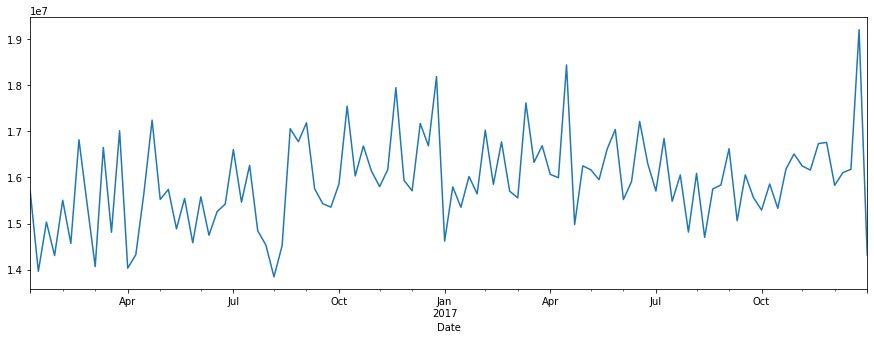

In [79]:
# Category 7291
sales_7291 = sales_df_selected[sales_df_selected.CategoryCode == 7291]['UnitSales']
# Trend
sales_7291.resample('W').sum().plot(figsize=(15,5))

#### Category 7291  sales is quite stationary with slight increases  around April and Sep-Dec in both the years
#### Probably the product category is a regular commodity like Food products

<AxesSubplot:xlabel='Date'>

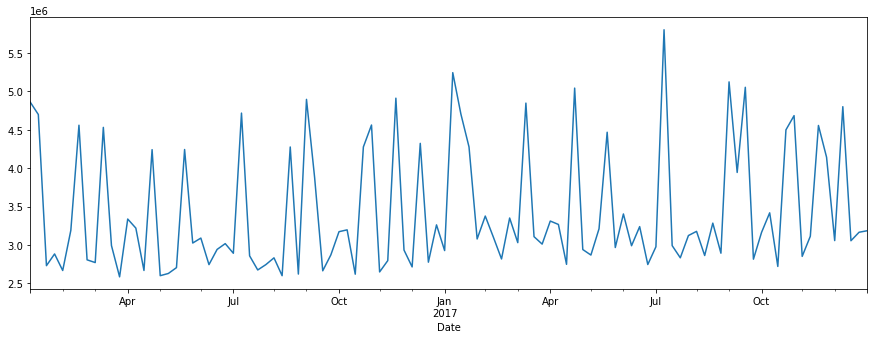

In [80]:
# Category 7292
sales_7292 = sales_df_selected[sales_df_selected.CategoryCode == 7292]['UnitSales']
# Trend
sales_7292.resample('W').sum().plot(figsize=(15,5))

#### Category 7292 has significant gradations in sales throughout the year with some spike around July - Aug
#### Probably the product category is a regular commodity like Kitchen & Household products

<AxesSubplot:xlabel='Date'>

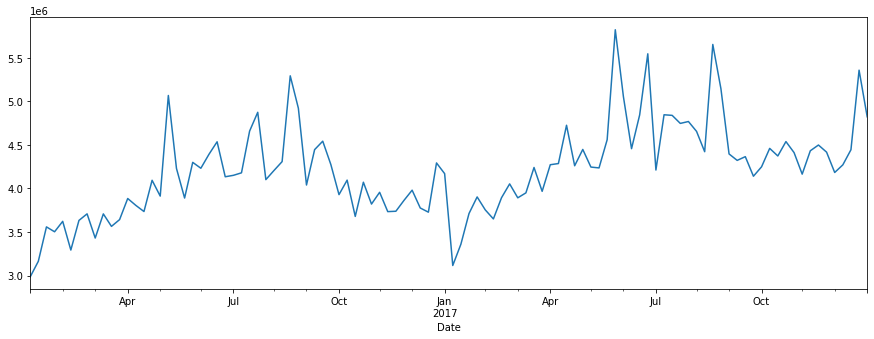

In [81]:
# Category 7289
sales_7289 = sales_df_selected[sales_df_selected.CategoryCode == 7289]['UnitSales']
# Trend
sales_7289.resample('W').sum().plot(figsize=(15,5))

#### Category 7289 has significant sales around May - Sep, Probably it is some product category specifc to Summer

# TimeSeries Forecasting Trial for 1 Item
* Running Time Series Models at Item Level is very time consuming as we have more than 3000 Items. Finding Stationarity of data at an item level and making it stationary if it isn't using loops is a computationally costly and inefficient process

* Therefore for First Trial, I will be Taking 1 Item that was promoted and not promoted and make the forecast

* As an alternate efficient option Heirachical Time Series Forecasting will be done as we progress below

In [159]:
sales_df_selected_1 = sales_df_selected[sales_df_selected.ItemNumber == 8842]
sales_df_selected_1['IsPromo'].value_counts()

0    686
1     42
Name: IsPromo, dtype: int64

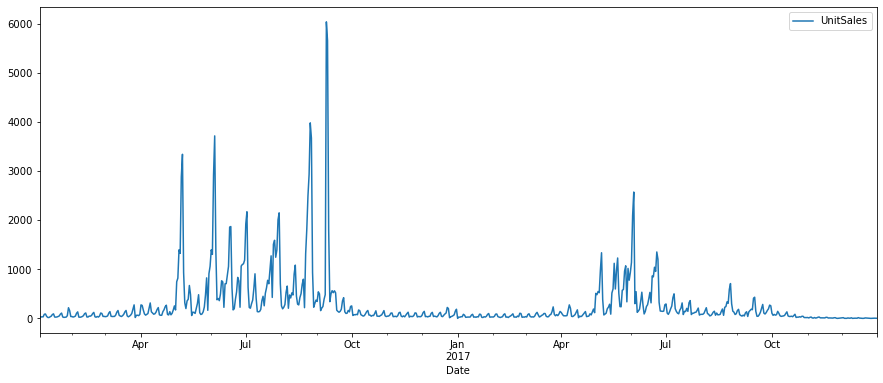

In [160]:
df_8842 = sales_df_selected[sales_df_selected['ItemNumber']==8842]['UnitSales'].reset_index()
df_8842.set_index('Date', inplace = True)
df_8842.plot(figsize=(15, 6))
plt.show()

In [161]:
df_8842.tail()

UnitSales
Date                 
2017-12-27        3.0
2017-12-28        4.0
2017-12-29        5.0
2017-12-30        5.0
2017-12-31        3.0

### Checking Stationarity

In [168]:
# Function to test the stationarity
def test_stationarity(timeseries):
    
    # Determing rolling statistics
    roll_mean = timeseries.rolling(window=7).mean()
    roll_std = timeseries.rolling(window=7).std()
# Plotting rolling statistics:
    plt.figure(figsize=(16,8))
    orig = plt.plot(timeseries.resample('W').mean(), color='blue',label='Original')
    mean = plt.plot(roll_mean.resample('W').mean(), color='red', label='Rolling Mean')
    std = plt.plot(roll_std.resample('W').mean(), color='green', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.show(block=False)
    # Performing Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
           print(key, value)

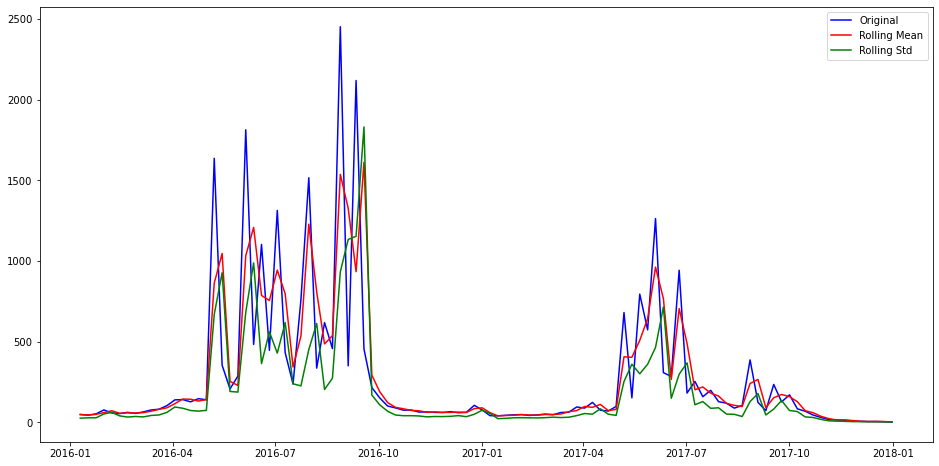

Results of Dickey-Fuller Test:
ADF Statistic: -3.455217
p-value: 0.009215
Critical Values:
1% -3.439580754053961
5% -2.865613606467485
10% -2.568939269723711


In [169]:
test_stationarity(df_8842)

##### Here, p-value lesser than 0.05, We can reject the null hypothesis (H0), the data has a unit root and is stationary.
##### Not much difference between mean and std
##### No need further Transformation to make it stationary

### To Make Data Stationary
* Showing some methods to make data stationary by Elimnating Trend and Seasonality if needed for other items

#### Differencing
##### In this technique, we take the 1st order difference of the observation at a particular instant with that at the previous instant. This mostly works well in improving stationarity. First order differencing is taken

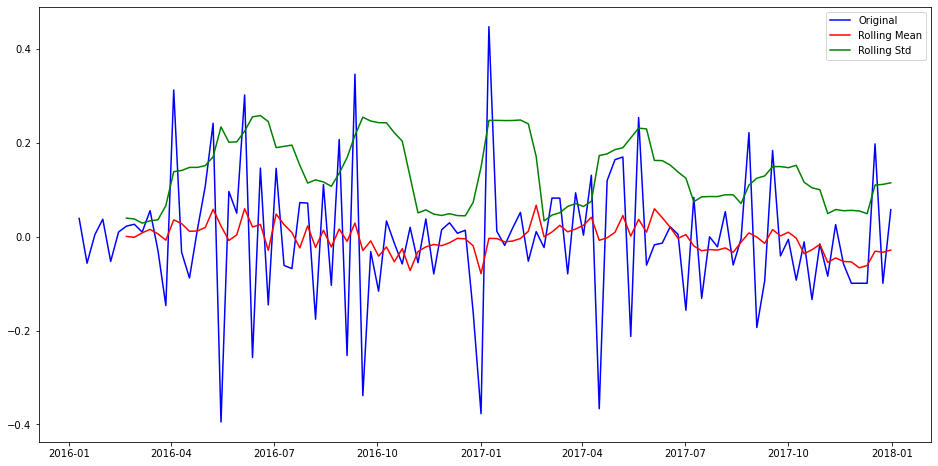

Results of Dickey-Fuller Test:
ADF Statistic: -9.460202
p-value: 0.000000
Critical Values:
1% -3.4968181663902103
5% -2.8906107514600103
10% -2.5822770483285953


In [197]:
df_8842_log = np.log(df_8842[['UnitSales']])
df_8842_log_diff = df_8842_log - df_8842_log.shift()
df_8842_log_diff.dropna(inplace=True)
df_8842_log_diff_resample = df_8842_log_diff.resample('W').mean()
test_stationarity(df_8842_log_diff_resample)

##### Now, p-value has reduced and is smaller than 0.05, Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
##### Further transformations not required

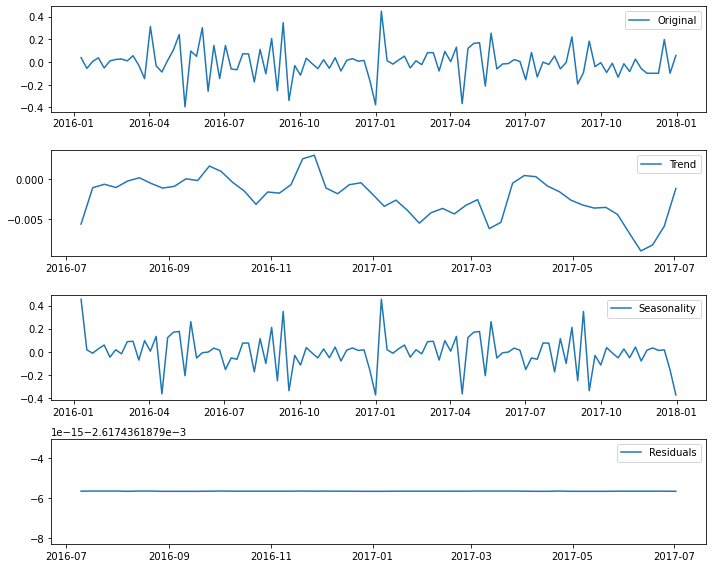

In [217]:
# Plotting seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_8842_log_diff_resample)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure(figsize=(10,8))
plt.subplot(411)
plt.plot(df_8842_log_diff_resample, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

##### From the above plots, we can see that there are not much of seasonality, trend present in our data, and no residual noice. 
##### So, we’ll use the forecasting models that take both of these factors into consideration.

# Forecasting: Predictive Modelling

## Model 1: Autoregressive Integrated Moving Average (ARIMA)
* ARIMA models are denoted by ARIMA(p, d, q).
    * p, d, and q represent seasonality, trend, and noise in data respectively
* Number of AR (Auto-Regressive) terms (p): AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).

* Number of MA (Moving Average) terms (q): MA terms are lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.

* Number of Differences (d): These are the number of nonseasonal differences, i.e. in this case we took the first order difference. So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate same results.

##### Creating all possible combinations of p, d, and q 

In [181]:
# Define the p, d and q parameters to take any value between 0 and 3
p = d = q = range(0, 2)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA: ')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA: 
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


### Hyperparameter tuning for ARIMA
* In order to choose the best combination of the above parameters, we’ll use a grid search. The best combination of parameters will give the lowest Akaike information criterion (AIC) score. AIC tells us the quality of statistical models for a given set of data.
* Using Log Differenced Data for Training and Prediction

#### Determing p,d,q combinations with AIC scores.

In [198]:
# Determing p,d,q combinations with AIC scores.
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_8842_log_diff_resample,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.23837D-01    |proj g|=  6.20932D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2     20      1     0     0   4.836D-04  -5.239D-01
  F = -0.52385651063140726     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:-106.9621542113327
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variabl

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     12     28      1     0     0   6.729D-05  -3.783D-01
  F = -0.37831311205733764     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:-74.68912730792623
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.27733D-01    |proj g|=  3.97342D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explor

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:-41.257438190959405
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.01304D-01    |proj g|=  6.73876D-01

At iterate    5    f= -3.18883D-01    |proj g|=  7.08219D-01

At iterate   10    f= -3.25176D-01    |proj g|=  3.12697D-02

At iterate   15    f= -3.25329D-01    |proj g|=  1.27382D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     24      1     0     0   3.284D-05  -3.253D-01
  F = -0.32532863139604379     

CONVERGENCE:

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.48221D-01    |proj g|=  5.00049D-01

At iterate    5    f= -5.55321D-01    |proj g|=  4.41205D-01

At iterate   10    f= -5.59956D-01    |proj g|=  1.13882D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     18      1     0     0   2.421D-05  -5.601D-01
  F = -0.56005801865773797     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:-110.4920678808095
RUNNING THE L-

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -4.65209D-01    |proj g|=  5.49691D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     24      1     0     0   5.827D-05  -4.652D-01
  F = -0.46520889958100259     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:-90.76345111284854
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.47298D-01    |proj g|=  7.24086D-01

At iterate    5    f= -5.51913D-01    |proj g|=  3.54499D-01

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -5.62130D-01    |proj g|=  2.80950D-02

At iterate   25    f= -5.62144D-01    |proj g|=  2.16552D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     30      1     0     0   2.166D-06  -5.621D-01
  F = -0.56214394166807413     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:-108.92593986695941
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.00087D-01    |proj g|=  4.06592D-01

At iterate  

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -3.93421D-01    |proj g|=  9.40762D-02

At iterate   10    f= -4.12716D-01    |proj g|=  6.15970D-02

At iterate   15    f= -4.13943D-01    |proj g|=  1.56368D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     25      1     0     0   5.183D-04  -4.139D-01
  F = -0.41394634644655953     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:-78.10084006088438
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:11.318406679378437
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.21604D-01    |proj g|=  3.95631D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      4      7      1     0     0   2.111D-05   3.172D-01
  F =  0.31723186939416009     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:67.9842288339853
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =     


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8     50      2     0     0   3.671D-05   3.550D-02
  F =   3.5495849480344940E-002

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:11.383136691911748
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.25163D-02    |proj g|=  1.36043D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explor

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.28815D-01    |proj g|=  4.50671D-01

At iterate   10    f= -1.33599D-01    |proj g|=  1.84145D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     11     18      1     0     0   4.601D-05  -1.336D-01
  F = -0.13359878006536785     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:-23.788546253596515
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.37840D-01    |proj g|=  2.25213D+00

At iterate  

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -4.00005D-01    |proj g|=  9.16946D-01

At iterate   10    f= -4.06982D-01    |proj g|=  3.28778D-02

At iterate   15    f= -4.11443D-01    |proj g|=  4.41105D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     24      1     0     0   2.523D-06  -4.117D-01
  F = -0.41168946811798401     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:-77.63140936854067
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     23      1     0     0   9.692D-06  -1.905D-01
  F = -0.19048549443895199     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:-33.620982843302016
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.29417D-01    |proj g|=  1.90287D+00

At iterate    5    f= -2.63571D-01    |proj g|=  1.35845D+00

At iterate   10    f= -2.82118D-01    |proj g|=  2.44731D-01

At iterate  

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     54      2     0     0   2.771D-04  -5.521D-01
  F = -0.55211299210093234     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:-108.83950235699392
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.85960D-01    |proj g|=  3.06808D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explo

 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:-95.35481143436006
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.47727D-01    |proj g|=  3.93719D-01

At iterate    5    f= -5.48464D-01    |proj g|=  6.40388D-02

At iterate   10    f= -5.48553D-01    |proj g|=  2.07760D-03

At iterate   15    f= -5.48554D-01    |proj g|=  7.63882D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     26      1     0     0   7.317D-05  -5.486D-01
  F = -0.54855432543364380     

CONVERGENCE: 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.26873D-01    |proj g|=  9.01215D-01

At iterate    5    f= -3.36372D-01    |proj g|=  2.27711D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     14      1     0     0   2.943D-04  -3.364D-01
  F = -0.33638690931947945     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:-63.96847713845173
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


    4     23     27      1     0     0   3.919D-07  -5.642D-01
  F = -0.56422884812061025     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:-109.35960040908692
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.11237D-01    |proj g|=  7.89773D-02

At iterate    5    f= -3.11425D-01    |proj g|=  4.43396D-02

At iterate   10    f= -3.11592D-01    |proj g|=  2.60353D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11 

 This problem is unconstrained.



At iterate   10    f= -4.73857D-01    |proj g|=  5.68487D-02

At iterate   15    f= -4.76394D-01    |proj g|=  1.46915D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     27      1     0     0   3.071D-05  -4.764D-01
  F = -0.47642118397243605     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:-91.0956062662667
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.68688D-01    |proj g|=  2.99548D-01

At iterate    

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     29      1     0     0   1.930D-04  -5.717D-01
  F = -0.57166880965114741     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:-110.90711240743866
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.55043D-01    |proj g|=  3.71007D-01

At iterate    5    f= -5.64938D-01    |proj g|=  1.48556D-01

At iterate   10    f= -5.65598D-01    |proj g|=  3.86950D-02

At iterate  

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -3.97279D-01    |proj g|=  3.14535D-01

At iterate   10    f= -4.11241D-01    |proj g|=  6.81690D-01

At iterate   15    f= -4.26134D-01    |proj g|=  4.68696D-02

At iterate   20    f= -4.27173D-01    |proj g|=  9.53686D-02

At iterate   25    f= -4.35184D-01    |proj g|=  1.29371D-01

At iterate   30    f= -4.36093D-01    |proj g|=  2.31760D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     48      1     0     0   3.875D-04  -4.361D-01
  F = -0.43609336909832069     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:-80.7074207724

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     15      1     0     0   1.036D-04  -2.460D-01
  F = -0.24603453552976656     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:-45.17518339019144
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.53542D-02    |proj g|=  2.15821D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explore

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -2.44531D-01    |proj g|=  5.14956D-02

At iterate   10    f= -2.44588D-01    |proj g|=  5.98277D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     22      1     0     0   9.166D-05  -2.446D-01
  F = -0.24458833977807420     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:-44.874374673839434
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.15363D-01    |proj g|=  6.01293D-01

At iterate  

 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:-37.293812846034484
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.42345D-01    |proj g|=  8.55591D-01

At iterate    5    f= -6.06398D-01    |proj g|=  5.94898D-02

At iterate   10    f= -6.07804D-01    |proj g|=  1.71511D-01

At iterate   15    f= -6.07943D-01    |proj g|=  2.97306D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     20      1     0     0   2.973D-06  -6.079D-01
  F = -0.60794348509727925     

CONVERGENCE:

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -2.51265D-01    |proj g|=  3.38165D-01

At iterate   10    f= -2.56168D-01    |proj g|=  1.34268D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     17      1     0     0   2.009D-05  -2.562D-01
  F = -0.25617437848780544     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:-47.284270725463536
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.98905D-01    |proj g|=  2.15125D+00

At iterate  

 This problem is unconstrained.



At iterate   10    f= -4.53850D-01    |proj g|=  3.09829D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     23      1     0     0   3.471D-04  -4.539D-01
  F = -0.45385729835118899     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:-86.40231805704731
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.63396D-01    |proj g|=  5.31602D-01

At iterate    5    f= -5.16211D-01    |proj g|=  1.12861D-01

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.36266D-01    |proj g|=  3.18493D-01

At iterate    5    f= -5.19003D-01    |proj g|=  2.06026D-01

At iterate   10    f= -5.20868D-01    |proj g|=  6.80577D-02

At iterate   15    f= -5.24596D-01    |proj g|=  1.22797D-01

At iterate   20    f= -5.24817D-01    |proj g|=  1.08807D-02

At iterate   25    f= -5.24820D-01    |proj g|=  4.73453D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     38      1     0     0   

 This problem is unconstrained.



At iterate   20    f= -3.07874D-01    |proj g|=  7.53775D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     27      1     0     0   7.538D-05  -3.079D-01
  F = -0.30787422831994249     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:-56.03783949054804
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.76075D-01    |proj g|=  1.62909D+00

At iterate    5    f= -3.43853D-01    |proj g|=  5.51961D-01

At iterate   

 This problem is unconstrained.



At iterate   15    f= -4.00192D-01    |proj g|=  6.62477D-02

At iterate   20    f= -4.04375D-01    |proj g|=  3.30446D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     29      1     0     0   1.447D-05  -4.044D-01
  F = -0.40437779824742015     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:-74.1105820354634


### Here, The best p, d, q value has been identified as,
* ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:-74.1105820354634

In [199]:
# Fitting the data to ARIMA model 
model_sarima = sm.tsa.statespace.SARIMAX(df_8842_log_diff_resample,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_sarima = model_sarima.fit()
print(results_sarima.summary().tables[1])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.76075D-01    |proj g|=  1.62909D+00

At iterate    5    f= -3.43853D-01    |proj g|=  5.51961D-01

At iterate   10    f= -3.84403D-01    |proj g|=  5.55534D-01

At iterate   15    f= -4.00192D-01    |proj g|=  6.62477D-02


 This problem is unconstrained.



At iterate   20    f= -4.04375D-01    |proj g|=  3.30446D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     29      1     0     0   1.447D-05  -4.044D-01
  F = -0.40437779824742015     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5874      0.041    -14.405      0.000      -0.667      -0.507
ma.L1         -1.0639      0.091    -11.629      0.000      -1.243      -0.885
ar.S.L12      -0.2293      0.153     -1.501  

### Diagnostic plots to visualize the performance of our model.

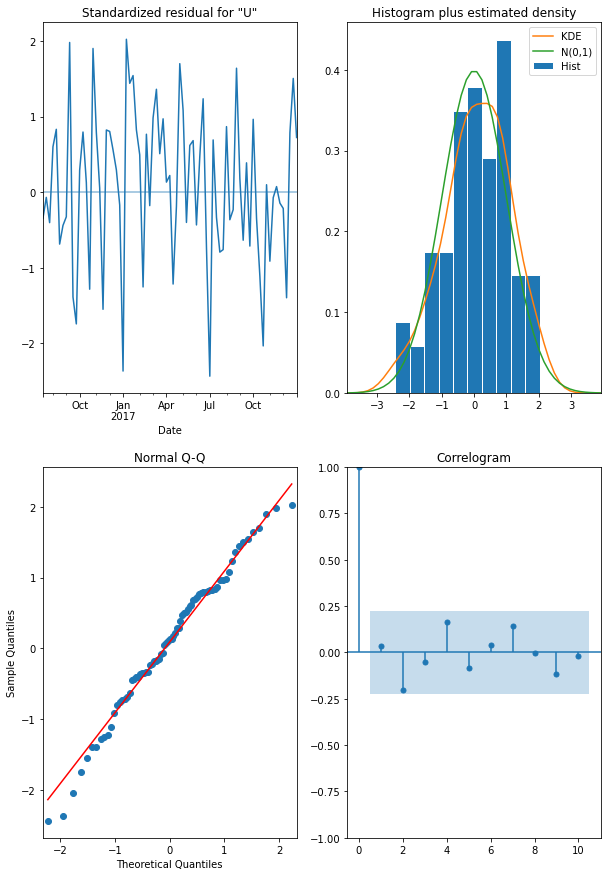

In [200]:
# Checking diagnostic plots
results_sarima.plot_diagnostics(figsize=(10, 15))
plt.show()

#### The Normal Q-Q plot shows that the ordered distribution of residuals follows the distribution similar to normal distribution. Thus, our model seems to be reasonable.

## ARIMA Model Prediction

### One-step ahead Forecast

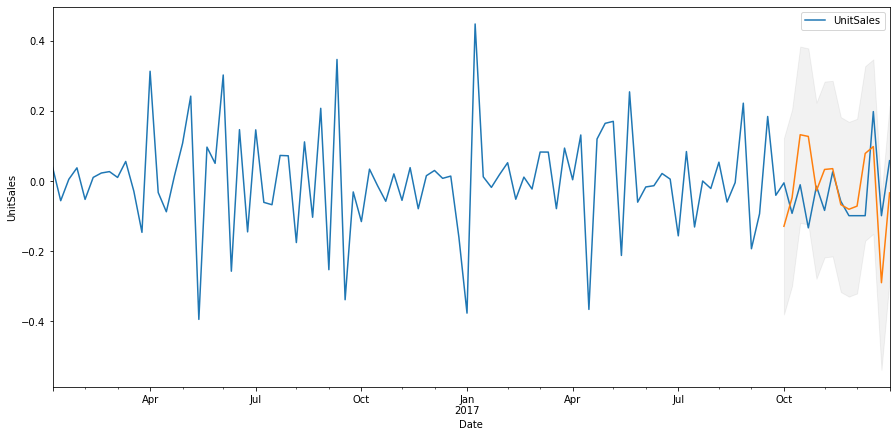

Root Mean Squared Error:  0.12168540374648373


In [203]:
# Model Prediction
# Predictions are performed for the 1st Oct' 2017 onwards 
pred = results_sarima.get_prediction(start=pd.to_datetime('2017-10-01'), dynamic = False)
# Get confidence intervals of forecasts
pred_ci = pred.conf_int()
ax = df_8842_log_diff_resample["2016":].plot(label = "observed", figsize=(15, 7))
pred.predicted_mean.plot(ax = ax, label = "One-step ahead Forecast", alpha = 1)
ax.fill_between(pred_ci.index, 
                pred_ci.iloc[:, 0], 
                pred_ci.iloc[:, 1], 
                color = "k", alpha = 0.05)
ax.set_xlabel("Date")
ax.set_ylabel("UnitSales")
plt.legend
plt.show()
train_arima_forecasted = pred.predicted_mean
train_arima_truth = df_8842_log_diff_resample["2017-10-01":]
# Calculating the error
rms_arima = sqrt(mean_squared_error(train_arima_truth, train_arima_forecasted))
print("Root Mean Squared Error: ", rms_arima)

##### The above plot shows that our predicted values catch up quite well 1 week in advance to the observed values in the datas and is well within the confidence levels
##### Our forecasts seem to align with the ground truth very well and RMSE - 0.121 is also very low in our case.
##### So, final ARIMA model can be represented as SARIMAX(1, 1, 1)x(0, 1, 1, 12)12. 
##### This is the best we can do with ARIMA, so let’s try another model to see whether we can decrease the RMSE.

## Model 2: Prophet
* Prophet is an open-source tool by Facebook. This procedure is used for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects.

#### Creating Baseline model with default hyperparameters

In [205]:
# Creating a train dataset
train_prophet = df_8842_log_diff_resample.copy()
train_prophet.reset_index(level=0, inplace=True)
# Converting col names to specific names as required by Prophet library
train_prophet = train_prophet.rename(columns = {'Date': 'ds','UnitSales': 'y'})

In [206]:
train_prophet.tail(11)

ds         y
93  2017-10-22 -0.133728
94  2017-10-29 -0.015052
95  2017-11-05 -0.083970
96  2017-11-12  0.026046
97  2017-11-19 -0.057924
98  2017-11-26 -0.099021
99  2017-12-03 -0.099021
100 2017-12-10 -0.099021
101 2017-12-17  0.198042
102 2017-12-24 -0.099021
103 2017-12-31  0.057924

In [207]:
train_prophet_1 = train_prophet.iloc[:95,:]
train_prophet_1.tail()

ds         y
90 2017-10-01 -0.005341
91 2017-10-08 -0.092375
92 2017-10-15 -0.010787
93 2017-10-22 -0.133728
94 2017-10-29 -0.015052

In [208]:
test_prophet_1 = train_prophet.iloc[95:,:].reset_index()
del test_prophet_1['index']
test_prophet_1

ds         y
0 2017-11-05 -0.083970
1 2017-11-12  0.026046
2 2017-11-19 -0.057924
3 2017-11-26 -0.099021
4 2017-12-03 -0.099021
5 2017-12-10 -0.099021
6 2017-12-17  0.198042
7 2017-12-24 -0.099021
8 2017-12-31  0.057924

#### Fitting the Prophet model

In [209]:
# Fitting data to Prophet model
prophet_1 = Prophet(yearly_seasonality=True,weekly_seasonality=True,daily_seasonality=True ) 
prophet_1.fit(train_prophet_1)

Initial log joint probability = -151.589
Iteration  1. Log joint probability =    53.3054. Improved by 204.894.
Iteration  2. Log joint probability =     55.569. Improved by 2.2636.
Iteration  3. Log joint probability =    61.2842. Improved by 5.7152.
Iteration  4. Log joint probability =    62.5227. Improved by 1.23849.
Iteration  5. Log joint probability =    62.5487. Improved by 0.0259976.
Iteration  6. Log joint probability =    62.5503. Improved by 0.00166937.
Iteration  7. Log joint probability =    62.5549. Improved by 0.00456131.
Iteration  8. Log joint probability =    62.5612. Improved by 0.00630333.
Iteration  9. Log joint probability =     62.563. Improved by 0.00178089.
Iteration 10. Log joint probability =    62.5639. Improved by 0.00092948.
Iteration 11. Log joint probability =    62.5651. Improved by 0.00119506.
Iteration 12. Log joint probability =    62.5654. Improved by 0.000264861.
Iteration 13. Log joint probability =    62.5661. Improved by 0.000760827.
Iteration 

#### Model Prediction

In [210]:
future_1 = prophet_1.make_future_dataframe(periods = 52, freq = "W") 
forecast_1 = prophet_1.predict(future_1)

In [211]:
forecast_slice = forecast_1[["ds", "yhat", "yhat_lower", "yhat_upper"]]
forecast_slice_1 = forecast_slice[(forecast_slice['ds']> '2017-10-29') & (forecast_slice['ds']< '2018-01-01')]
forecast_slice_1 = forecast_slice_1.reset_index()
del forecast_slice_1['index']
forecast_slice_1

ds      yhat  yhat_lower  yhat_upper
0 2017-11-05 -0.028992   -0.212083    0.159006
1 2017-11-12 -0.046778   -0.229224    0.124291
2 2017-11-19 -0.028773   -0.212496    0.146187
3 2017-11-26  0.022077   -0.163552    0.208386
4 2017-12-03  0.051304   -0.135052    0.236218
5 2017-12-10  0.011895   -0.164657    0.181630
6 2017-12-17 -0.073290   -0.247832    0.114374
7 2017-12-24 -0.124719   -0.299700    0.054050
8 2017-12-31 -0.088457   -0.259508    0.090136

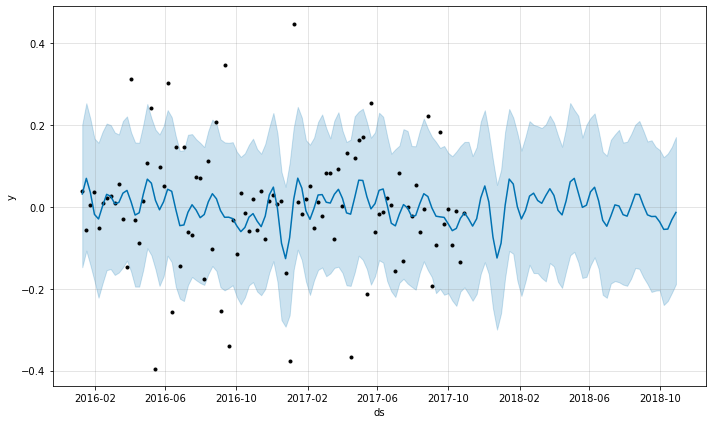

In [212]:
# Visualizing predicions of forecast
prophet_1.plot(forecast_1);

In [214]:
# Checking the RMSE of Prophet model
metric_prophet_1 = forecast_slice_1.set_index('ds')[['yhat']].join(test_prophet_1.set_index('ds').y).reset_index()
metric_prophet_1.dropna(inplace=True)
rms_prophet_1 = sqrt(mean_squared_error(metric_prophet_1.y, metric_prophet_1.yhat))
rms_prophet_1

0.1309999318273127

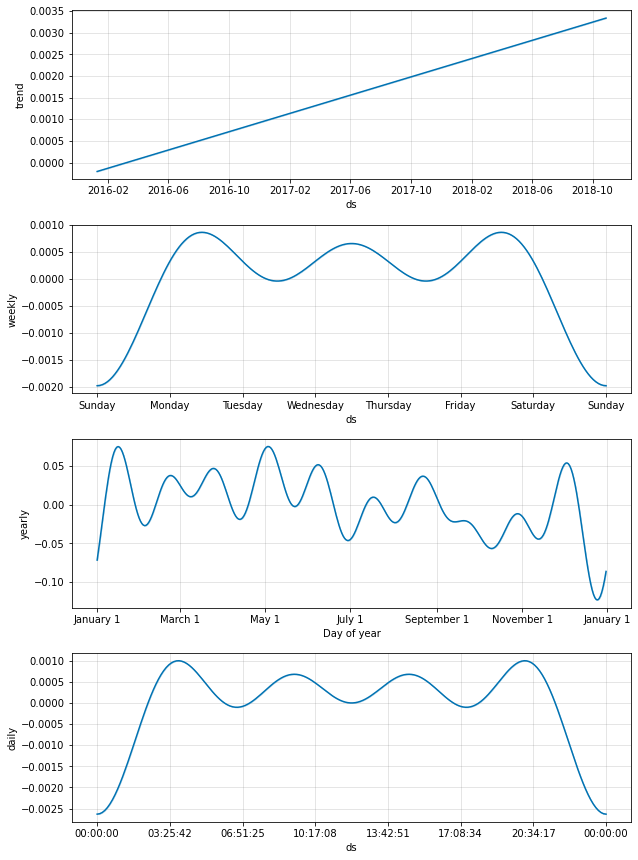

In [ ]:
# Visualizing trend and seasonality components
prophet_1.plot_components(forecast_1);

In [ ]:
forecast_slice_1['exp_yhat'] = np.exp(forecast_slice_1['yhat'])
forecast_slice_1

ds      yhat  yhat_lower  yhat_upper  exp_yhat
0 2017-11-05 -0.028992   -0.212083    0.159006  0.971424
1 2017-11-12 -0.046778   -0.229224    0.124291  0.954300
2 2017-11-19 -0.028773   -0.212496    0.146187  0.971637
3 2017-11-26  0.022077   -0.163552    0.208386  1.022323
4 2017-12-03  0.051304   -0.135052    0.236218  1.052643
5 2017-12-10  0.011895   -0.164657    0.181630  1.011966
6 2017-12-17 -0.073290   -0.247832    0.114374  0.929332
7 2017-12-24 -0.124719   -0.299700    0.054050  0.882745
8 2017-12-31 -0.088457   -0.259508    0.090136  0.915343

In [ ]:
test_prophet_1['exp_y'] = np.exp(test_prophet_1['y'])
test_prophet_1

ds         y     exp_y
0 2017-11-05 -0.083970  0.919459
1 2017-11-12  0.026046  1.026388
2 2017-11-19 -0.057924  0.943722
3 2017-11-26 -0.099021  0.905724
4 2017-12-03 -0.099021  0.905724
5 2017-12-10 -0.099021  0.905724
6 2017-12-17  0.198042  1.219014
7 2017-12-24 -0.099021  0.905724
8 2017-12-31  0.057924  1.059634

##### In FB Prophet, we see that the RMSE is 0.130 is also low and is amost close to what we got in Arima.

# Hierarchical time series forecasting
* A hierarchical time series (HTS) is a collection of time series that follows a hierarchical aggregation structure

In [54]:
# Complete Dataframe
item_avg_unitsale.head(2)

Date  CategoryCode  GroupCode  ItemNumber  IsPromo  Is_Holiday  \
0 2016-01-04          7289       5484        8842        0           0   
1 2016-01-04          7289       5484        8913        0           0   

   UnitSales  Week  Month  Year  Weekday  
0       34.0     1      1  2016        0  
1       15.0     1      1  2016        0

In [55]:
item_avg_unitsale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1597612 entries, 0 to 1597611
Data columns (total 11 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   Date          1597612 non-null  datetime64[ns]
 1   CategoryCode  1597612 non-null  int64         
 2   GroupCode     1597612 non-null  int64         
 3   ItemNumber    1597612 non-null  int64         
 4   IsPromo       1597612 non-null  int64         
 5   Is_Holiday    1597612 non-null  int64         
 6   UnitSales     1597612 non-null  float64       
 7   Week          1597612 non-null  int64         
 8   Month         1597612 non-null  int64         
 9   Year          1597612 non-null  int64         
 10  Weekday       1597612 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(9)
memory usage: 134.1 MB


In [56]:
item_avg_unitsale.isna().sum()

Date            0
CategoryCode    0
GroupCode       0
ItemNumber      0
IsPromo         0
Is_Holiday      0
UnitSales       0
Week            0
Month           0
Year            0
Weekday         0
dtype: int64

### Creating 2 Data frames one with Promotion and Without Promotion

In [57]:
unitsale_promo = item_avg_unitsale[item_avg_unitsale['IsPromo']==1].reset_index(drop = True)
unitsale_promo.head(2)

Date  CategoryCode  GroupCode  ItemNumber  IsPromo  Is_Holiday  \
0 2016-11-07          7291       5518       10678        1           0   
1 2016-11-08          7291       5518       10678        1           0   

   UnitSales  Week  Month  Year  Weekday  
0      288.0    45     11  2016        0  
1      353.0    45     11  2016        1

In [58]:
unitsale_promo.shape

(118195, 11)

In [59]:
unitsale_promo['IsPromo'].value_counts()

1    118195
Name: IsPromo, dtype: int64

In [60]:
unitsale_no_promo = item_avg_unitsale[item_avg_unitsale['IsPromo']==0].reset_index(drop = True)
unitsale_no_promo.head(2)

Date  CategoryCode  GroupCode  ItemNumber  IsPromo  Is_Holiday  \
0 2016-01-04          7289       5484        8842        0           0   
1 2016-01-04          7289       5484        8913        0           0   

   UnitSales  Week  Month  Year  Weekday  
0       34.0     1      1  2016        0  
1       15.0     1      1  2016        0

In [61]:
unitsale_no_promo.shape

(1479417, 11)

In [62]:
unitsale_no_promo['IsPromo'].value_counts()

0    1479417
Name: IsPromo, dtype: int64

## Unit Sales Heirarchical forecast for Items on Promotion

In [63]:
# lowercase the column names
unitsale_promo.columns = [col_name.lower() for col_name in unitsale_promo.columns]

In [64]:
unitsale_promo.head(2)

date  categorycode  groupcode  itemnumber  ispromo  is_holiday  \
0 2016-11-07          7291       5518       10678        1           0   
1 2016-11-08          7291       5518       10678        1           0   

   unitsales  week  month  year  weekday  
0      288.0    45     11  2016        0  
1      353.0    45     11  2016        1

In [65]:
# total unitsales grouped by "date", "categorycode", "groupcode","itemnumber"
unitsale_promo = unitsale_promo.groupby(["date", "categorycode", "groupcode","itemnumber"])["unitsales"] .sum().reset_index(drop=False)

In [66]:
unitsale_promo.head(2)

date  categorycode  groupcode  itemnumber  unitsales
0 2016-11-07          7291       5518       10678      288.0
1 2016-11-08          7291       5518       10678      353.0

In [67]:
# create the mid level id
unitsale_promo["cat_grp"] = unitsale_promo.apply(lambda x: f"{x['categorycode']}_{x['groupcode']}", axis=1)

In [68]:
# create the bottom level id
unitsale_promo["cat_grp_itm"] = unitsale_promo.apply(lambda x: f"{x['categorycode']}_{x['groupcode']}_{x['itemnumber']}", axis=1)

In [69]:
unitsale_promo.head(2)

date  categorycode  groupcode  itemnumber  unitsales    cat_grp  \
0 2016-11-07          7291       5518       10678      288.0  7291_5518   
1 2016-11-08          7291       5518       10678      353.0  7291_5518   

       cat_grp_itm  
0  7291_5518_10678  
1  7291_5518_10678

In [70]:
unitsale_promo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118195 entries, 0 to 118194
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date          118195 non-null  datetime64[ns]
 1   categorycode  118195 non-null  int64         
 2   groupcode     118195 non-null  int64         
 3   itemnumber    118195 non-null  int64         
 4   unitsales     118195 non-null  float64       
 5   cat_grp       118195 non-null  object        
 6   cat_grp_itm   118195 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 6.3+ MB


In [71]:
# Converting category, group, item to string
unitsale_promo[['categorycode', 'groupcode', 'itemnumber']] = unitsale_promo[['categorycode', 'groupcode', 'itemnumber']].astype(str)

In [72]:
unitsale_promo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118195 entries, 0 to 118194
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date          118195 non-null  datetime64[ns]
 1   categorycode  118195 non-null  object        
 2   groupcode     118195 non-null  object        
 3   itemnumber    118195 non-null  object        
 4   unitsales     118195 non-null  float64       
 5   cat_grp       118195 non-null  object        
 6   cat_grp_itm   118195 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 6.3+ MB


In [73]:
# inspect all the item per group per category
unitsale_promo.groupby(["categorycode","groupcode"])["itemnumber"].unique().to_frame()

itemnumber
categorycode groupcode                                                   
7289         5484       [9569, 8845, 10355, 10055, 11413, 9927, 8006, ...
             5495       [9290, 10445, 9144, 9987, 9433, 9589, 8267, 86...
             5503                                                 [10109]
             5506       [10282, 8113, 10942, 8607, 10792, 10136, 9496,...
             5510       [8777, 9101, 9495, 10045, 10741, 8138, 8224, 8...
...                                                                   ...
7292         5612       [8271, 8375, 8520, 9327, 9537, 10180, 11138, 8...
             5615       [8325, 8482, 9195, 9769, 10012, 10041, 10139, ...
             5616                  [9091, 8492, 9932, 10142, 10812, 9652]
             5618       [8204, 8567, 9245, 9791, 10010, 10529, 10790, ...
             5620       [8390, 8448, 10715, 8974, 8990, 11421, 8279, 1...

[132 rows x 1 columns]

In [74]:
# create the bottom level df
us_promo_bottom_level = unitsale_promo.pivot(index="date", columns="cat_grp_itm", values="unitsales")
us_promo_bottom_level.tail(2)

cat_grp_itm  7289_5484_10055  7289_5484_10355  7289_5484_10670  \
date                                                             
2017-12-30               NaN              NaN           1338.0   
2017-12-31               NaN              NaN            834.0   

cat_grp_itm  7289_5484_10852  7289_5484_11084  7289_5484_11413  \
date                                                             
2017-12-30            2245.0            247.0              NaN   
2017-12-31            1360.0            229.0              NaN   

cat_grp_itm  7289_5484_8006  7289_5484_8842  7289_5484_8845  7289_5484_8913  \
date                                                                          
2017-12-30              NaN             NaN             NaN           330.0   
2017-12-31              NaN             NaN             NaN           247.0   

cat_grp_itm  ...  7292_5618_9791  7292_5618_9992  7292_5620_10715  \
date         ...                                                    
2017-12-30   ...             NaN             NaN              NaN   
2017-12-31   ...             NaN             NaN              NaN   

cat_grp_itm  7292_5620_11335  7292_5620_11421  7292_5620_8279  7292_5620_8390  \
date                                                                            
2017-12-30               NaN              NaN             NaN             NaN   
2017-12-31               NaN              NaN             NaN             NaN   

cat_grp_itm  7292_5620_8448  7292_5620_8974  7292_5620_8990  
date                                                         
2017-12-30              NaN             NaN             NaN  
2017-12-31              NaN             NaN             NaN  

[2 rows x 2175 columns]

In [75]:
# Filling nulls with the mean of each column
us_promo_bottom_level = us_promo_bottom_level.fillna(us_promo_bottom_level.mean())

In [76]:
us_promo_bottom_level.isna().sum()

cat_grp_itm
7289_5484_10055    0
7289_5484_10355    0
7289_5484_10670    0
7289_5484_10852    0
7289_5484_11084    0
                  ..
7292_5620_8279     0
7292_5620_8390     0
7292_5620_8448     0
7292_5620_8974     0
7292_5620_8990     0
Length: 2175, dtype: int64

In [77]:
# create the middle level df 1
us_promo_middle_level_1 = unitsale_promo.groupby(["date", "cat_grp"]).sum() \
                    .reset_index(drop=False) \
                    .pivot(index="date", columns="cat_grp", values="unitsales")

In [78]:
us_promo_middle_level_1.tail(2)

cat_grp     7289_5484  7289_5495  7289_5503  7289_5506  7289_5510  7289_5512  \
date                                                                           
2017-12-30     4160.0     2416.0     1252.0        NaN    28892.0    19529.0   
2017-12-31     2670.0     1435.0     1244.0        NaN    13302.0    18110.0   

cat_grp     7289_5516  7289_5519  7289_5524  7289_5529  ...  7292_5605  \
date                                                    ...              
2017-12-30     5768.0        NaN     3949.0      298.0  ...        NaN   
2017-12-31     3345.0        NaN     3677.0      219.0  ...        NaN   

cat_grp     7292_5606  7292_5607  7292_5609  7292_5610  7292_5612  7292_5615  \
date                                                                           
2017-12-30        NaN        NaN        NaN    83684.0     6218.0     5971.0   
2017-12-31        NaN        NaN        NaN    32163.0     2373.0     2465.0   

cat_grp     7292_5616  7292_5618  7292_5620  
date                                         
2017-12-30    47549.0        NaN        NaN  
2017-12-31    17384.0        NaN        NaN  

[2 rows x 132 columns]

In [79]:
# Filling nulls with the mean of each column
us_promo_middle_level_1 = us_promo_middle_level_1.fillna(us_promo_middle_level_1.mean())
us_promo_middle_level_1.isna().sum()

cat_grp
7289_5484    0
7289_5495    0
7289_5503    0
7289_5506    0
7289_5510    0
            ..
7292_5612    0
7292_5615    0
7292_5616    0
7292_5618    0
7292_5620    0
Length: 132, dtype: int64

In [80]:
# create the middle level df 2
us_promo_middle_level_2 = unitsale_promo.groupby(["date", "categorycode"]).sum() \
                    .reset_index(drop=False) \
                    .pivot(index="date", columns="categorycode", values="unitsales")

In [81]:
us_promo_middle_level_2.tail(2)

categorycode      7289      7291      7292
date                                      
2017-12-30    336398.0  979989.0  235829.0
2017-12-31    210202.0  582399.0   93507.0

In [82]:
# Filling nulls with the mean of each column
us_promo_middle_level_2 = us_promo_middle_level_2.fillna(us_promo_middle_level_2.mean())
us_promo_middle_level_2.isna().sum()

categorycode
7289    0
7291    0
7292    0
dtype: int64

In [83]:
# create the top level df
us_promo_top_level = unitsale_promo.groupby("date")["unitsales"] \
             .sum() \
             .to_frame() \
             .rename(columns={"unitsales": "total"})

In [84]:
us_promo_top_level.head(2)

total
date             
2016-11-07  288.0
2016-11-08  353.0

In [85]:
us_promo_top_level.isna().sum()

total    0
dtype: int64

In [86]:
# join the DataFrames
hierarchy_df = us_promo_bottom_level.join(us_promo_middle_level_1) \
                              .join(us_promo_middle_level_2).join(us_promo_top_level)
hierarchy_df = hierarchy_df.resample("W") \
                           .sum()

In [87]:
hierarchy_df.head(2)

7289_5484_10055  7289_5484_10355  7289_5484_10670  \
date                                                            
2016-11-13            133.0      2676.666667      8970.294118   
2016-11-20            133.0      2676.666667      8970.294118   

            7289_5484_10852  7289_5484_11084  7289_5484_11413  7289_5484_8006  \
date                                                                            
2016-11-13     15569.441176          3023.16       292.833333     2405.777778   
2016-11-20     15569.441176          3023.16       292.833333     2405.777778   

            7289_5484_8842  7289_5484_8845  7289_5484_8913  ...  \
date                                                        ...   
2016-11-13     5023.166667     2537.666667     3809.026667  ...   
2016-11-20     5023.166667     2537.666667     3809.026667  ...   

                7292_5610     7292_5612    7292_5615      7292_5616  \
date                                                                  
2016-11-13  153701.606383  44922.611534  63947.69847  137215.196581   
2016-11-20  476031.000000  28051.750408  36038.00000  137215.196581   

               7292_5618  7292_5620          7289       7291          7292  \
date                                                                         
2016-11-13  11568.833333    13917.9  1.058018e+06     3065.0  1.392471e+06   
2016-11-20  11568.833333    13917.9  7.226540e+05  5510497.0  2.874101e+06   

                   total  
date                      
2016-11-13  3.065000e+03  
2016-11-20  9.107252e+06  

[2 rows x 2311 columns]

In [88]:
hierarchy_df.shape

(60, 2311)

In [89]:
hierarchy_df.describe()

7289_5484_10055  7289_5484_10355  7289_5484_10670  7289_5484_10852  \
count             60.0        60.000000        60.000000        60.000000   
mean             133.0      2676.666667      8970.294118     15569.441176   
std                0.0       423.851802      1115.349665      2374.133535   
min              133.0       458.000000      4714.000000      9151.000000   
25%              133.0      2676.666667      8970.294118     15569.441176   
50%              133.0      2676.666667      8970.294118     15569.441176   
75%              133.0      2676.666667      8970.294118     15569.441176   
max              133.0      5054.000000     14010.000000     24652.000000   

       7289_5484_11084  7289_5484_11413  7289_5484_8006  7289_5484_8842  \
count        60.000000     6.000000e+01       60.000000       60.000000   
mean       3023.160000     2.928333e+02     2405.777778     5023.166667   
std         588.414384     5.732312e-14      564.471938      760.763676   
min        1504.000000     2.928333e+02     1089.000000     1649.000000   
25%        3023.160000     2.928333e+02     2405.777778     5023.166667   
50%        3023.160000     2.928333e+02     2405.777778     5023.166667   
75%        3023.160000     2.928333e+02     2405.777778     5023.166667   
max        5743.000000     2.928333e+02     5462.000000     8842.000000   

       7289_5484_8845  7289_5484_8913  ...      7292_5610      7292_5612  \
count       60.000000       60.000000  ...      60.000000      60.000000   
mean      2537.666667     3809.026667  ...  153701.606383   44922.611534   
std        335.080781      882.718142  ...  108330.727332   40857.684800   
min        600.000000     1467.000000  ...    4649.000000    2771.000000   
25%       2537.666667     3809.026667  ...  105013.750000   18333.500000   
50%       2537.666667     3809.026667  ...  153701.606383   29908.500000   
75%       2537.666667     3809.026667  ...  153701.606383   50957.250000   
max       4211.000000     8338.000000  ...  476031.000000  194885.000000   

           7292_5615      7292_5616     7292_5618     7292_5620          7289  \
count      60.000000      60.000000     60.000000     60.000000  6.000000e+01   
mean    63947.698470  137215.196581  11568.833333  13917.900000  1.058018e+06   
std     39498.886945   61645.806210   1943.790090   3916.944011  4.219346e+05   
min       118.000000   18701.000000   2779.000000   1048.000000  4.183890e+05   
25%     42273.078244  113355.250000  11568.833333  13917.900000  7.629001e+05   
50%     56957.000816  137215.196581  11568.833333  13917.900000  9.669155e+05   
75%     74075.000000  139776.147436  11568.833333  13917.900000  1.211721e+06   
max    208034.000000  328247.000000  17753.000000  28671.000000  2.506273e+06   

               7291          7292         total  
count  6.000000e+01  6.000000e+01  6.000000e+01  
mean   3.673638e+06  1.392471e+06  6.083285e+06  
std    9.720886e+05  8.706431e+05  1.630475e+06  
min    3.065000e+03  3.977870e+05  3.065000e+03  
25%    3.109582e+06  7.311167e+05  5.088260e+06  
50%    3.733103e+06  9.628658e+05  5.963651e+06  
75%    4.369286e+06  2.112438e+06  7.082292e+06  
max    5.510497e+06  3.693732e+06  9.646802e+06  

[8 rows x 2311 columns]

In [90]:
print(f"Number of time series at the bottom level: {us_promo_bottom_level.shape[1]}")
print(f"Number of time series at the middle level 1: {us_promo_middle_level_1.shape[1]}")
print(f"Number of time series at the middle level 2: {us_promo_middle_level_2.shape[1]}")

Number of time series at the bottom level: 2175
Number of time series at the middle level 1: 132
Number of time series at the middle level 2: 3


### Creating the hierarchy

In [91]:
categories = unitsale_promo["categorycode"].unique()

In [92]:
total = {'total': list(categories)}

In [93]:
total

{'total': ['7291', '7289', '7292']}

In [94]:
group = unitsale_promo.groupby(["categorycode"])["cat_grp"].unique().to_dict()

In [95]:
group

{'7289': array(['7289_5495', '7289_5510', '7289_5512', '7289_5516', '7289_5524',
        '7289_5531', '7289_5545', '7289_5555', '7289_5559', '7289_5562',
        '7289_5567', '7289_5569', '7289_5576', '7289_5586', '7289_5596',
        '7289_5608', '7289_5529', '7289_5591', '7289_5614', '7289_5519',
        '7289_5604', '7289_5613', '7289_5617', '7289_5506', '7289_5484',
        '7289_5598', '7289_5536', '7289_5564', '7289_5503', '7289_5580'],
       dtype=object),
 '7291': array(['7291_5518', '7291_5493', '7291_5497', '7291_5499', '7291_5501',
        '7291_5507', '7291_5511', '7291_5513', '7291_5514', '7291_5534',
        '7291_5550', '7291_5560', '7291_5574', '7291_5593', '7291_5601',
        '7291_5538', '7291_5486', '7291_5491', '7291_5496', '7291_5502',
        '7291_5520', '7291_5544', '7291_5549', '7291_5566', '7291_5572',
        '7291_5530', '7291_5539', '7291_5543', '7291_5570', '7291_5584',
        '7291_5599', '7291_5600', '7291_5553', '7291_5571', '7291_5504',
        '729

In [96]:
item = unitsale_promo.groupby(["cat_grp"])["cat_grp_itm"].unique().to_dict()

In [97]:
dict(list(item.items())[0:1])

{'7289_5484': array(['7289_5484_9569', '7289_5484_8845', '7289_5484_10355',
        '7289_5484_10055', '7289_5484_11413', '7289_5484_9927',
        '7289_5484_8006', '7289_5484_8913', '7289_5484_10670',
        '7289_5484_10852', '7289_5484_11084', '7289_5484_8842',
        '7289_5484_9425', '7289_5484_9554', '7289_5484_9825'], dtype=object)}

In [98]:
# Creating Heirarchy
hierarchy = {**total, **group, **item}

In [99]:
# Viewing the heirarchy
dict(list(hierarchy.items())[0:2])

{'total': ['7291', '7289', '7292'],
 '7289': array(['7289_5495', '7289_5510', '7289_5512', '7289_5516', '7289_5524',
        '7289_5531', '7289_5545', '7289_5555', '7289_5559', '7289_5562',
        '7289_5567', '7289_5569', '7289_5576', '7289_5586', '7289_5596',
        '7289_5608', '7289_5529', '7289_5591', '7289_5614', '7289_5519',
        '7289_5604', '7289_5613', '7289_5617', '7289_5506', '7289_5484',
        '7289_5598', '7289_5536', '7289_5564', '7289_5503', '7289_5580'],
       dtype=object)}

In [100]:
# Forming Heirarchy Tree
from hts.hierarchy import HierarchyTree
ht = HierarchyTree.from_nodes(nodes=hierarchy, df=hierarchy_df)
ht

- total
   |- 7291
   |  |- 7291_5518
   |  |  |- 7291_5518_10678
   |  |  |- 7291_5518_9568
   |  |  |- 7291_5518_10522
   |  |  |- 7291_5518_9630
   |  |  |- 7291_5518_9346
   |  |  |- 7291_5518_11263
   |  |  |- 7291_5518_10648
   |  |  |- 7291_5518_8262
   |  |  - 7291_5518_9413
   |  |- 7291_5493
   |  |  - 7291_5493_9935
   |  |- 7291_5497
   |  |  |- 7291_5497_11213
   |  |  |- 7291_5497_9379
   |  |  |- 7291_5497_9931
   |  |  |- 7291_5497_10829
   |  |  |- 7291_5497_10901
   |  |  |- 7291_5497_8533
   |  |  |- 7291_5497_8630
   |  |  |- 7291_5497_11005
   |  |  |- 7291_5497_8737
   |  |  |- 7291_5497_8445
   |  |  |- 7291_5497_11339
   |  |  |- 7291_5497_8056
   |  |  |- 7291_5497_9885
   |  |  |- 7291_5497_10915
   |  |  |- 7291_5497_8062
   |  |  |- 7291_5497_10644
   |  |  |- 7291_5497_8731
   |  |  |- 7291_5497_9839
   |  |  |- 7291_5497_8989
   |  |  |- 7291_5497_9056
   |  |  |- 7291_5497_9149
   |  |  |- 7291_5497_10129
   |  |  |- 7291_5497_10628
   |  |  |- 7291_5497_

##### Visualizing the heirachy df

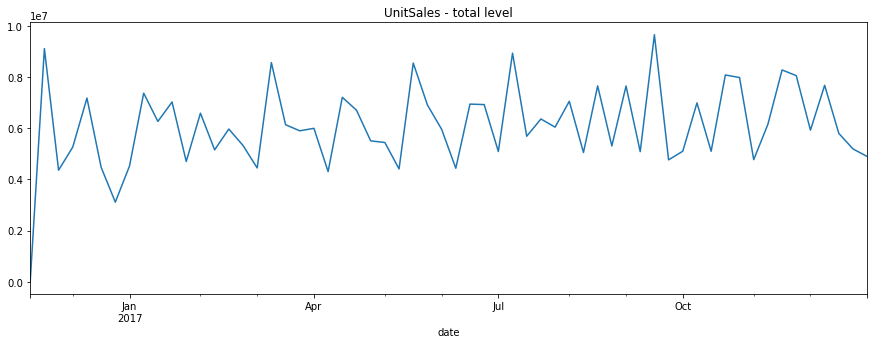

In [101]:
plt.figure(figsize=(15,5))
hierarchy_df["total"].plot(title="UnitSales - total level");

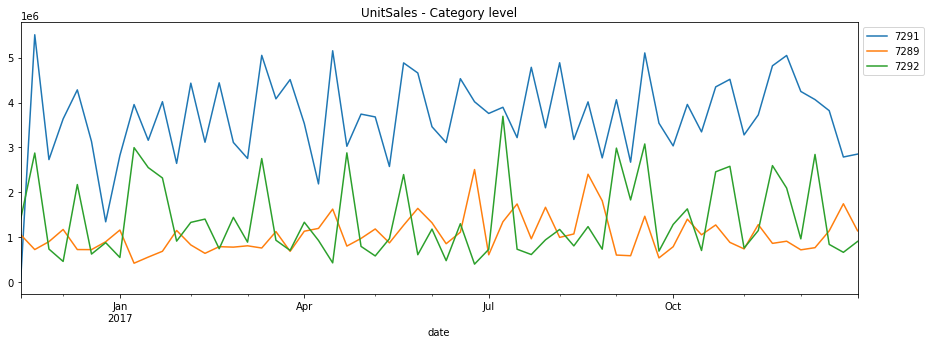

In [102]:
ax = hierarchy_df[hierarchy['total']].plot(title="UnitSales - Category level",figsize=(15, 5))
ax.legend(bbox_to_anchor=(1.0, 1.0));

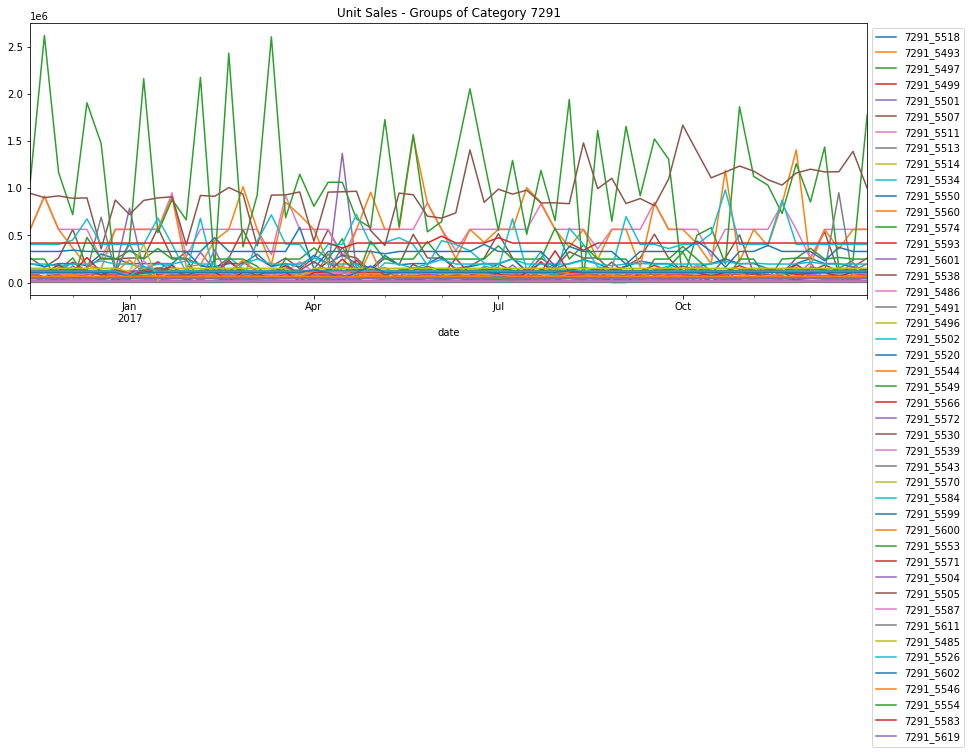

In [103]:
ax = hierarchy_df[hierarchy['7291']].plot(title="Unit Sales - Groups of Category 7291",figsize=(15, 5))
ax.legend(bbox_to_anchor=(1.0, 1.0));

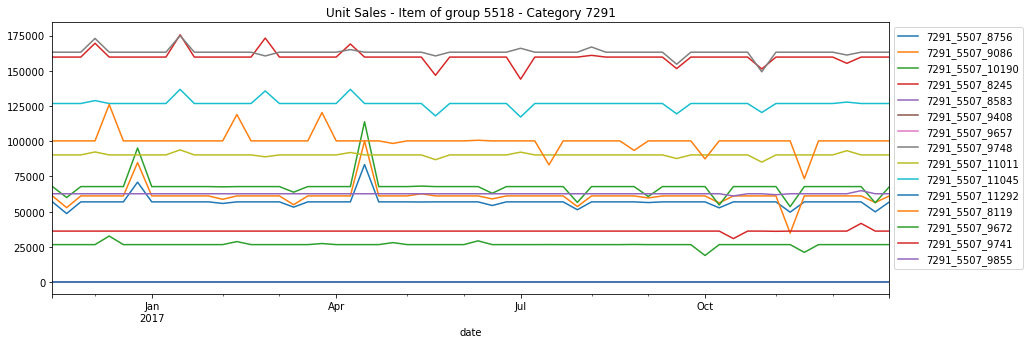

In [104]:
ax = hierarchy_df[hierarchy['7291_5507']].plot(title="Unit Sales - Item of group 5518 - Category 7291",figsize=(15, 5))
ax.legend(bbox_to_anchor=(1.0, 1.0));

#### Hierarchical time series forecasting

In [105]:
def plot_results(pred_df, source_df, cols_to_plot):
    """
    Helper function used for displaying the predictions vs. actuals for the indicated columns
    """
    
    if type(cols_to_plot) == str:
        cols_to_plot = list(cols_to_plot)
        
    for col in cols_to_plot:
        fig, ax = plt.subplots()
        pred_df[col].plot(ax=ax, label="Predicted")
        source_df[col].plot(ax=ax, label="Observed")
        
        ax.legend()
        ax.set_title(col)
        ax.set_xlabel("Date")
        ax.set_ylabel("UnitSales");
    

## The bottom-up approach

### auto_arima

In [106]:
model_bu_arima = hts.HTSRegressor(model='auto_arima', revision_method='BU', n_jobs=0)
model_bu_arima = model_bu_arima.fit(hierarchy_df, hierarchy)
pred_bu_arima = model_bu_arima.predict(steps_ahead=4)

Fitting models: 100%|██████████| 2311/2311 [00:08<00:00, 258.07it/s]


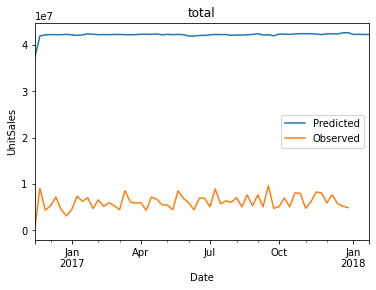

In [107]:
plot_results(pred_bu_arima, hierarchy_df, cols_to_plot=['total'])

In [188]:
# RMSE Total
rmse_bu_arima_total = mean_squared_error(hierarchy_df['total'], pred_bu_arima['total'][:60], squared=False)
rmse_bu_arima_total

36118286.07110406

#### Predictons from auto_arima on a total level itself is poor, so let us try SARIMAX, as the data a seasonality

### Sarimax

In [108]:
model_bu_sarimax = hts.HTSRegressor(model='sarimax', revision_method='BU', n_jobs=0)
model_bu_sarimax = model_bu_sarimax.fit(hierarchy_df, hierarchy)
pred_bu_sarimax = model_bu_sarimax.predict(steps_ahead=4)

Fitting models: 100%|██████████| 2311/2311 [00:06<00:00, 376.97it/s]


In [109]:
pred_bu_sarimax.shape

(64, 2311)

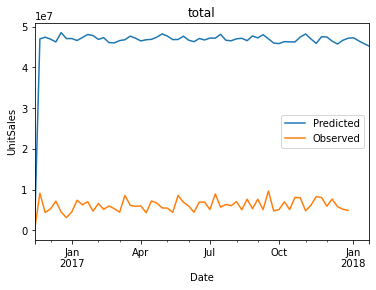

In [110]:
plot_results(pred_bu_sarimax, hierarchy_df, cols_to_plot=['total'])

In [189]:
# RMSE Total
rmse_bu_sarimax_total = mean_squared_error(hierarchy_df['total'], pred_bu_sarimax['total'][:60], squared=False)
rmse_bu_sarimax_total

40497710.763149545

#### The performance SARIMAX with 'bottom up' revision is still poor, so let us use Optimal Reconcillation on Sarimax to forecast on the each of the levels using all the information and relationships 

## Reconciliation - optimal combination using OLS 

### Sarimax - Reconciliation

In [111]:
model_ols_sarimax = hts.HTSRegressor(model='sarimax', revision_method='OLS', n_jobs=0)
model_ols_sarimax = model_ols_sarimax.fit(hierarchy_df, hierarchy)
pred_ols_sarimax = model_ols_sarimax.predict(steps_ahead=1)

Fitting models: 100%|██████████| 2311/2311 [00:05<00:00, 389.57it/s]


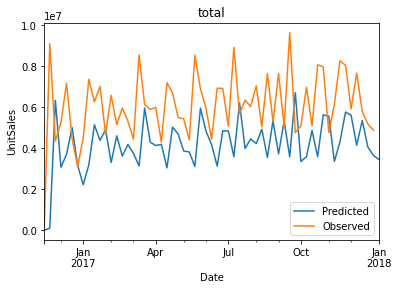

In [112]:
plot_results(pred_ols_sarimax, hierarchy_df, cols_to_plot=['total'])

In [113]:
# RMSE Total
rmse_sarimax_ols_total = mean_squared_error(hierarchy_df['total'], pred_ols_sarimax['total'][:60], squared=False)
rmse_sarimax_ols_total

2779190.5345225357

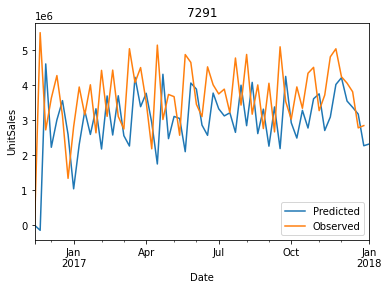

In [114]:
plot_results(pred_ols_sarimax, hierarchy_df, cols_to_plot=['7291'])

In [115]:
# RMSE at Categorical Level
rmse_sarimax_ols_cat = mean_squared_error(hierarchy_df['7291'], pred_ols_sarimax['7291'][:60], squared=False)
rmse_sarimax_ols_cat

1489068.749571317

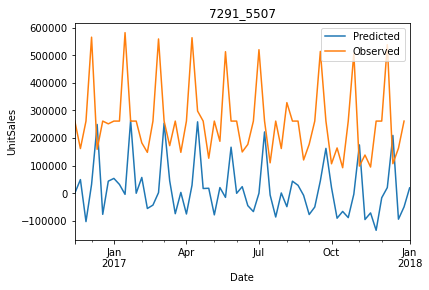

In [116]:
plot_results(pred_ols_sarimax, hierarchy_df, cols_to_plot=['7291_5507'])

In [117]:
# RMSE at Group Level
rmse_sarimax_ols_grp = mean_squared_error(hierarchy_df['7291_5507'], pred_ols_sarimax['7291_5507'][:60], squared=False)
rmse_sarimax_ols_grp

295756.5752330262

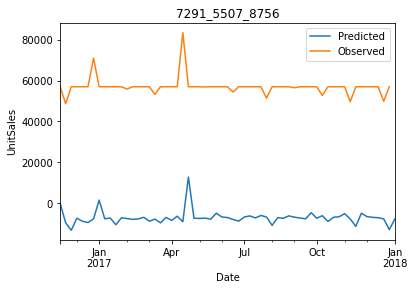

In [118]:
plot_results(pred_ols_sarimax, hierarchy_df, cols_to_plot=['7291_5507_8756'])

In [191]:
# RMSE at Group Level
rmse_sarimax_ols_item = mean_squared_error(hierarchy_df['7291_5507_8756'], pred_ols_sarimax['7291_5507_8756'][:60], squared=False)
rmse_sarimax_ols_item

64324.924077793614

#### The peformance of SARIMAX on OLS Reconcillation performs well at a total and category level, qutie fine with Group level, but not significant at item level

#### Prophet on OLS

In [177]:
model_ols_prophet = hts.HTSRegressor(model='prophet', revision_method='OLS', n_jobs=0, yearly_seasonality=True,weekly_seasonality=True, daily_seasonality=True)
model_ols_prophet = model_ols_prophet.fit(hierarchy_df, hierarchy)
pred_ols_prophet = model_ols_prophet.predict(steps_ahead=1)

Fitting models: 100%|██████████| 2311/2311 [57:17<00:00,  1.49s/it]  
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x7f72f5f8ea10>


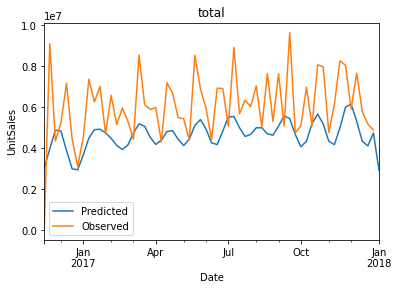

In [178]:
plot_results(pred_ols_prophet, hierarchy_df, cols_to_plot=['total'])

In [179]:
# RMSE Total
rmse_prophet_ols_total = mean_squared_error(hierarchy_df['total'], pred_ols_prophet['total'][:60], squared=False)
rmse_prophet_ols_total

1980180.4867480383

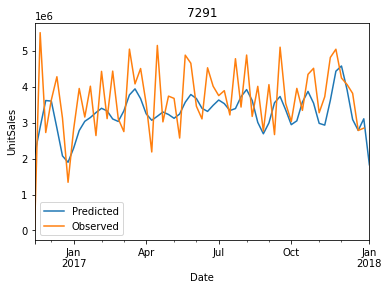

In [180]:
plot_results(pred_ols_prophet, hierarchy_df, cols_to_plot=['7291'])

In [181]:
# RMSE at Categorical Level
rmse_prophet_ols_cat = mean_squared_error(hierarchy_df['7291'], pred_ols_prophet['7291'][:60], squared=False)
rmse_prophet_ols_cat

891718.5526729795

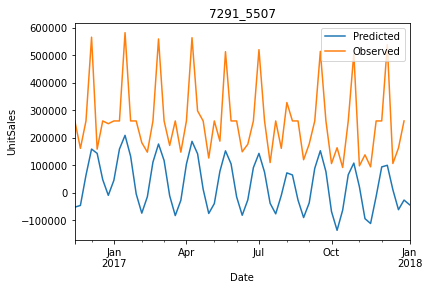

In [182]:
plot_results(pred_ols_prophet, hierarchy_df, cols_to_plot=['7291_5507'])

In [183]:
# RMSE at Group Level
rmse_prophet_ols_grp = mean_squared_error(hierarchy_df['7291_5507'], pred_ols_prophet['7291_5507'][:60], squared=False)
rmse_prophet_ols_grp

246121.15567431506

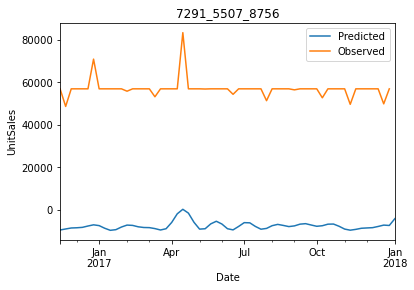

In [184]:
plot_results(pred_ols_prophet, hierarchy_df, cols_to_plot=['7291_5507_8756'])

In [185]:
# RMSE at Item Level
rmse_prophet_ols_itm = mean_squared_error(hierarchy_df['7291_5507_8756'], pred_ols_prophet['7291_5507_8756'][:60], squared=False)
rmse_prophet_ols_itm

64740.551426786995

#### The peformance of Prophet on OLS Reconcillation performs better than SARIMAX at a total, category, Group level, but not significant at item level

## Unit Sales Heirarchical forecast for Items without Promotion

In [135]:
unitsale_no_promo = item_avg_unitsale[item_avg_unitsale['IsPromo']==0].reset_index(drop = True)
unitsale_no_promo.head(2)

Date  CategoryCode  GroupCode  ItemNumber  IsPromo  Is_Holiday  \
0 2016-01-04          7289       5484        8842        0           0   
1 2016-01-04          7289       5484        8913        0           0   

   UnitSales  Week  Month  Year  Weekday  
0       34.0     1      1  2016        0  
1       15.0     1      1  2016        0

In [136]:
# lowercase the column names
unitsale_no_promo.columns = [col_name.lower() for col_name in unitsale_no_promo.columns]

# total unitsales grouped by "date", "categorycode", "groupcode","itemnumber"
unitsale_no_promo = unitsale_no_promo.groupby(["date", "categorycode", "groupcode","itemnumber"])["unitsales"] .sum().reset_index(drop=False)

In [137]:
unitsale_no_promo.head(2)

date  categorycode  groupcode  itemnumber  unitsales
0 2016-01-04          7289       5484        8842       34.0
1 2016-01-04          7289       5484        8913       15.0

In [138]:
# create the mid level id
unitsale_no_promo["cat_grp"] = unitsale_no_promo.apply(lambda x: f"{x['categorycode']}_{x['groupcode']}", axis=1)

# create the bottom level id
unitsale_no_promo["cat_grp_itm"] = unitsale_no_promo.apply(lambda x: f"{x['categorycode']}_{x['groupcode']}_{x['itemnumber']}", axis=1)

In [139]:
# Converting category, group, item to string
unitsale_no_promo[['categorycode', 'groupcode', 'itemnumber']] = unitsale_no_promo[['categorycode', 'groupcode', 'itemnumber']].astype(str)

In [140]:
unitsale_no_promo.head(2)

date categorycode groupcode itemnumber  unitsales    cat_grp  \
0 2016-01-04         7289      5484       8842       34.0  7289_5484   
1 2016-01-04         7289      5484       8913       15.0  7289_5484   

      cat_grp_itm  
0  7289_5484_8842  
1  7289_5484_8913

In [141]:
# inspect all the item per group per category
unitsale_no_promo.groupby(["categorycode","groupcode"])["itemnumber"].unique().to_frame()

itemnumber
categorycode groupcode                                                   
7289         5484       [8842, 8913, 9425, 9554, 9626, 9825, 9927, 100...
             5495       [8267, 8361, 8362, 8636, 8789, 8960, 9144, 929...
             5503                                                 [10109]
             5506       [8113, 8607, 8967, 9134, 10136, 10282, 10792, ...
             5510       [8138, 8289, 8615, 8675, 8939, 9049, 9244, 941...
...                                                                   ...
7292         5612       [8375, 8495, 9240, 9246, 9327, 9474, 9537, 990...
             5615       [8604, 8715, 8725, 8816, 8941, 9195, 9270, 946...
             5616                  [8492, 9091, 9487, 9932, 10142, 10812]
             5618       [8204, 8567, 9003, 9245, 9670, 9791, 9848, 100...
             5620           [8390, 8448, 8974, 8990, 10715, 11421, 11335]

[136 rows x 1 columns]

In [142]:
# create the bottom level df
unitsale_no_promo_bottom_level = unitsale_no_promo.pivot(index="date", columns="cat_grp_itm", values="unitsales")
unitsale_no_promo_bottom_level.tail(2)

# Filling nulls with the mean of each column
unitsale_no_promo_bottom_level = unitsale_no_promo_bottom_level.fillna(us_promo_bottom_level.mean())
unitsale_no_promo_bottom_level.isna().sum()

# create the middle level df 1
unitsale_no_promo_middle_level_1 = unitsale_no_promo.groupby(["date", "cat_grp"]).sum() \
                    .reset_index(drop=False) \
                    .pivot(index="date", columns="cat_grp", values="unitsales")

# Filling nulls with the mean of each column
unitsale_no_promo_middle_level_1 = unitsale_no_promo_middle_level_1.fillna(us_promo_middle_level_1.mean())
unitsale_no_promo_middle_level_1.isna().sum()

# create the middle level df 2
us_no_promo_middle_level_2 = unitsale_no_promo.groupby(["date", "categorycode"]).sum() \
                    .reset_index(drop=False) \
                    .pivot(index="date", columns="categorycode", values="unitsales")

# Filling nulls with the mean of each column
us_no_promo_middle_level_2 = us_no_promo_middle_level_2.fillna(us_promo_middle_level_2.mean())
us_no_promo_middle_level_2.isna().sum()

# create the top level df
us_no_promo_top_level = unitsale_no_promo.groupby("date")["unitsales"] \
             .sum() \
             .to_frame() \
             .rename(columns={"unitsales": "total"})

us_promo_top_level.isna().sum()

total    0
dtype: int64

In [143]:
# join the DataFrames
hierarchy_df_no_promo = unitsale_no_promo_bottom_level.join(unitsale_no_promo_middle_level_1) \
                              .join(us_no_promo_middle_level_2).join(us_no_promo_top_level)
# Dataframe resampled at weekly level
hierarchy_df_no_promo = hierarchy_df_no_promo.resample("W").sum()

In [144]:
hierarchy_df_no_promo.head(2)

7289_5484_10055  7289_5484_10148  7289_5484_10293  \
date                                                            
2016-01-10            121.0              0.0              0.0   
2016-01-17             97.0              0.0              0.0   

            7289_5484_10355  7289_5484_10541  7289_5484_10670  \
date                                                            
2016-01-10      2676.666667              0.0           2643.0   
2016-01-17      2676.666667              0.0           2876.0   

            7289_5484_10852  7289_5484_11084  7289_5484_11413  7289_5484_8006  \
date                                                                            
2016-01-10           2265.0             62.0            186.0     2405.777778   
2016-01-17           2240.0             99.0            185.0     2405.777778   

            ...  7292_5610  7292_5612  7292_5615  7292_5616  7292_5618  \
date        ...                                                          
2016-01-10  ...   161104.0   128431.0   116362.0   430545.0     7374.0   
2016-01-17  ...   137028.0    95631.0   123755.0   103340.0     6825.0   

            7292_5620          7289          7291          7292         total  
date                                                                           
2016-01-10    13435.0  2.984741e+06  1.570146e+07  4.860265e+06  2.354646e+07  
2016-01-17    11366.0  3.163433e+06  1.396089e+07  4.698493e+06  2.182282e+07  

[2 rows x 3532 columns]

In [145]:
hierarchy_df_no_promo.shape

(104, 3532)

In [146]:
print(f"Number of time series at the bottom level: {unitsale_no_promo_bottom_level.shape[1]}")
print(f"Number of time series at the middle level 1: {unitsale_no_promo_middle_level_1.shape[1]}")
print(f"Number of time series at the middle level 2: {us_no_promo_middle_level_2.shape[1]}")

Number of time series at the bottom level: 3392
Number of time series at the middle level 1: 136
Number of time series at the middle level 2: 3


In [147]:
### Creating the hierarchy

categories_np = unitsale_no_promo["categorycode"].unique()
total_np = {'total': list(categories)}
group_np = unitsale_no_promo.groupby(["categorycode"])["cat_grp"].unique().to_dict()
item_np = unitsale_no_promo.groupby(["cat_grp"])["cat_grp_itm"].unique().to_dict()

# Creating Heirarchy
hierarchy_nopromo = {**total_np, **group_np, **item_np}


In [148]:
# Forming Heirarchy Tree
from hts.hierarchy import HierarchyTree
ht_np = HierarchyTree.from_nodes(nodes=hierarchy_nopromo, df=hierarchy_df_no_promo)
ht_np

- total
   |- 7291
   |  |- 7291_5485
   |  |  |- 7291_5485_8036
   |  |  |- 7291_5485_8137
   |  |  |- 7291_5485_8259
   |  |  |- 7291_5485_8310
   |  |  |- 7291_5485_8523
   |  |  |- 7291_5485_8695
   |  |  |- 7291_5485_9368
   |  |  |- 7291_5485_9683
   |  |  |- 7291_5485_9699
   |  |  |- 7291_5485_9949
   |  |  |- 7291_5485_10059
   |  |  |- 7291_5485_10132
   |  |  |- 7291_5485_10170
   |  |  |- 7291_5485_10239
   |  |  |- 7291_5485_10411
   |  |  |- 7291_5485_10454
   |  |  |- 7291_5485_10568
   |  |  |- 7291_5485_10664
   |  |  |- 7291_5485_11201
   |  |  |- 7291_5485_10198
   |  |  |- 7291_5485_9280
   |  |  |- 7291_5485_9442
   |  |  |- 7291_5485_9449
   |  |  - 7291_5485_10786
   |  |- 7291_5486
   |  |  |- 7291_5486_8610
   |  |  |- 7291_5486_9286
   |  |  |- 7291_5486_9585
   |  |  |- 7291_5486_9803
   |  |  |- 7291_5486_9985
   |  |  |- 7291_5486_11169
   |  |  - 7291_5486_8389
   |  |- 7291_5491
   |  |  |- 7291_5491_8175
   |  |  |- 7291_5491_8193
   |  |  |- 7291_5491_8

#### Visualizing the hierarchy_df_no_promo

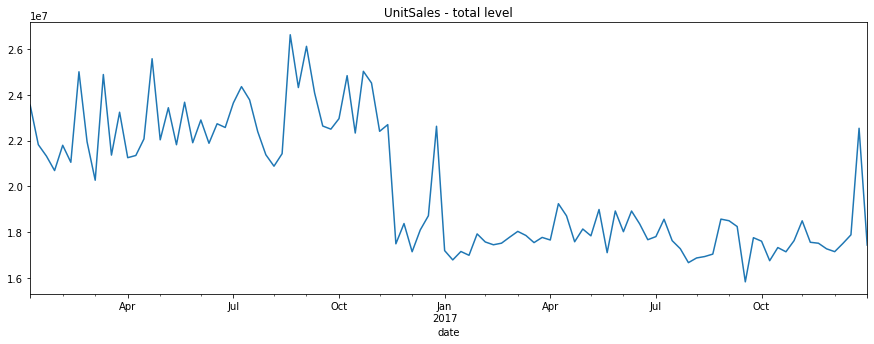

In [149]:
plt.figure(figsize=(15,5))
hierarchy_df_no_promo["total"].plot(title="UnitSales - total level");

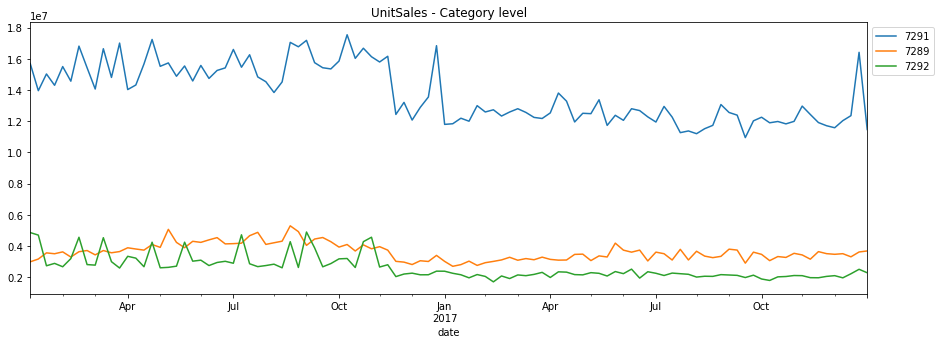

In [150]:
ax = hierarchy_df_no_promo[hierarchy_nopromo['total']].plot(title="UnitSales - Category level",figsize=(15, 5))
ax.legend(bbox_to_anchor=(1.0, 1.0));

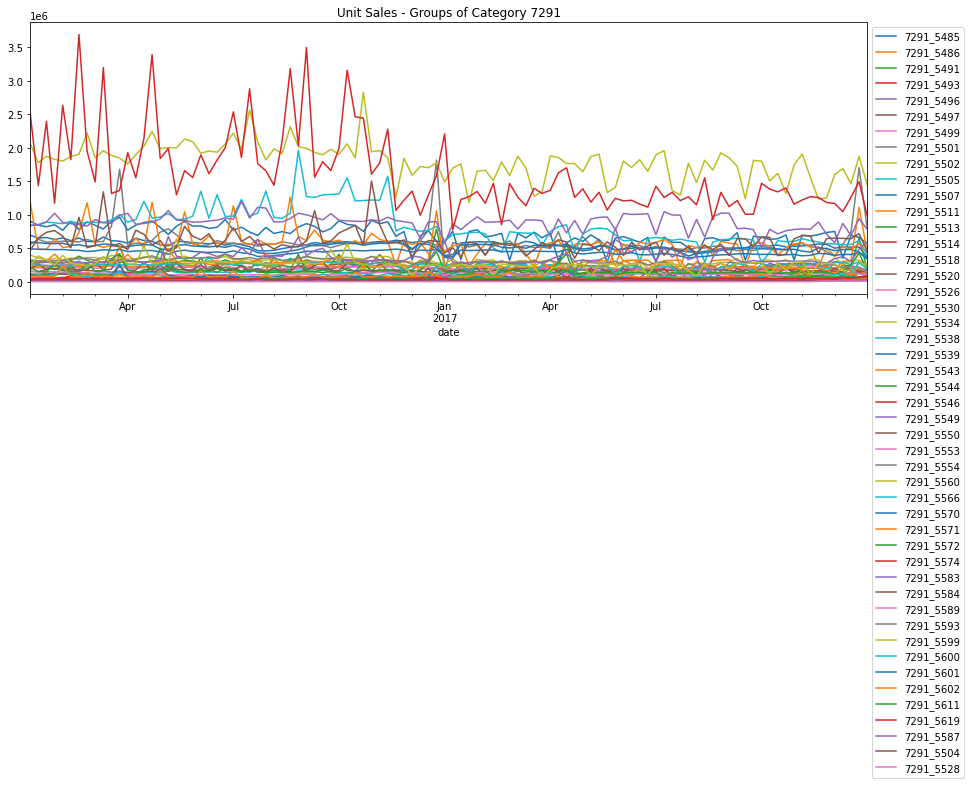

In [151]:
ax = hierarchy_df_no_promo[hierarchy_nopromo['7291']].plot(title="Unit Sales - Groups of Category 7291",figsize=(15, 5))
ax.legend(bbox_to_anchor=(1.0, 1.0));

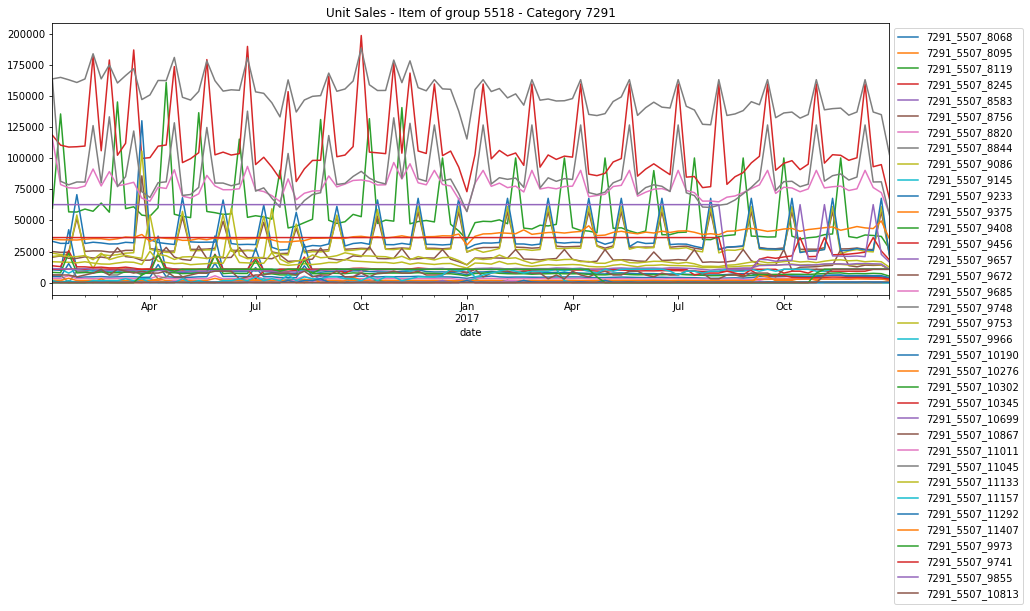

In [152]:
ax = hierarchy_df_no_promo[hierarchy_nopromo['7291_5507']].plot(title="Unit Sales - Item of group 5518 - Category 7291",figsize=(15, 5))
ax.legend(bbox_to_anchor=(1.0, 1.0));

#### Hierarchical time series forecasting

In [153]:
def plot_results(pred_df, source_df, cols_to_plot):
    """
    Helper function used for displaying the predictions vs. actuals for the indicated columns
    """
    
    if type(cols_to_plot) == str:
        cols_to_plot = list(cols_to_plot)
        
    for col in cols_to_plot:
        fig, ax = plt.subplots()
        pred_df[col].plot(ax=ax, label="Predicted")
        source_df[col].plot(ax=ax, label="Observed")
        
        ax.legend()
        ax.set_title(col)
        ax.set_xlabel("Date")
        ax.set_ylabel("UnitSales");

In [154]:
### Sarimax with Reconciliation - optimal combination using OLS 

model_ols_sarimax_np = hts.HTSRegressor(model='sarimax', revision_method='OLS', n_jobs=0)
model_ols_sarimax_np = model_ols_sarimax_np.fit(hierarchy_df_no_promo, hierarchy_nopromo)
pred_ols_sarimax_np = model_ols_sarimax_np.predict(steps_ahead=1)

Fitting models: 100%|██████████| 3532/3532 [00:09<00:00, 385.66it/s]


In [155]:
pred_ols_sarimax_np.shape

(105, 3532)

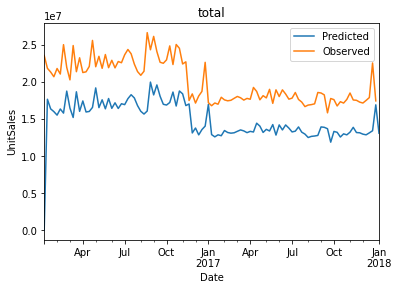

In [156]:
plot_results(pred_ols_sarimax_np, hierarchy_df_no_promo, cols_to_plot=['total'])

In [157]:
# RMSE Total
rmse_sarimax_ols_total_np = mean_squared_error(hierarchy_df_no_promo['total'], pred_ols_sarimax_np['total'][:104], squared=False)
rmse_sarimax_ols_total_np

5708076.033818679

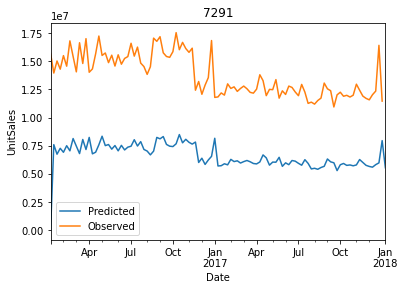

In [158]:
plot_results(pred_ols_sarimax_np, hierarchy_df_no_promo, cols_to_plot=['7291'])

In [161]:
# RMSE Category
rmse_sarimax_ols_cat_np = mean_squared_error(hierarchy_df_no_promo['7291'], pred_ols_sarimax_np['7291'][:104], squared=False)
rmse_sarimax_ols_cat_np

7337108.29546026

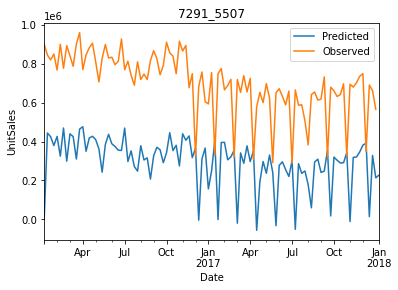

In [159]:
plot_results(pred_ols_sarimax_np, hierarchy_df_no_promo, cols_to_plot=['7291_5507'])

In [162]:
# RMSE Category
rmse_sarimax_ols_grp_np = mean_squared_error(hierarchy_df_no_promo['7291_5507'], pred_ols_sarimax_np['7291_5507'][:104], squared=False)
rmse_sarimax_ols_grp_np

442576.7054800319

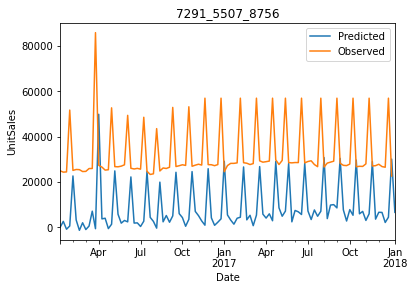

In [160]:
plot_results(pred_ols_sarimax_np, hierarchy_df_no_promo, cols_to_plot=['7291_5507_8756'])

In [163]:
# RMSE Category
rmse_sarimax_ols_itm_np = mean_squared_error(hierarchy_df_no_promo['7291_5507_8756'], pred_ols_sarimax_np['7291_5507_8756'][:104], squared=False)
rmse_sarimax_ols_itm_np

29605.820665953353

### Prophet on OLS - For No Promotion

In [164]:
model_ols_prophet_np = hts.HTSRegressor(model='prophet', revision_method='OLS', n_jobs=0, yearly_seasonality=True,weekly_seasonality=True, daily_seasonality=True)
model_ols_prophet_np = model_ols_prophet_np.fit(hierarchy_df_no_promo, hierarchy_nopromo)
pred_ols_prophet_np = model_ols_prophet_np.predict(steps_ahead=1)

Fitting models: 100%|██████████| 3532/3532 [1:28:24<00:00,  1.50s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x7f72df796190>


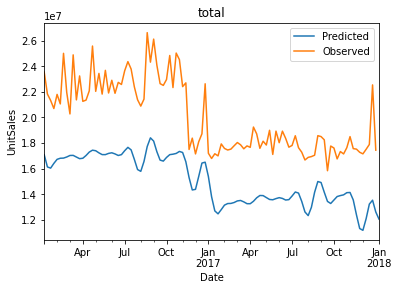

In [166]:
plot_results(pred_ols_prophet_np, hierarchy_df_no_promo, cols_to_plot=['total'])

In [167]:
# RMSE Total
rmse_prophet_ols_total_np = mean_squared_error(hierarchy_df_no_promo['total'], pred_ols_prophet_np['total'][:104], squared=False)
rmse_prophet_ols_total_np

5145024.210634299

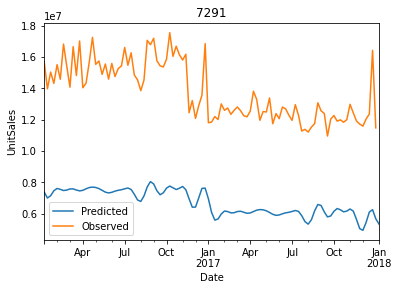

In [168]:
plot_results(pred_ols_prophet_np, hierarchy_df_no_promo, cols_to_plot=['7291'])

In [169]:
# RMSE Category
rmse_prophet_ols_cat_np = mean_squared_error(hierarchy_df_no_promo['7291'], pred_ols_prophet_np['7291'][:104], squared=False)
rmse_prophet_ols_cat_np

7187954.3463129

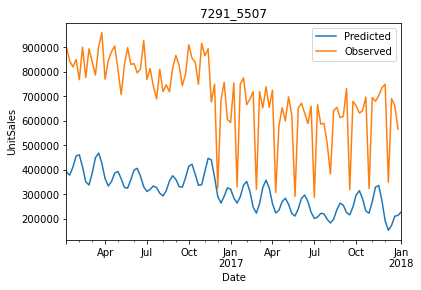

In [170]:
plot_results(pred_ols_prophet_np, hierarchy_df_no_promo, cols_to_plot=['7291_5507'])

In [171]:
# RMSE group
rmse_prophet_ols_grp_np = mean_squared_error(hierarchy_df_no_promo['7291_5507'], pred_ols_prophet_np['7291_5507'][:104], squared=False)
rmse_prophet_ols_grp_np

409033.61605918605

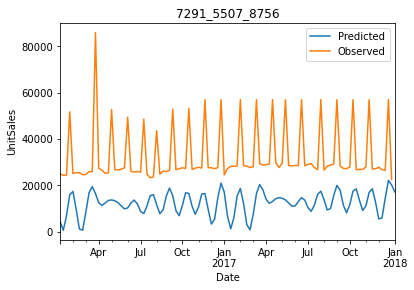

In [172]:
plot_results(pred_ols_prophet_np, hierarchy_df_no_promo, cols_to_plot=['7291_5507_8756'])

In [175]:
# RMSE group
rmse_prophet_ols_itm_np = mean_squared_error(hierarchy_df_no_promo['7291_5507_8756'], pred_ols_prophet_np['7291_5507_8756'][:104], squared=False)
rmse_prophet_ols_itm_np

23173.859296951603

## Regular Time Series approach on an Item Level is Time Consuming and costly process from a computational perspective
## Heirarchical Time Series Forecasting was reasonably better. 
## Let us Try some Regular Regression Methods 

In [39]:
sales_df_new.tail(2)

StoreCount  ShelfCapacity  PromoShelfCapacity  IsPromo  \
1597610          31          124.0                   0        0   
1597611          31          124.0                   0        0   

         national_holiday_new_years_day  national_holiday_good_friday  \
1597610                               0                             0   
1597611                               0                             0   

         national_holiday_easter_sunday  national_holiday_easter_monday  \
1597610                               0                               0   
1597611                               0                               0   

         national_holiday_kings_day  national_holiday_rememberance_day  ...  \
1597610                           0                                  0  ...   
1597611                           0                                  0  ...   

          TempMin   TempMax   TempAvg  SundurationSum  ItemNumber  \
1597610  5.188889  7.050000  5.892824        2.072222       10275   
1597611  4.800000  7.516667  5.904398        1.855556       10275   

         CategoryCode  GroupCode  UnitSales       Date  Is_Holiday  
1597610          7289       5559      239.0 2016-12-22           0  
1597611          7289       5559      314.0 2016-12-23           0  

[2 rows x 26 columns]

In [40]:
sales_df_new.columns

Index(['StoreCount', 'ShelfCapacity', 'PromoShelfCapacity', 'IsPromo',
       'national_holiday_new_years_day', 'national_holiday_good_friday',
       'national_holiday_easter_sunday', 'national_holiday_easter_monday',
       'national_holiday_kings_day', 'national_holiday_rememberance_day',
       'national_holiday_liberation_day', 'national_holiday_ascension',
       'national_holiday_white_sunday', 'national_holiday_white_monday',
       'national_holiday_christmas', 'national_holiday_boxing_day', 'TempMin',
       'TempMax', 'TempAvg', 'SundurationSum', 'ItemNumber', 'CategoryCode',
       'GroupCode', 'UnitSales', 'Date', 'Is_Holiday'],
      dtype='object')

In [43]:
sales_df_for_reg = sales_df_new[['Date','StoreCount', 'ShelfCapacity', 'PromoShelfCapacity', 'IsPromo',
       'TempMin','TempMax', 'TempAvg', 'SundurationSum',  'CategoryCode',
       'GroupCode','ItemNumber', 'Is_Holiday', 'UnitSales',]]

<AxesSubplot:>

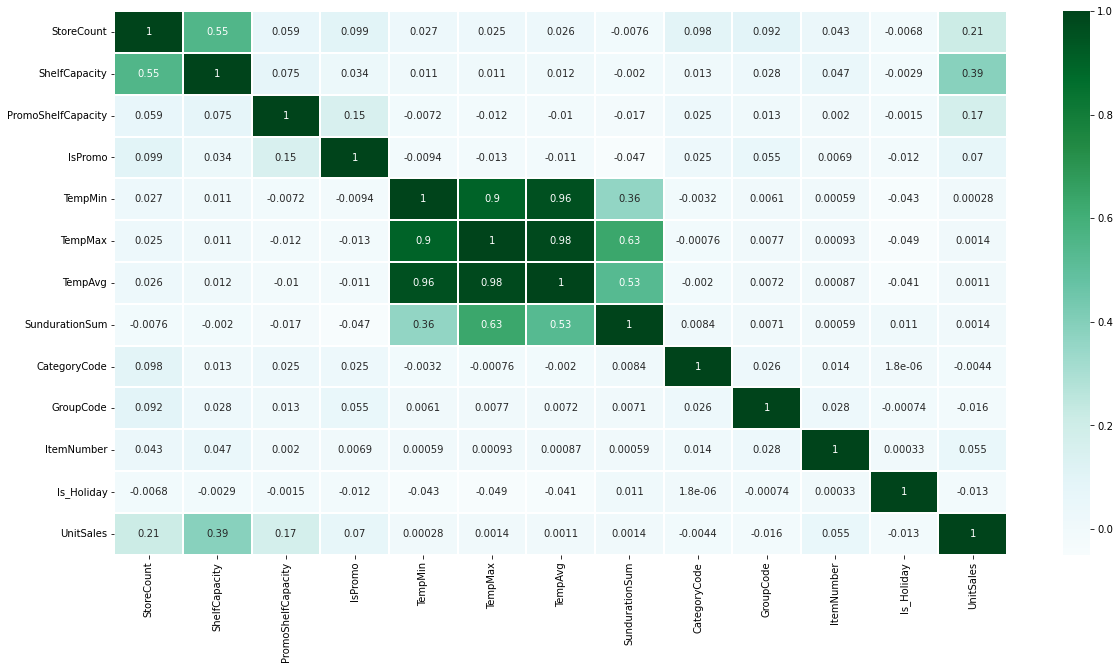

In [44]:
sales_df_for_reg_corr = sales_df_for_reg.corr()
plt.subplots(figsize=(20,10))
sns.heatmap(sales_df_for_reg_corr, cmap = 'BuGn', linewidth =.005, annot = True)

#### Before Feature Engineering we see reasonalbel correlation  between UnitSales and only 2 features - Store count and Shelf capacity

In [45]:
sales_df_for_reg.describe()

StoreCount  ShelfCapacity  PromoShelfCapacity       IsPromo  \
count  1.597612e+06   1.597612e+06        1.597612e+06  1.597612e+06   
mean   4.467702e+02   6.119501e+03        6.278720e+01  7.398229e-02   
std    3.407143e+02   8.396284e+03        8.589696e+02  2.617422e-01   
min    1.000000e+00   0.000000e+00        0.000000e+00  0.000000e+00   
25%    8.400000e+01   1.104000e+03        0.000000e+00  0.000000e+00   
50%    4.720000e+02   4.112000e+03        0.000000e+00  0.000000e+00   
75%    8.040000e+02   8.450000e+03        0.000000e+00  0.000000e+00   
max    9.340000e+02   2.202050e+05        1.602600e+05  1.000000e+00   

            TempMin       TempMax       TempAvg  SundurationSum  CategoryCode  \
count  1.597612e+06  1.597612e+06  1.597612e+06    1.597612e+06  1.597612e+06   
mean   7.742609e+00  1.383149e+01  1.085710e+01    4.999443e+00  7.290811e+03   
std    5.538930e+00  6.831356e+00  6.079579e+00    2.448168e+00  1.281750e+00   
min   -5.833333e+00 -1.500000e+00 -3.183796e+00    4.222222e-01  7.289000e+03   
25%    3.511111e+00  8.466667e+00  6.237037e+00    3.088889e+00  7.289000e+03   
50%    7.716667e+00  1.319444e+01  1.020556e+01    4.750000e+00  7.291000e+03   
75%    1.248333e+01  1.944444e+01  1.622454e+01    6.483333e+00  7.292000e+03   
max    1.950556e+01  3.107778e+01  2.476852e+01    1.343333e+01  7.292000e+03   

          GroupCode    ItemNumber    Is_Holiday     UnitSales  
count  1.597612e+06  1.597612e+06  1.597612e+06  1.597612e+06  
mean   5.551337e+03  9.733369e+03  3.129295e-02  1.532750e+03  
std    3.760921e+01  1.000738e+03  1.741084e-01  6.257294e+03  
min    5.484000e+03  8.001000e+03  0.000000e+00  1.000000e+00  
25%    5.520000e+03  8.866000e+03  0.000000e+00  4.300000e+01  
50%    5.555000e+03  9.737000e+03  0.000000e+00  1.950000e+02  
75%    5.582000e+03  1.060800e+04  0.000000e+00  1.107000e+03  
max    5.620000e+03  1.144800e+04  1.000000e+00  3.504100e+05

In [46]:
sales_df_for_reg_trans = sales_df_for_reg.copy()
# Converting category, group, item to string
sales_df_for_reg_trans[['CategoryCode', 'GroupCode', 'ItemNumber']] = sales_df_for_reg_trans[['CategoryCode', 'GroupCode', 'ItemNumber']].astype(str)
sales_df_for_reg_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1597612 entries, 0 to 1597611
Data columns (total 14 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   Date                1597612 non-null  datetime64[ns]
 1   StoreCount          1597612 non-null  int64         
 2   ShelfCapacity       1597612 non-null  float64       
 3   PromoShelfCapacity  1597612 non-null  int64         
 4   IsPromo             1597612 non-null  int64         
 5   TempMin             1597612 non-null  float64       
 6   TempMax             1597612 non-null  float64       
 7   TempAvg             1597612 non-null  float64       
 8   SundurationSum      1597612 non-null  float64       
 9   CategoryCode        1597612 non-null  object        
 10  GroupCode           1597612 non-null  object        
 11  ItemNumber          1597612 non-null  object        
 12  Is_Holiday          1597612 non-null  int64         
 13  UnitSales   

## Feature Engineering for Regression

### Target encoding Category codes , group codes, itemnumber
* Features are replaced with a blend of posterior probability of the target given particular categorical value and the prior probability of the target over all the training data.

In [47]:
encoder = TargetEncoder()
sales_df_for_reg_trans['Category_Encoded'] = encoder.fit_transform(sales_df_for_reg_trans['CategoryCode'], sales_df_for_reg_trans['UnitSales'])

In [48]:
encoder1 = TargetEncoder()
sales_df_for_reg_trans['Group_Encoded'] = encoder1.fit_transform(sales_df_for_reg_trans['GroupCode'], sales_df_for_reg_trans['UnitSales'])

In [49]:
encoder2 = TargetEncoder()
sales_df_for_reg_trans['Item_Encoded'] = encoder2.fit_transform(sales_df_for_reg_trans['ItemNumber'], sales_df_for_reg_trans['UnitSales'])

In [50]:
sales_df_for_reg_trans.head(2)

Date  StoreCount  ShelfCapacity  PromoShelfCapacity  IsPromo  \
0 2016-01-04         221         3066.0                   0        0   
1 2016-01-05         221         3066.0                   0        0   

    TempMin   TempMax   TempAvg  SundurationSum CategoryCode GroupCode  \
0  3.572222  4.527778  4.002315        1.733333         7291      5572   
1  3.083333  5.416667  4.355093        1.394444         7291      5572   

  ItemNumber  Is_Holiday  UnitSales  Category_Encoded  Group_Encoded  \
0      10032           0     1151.0        4056.23707    1093.607204   
1      10032           0      900.0        4056.23707    1093.607204   

   Item_Encoded  
0   2106.118132  
1   2106.118132

In [51]:
# Creating day of the week fromdate
sales_df_for_reg_trans['Weekday'] = sales_df_for_reg_trans['Date'].dt.weekday

In [52]:
# Creating is Is_Weekend column to see the influence of weekend and weekday on sales
sales_df_for_reg_trans['Is_Weekend'] = 1 # add a class column with 1 as default value
cond1 = sales_df_for_reg_trans['Weekday'] >= 1
cond2 = sales_df_for_reg_trans['Weekday'] <= 5
sales_df_for_reg_trans.loc[(cond1)&(cond2), 'Is_Weekend'] = 0 # then set class to 0

In [53]:
sales_df_for_reg_trans.groupby('Weekday')['Is_Weekend'].unique()

Weekday
0    [1]
1    [0]
2    [0]
3    [0]
4    [0]
5    [0]
6    [1]
Name: Is_Weekend, dtype: object

In [54]:
# Weekly Average Unit Sales of all items
wk_avg_sales = sales_df_for_reg_trans.groupby(['Category_Encoded','Group_Encoded','Item_Encoded','IsPromo','Is_Holiday','Is_Weekend']).apply(lambda x: x.resample('7D', on='Date').mean())[['StoreCount', 'ShelfCapacity', 'PromoShelfCapacity', 'TempAvg', 'SundurationSum','UnitSales']].reset_index()

In [56]:
wk_avg_sales.columns

Index(['Category_Encoded', 'Group_Encoded', 'Item_Encoded', 'IsPromo',
       'Is_Holiday', 'Is_Weekend', 'Date', 'StoreCount', 'ShelfCapacity',
       'PromoShelfCapacity', 'TempAvg', 'SundurationSum', 'UnitSales'],
      dtype='object')

In [57]:
wk_avg_sales = wk_avg_sales[['Date', 'Category_Encoded', 'Group_Encoded', 'Item_Encoded', 'IsPromo', 'Is_Holiday','Is_Weekend',
       'StoreCount', 'ShelfCapacity', 'PromoShelfCapacity', 'TempAvg',
       'SundurationSum', 'UnitSales']]
wk_avg_sales.head(2)

Date  Category_Encoded  Group_Encoded  Item_Encoded  IsPromo  \
0 2016-03-01         514.08143      32.740459     26.553267        0   
1 2016-03-08         514.08143      32.740459     26.553267        0   

   Is_Holiday  Is_Weekend  StoreCount  ShelfCapacity  PromoShelfCapacity  \
0           0           0        85.0            4.0               255.0   
1           0           0         NaN            NaN                 NaN   

    TempAvg  SundurationSum  UnitSales  
0  3.037639        3.904444      153.4  
1       NaN             NaN        NaN

In [58]:
wk_avg_sales.shape

(988930, 13)

In [61]:
# Filling the any missing value with median specific to each grouping to avoid outliers influence

In [62]:
wk_avg_sales['StoreCount'] = wk_avg_sales['StoreCount'].fillna(wk_avg_sales.groupby(['Category_Encoded','Group_Encoded','Item_Encoded','IsPromo','Is_Holiday','Is_Weekend'])['StoreCount'].transform('median'))
wk_avg_sales['ShelfCapacity'] = wk_avg_sales['ShelfCapacity'].fillna(wk_avg_sales.groupby(['Category_Encoded','Group_Encoded','Item_Encoded','IsPromo','Is_Holiday','Is_Weekend'])['ShelfCapacity'].transform('median'))
wk_avg_sales['PromoShelfCapacity'] = wk_avg_sales['PromoShelfCapacity'].fillna(wk_avg_sales.groupby(['Category_Encoded','Group_Encoded','Item_Encoded','IsPromo','Is_Holiday','Is_Weekend'])['PromoShelfCapacity'].transform('median'))
wk_avg_sales['TempAvg'] = wk_avg_sales['TempAvg'].fillna(wk_avg_sales.groupby(['Category_Encoded','Group_Encoded','Item_Encoded','IsPromo','Is_Holiday','Is_Weekend'])['TempAvg'].transform('median'))
wk_avg_sales['SundurationSum'] = wk_avg_sales['SundurationSum'].fillna(wk_avg_sales.groupby(['Category_Encoded','Group_Encoded','Item_Encoded','IsPromo','Is_Holiday','Is_Weekend'])['SundurationSum'].transform('median'))
wk_avg_sales['UnitSales'] = wk_avg_sales['UnitSales'].fillna(wk_avg_sales.groupby(['Category_Encoded','Group_Encoded','Item_Encoded','IsPromo','Is_Holiday','Is_Weekend'])['UnitSales'].transform('median'))

In [63]:
wk_avg_sales.set_index('Date',inplace = True)

In [65]:
percent_missing_sales_df = wk_avg_sales.isnull().sum() * 100 / len(wk_avg_sales)
missing_value_sales_df = pd.DataFrame({'percent_missing': percent_missing_sales_df})
missing_value_sales_df

percent_missing
Category_Encoded                0.0
Group_Encoded                   0.0
Item_Encoded                    0.0
IsPromo                         0.0
Is_Holiday                      0.0
Is_Weekend                      0.0
StoreCount                      0.0
ShelfCapacity                   0.0
PromoShelfCapacity              0.0
TempAvg                         0.0
SundurationSum                  0.0
UnitSales                       0.0

In [66]:
wk_avg_sales.describe()

Category_Encoded  Group_Encoded   Item_Encoded        IsPromo  \
count     988930.000000  988930.000000  988930.000000  988930.000000   
mean        1488.435855    1505.721120    1589.390107       0.157051   
std         1465.130860    3182.665615    5107.190699       0.363849   
min          514.081430      32.740459       6.660099       0.000000   
25%          514.081430     326.661856     110.642072       0.000000   
50%          880.964825     540.846030     316.429945       0.000000   
75%          880.964825    1213.645020    1075.076923       0.000000   
max         4056.237070   32235.890073   96883.000000       1.000000   

          Is_Holiday     Is_Weekend     StoreCount  ShelfCapacity  \
count  988930.000000  988930.000000  988930.000000  988930.000000   
mean        0.376785       0.507234     483.524538    6461.652252   
std         0.484581       0.499948     335.237040    8179.354318   
min         0.000000       0.000000       1.000000       0.000000   
25%         0.000000       0.000000     125.000000    1573.000000   
50%         0.000000       1.000000     539.000000    4630.450000   
75%         1.000000       1.000000     822.500000    8980.950000   
max         1.000000       1.000000     933.000000  220205.000000   

       PromoShelfCapacity        TempAvg  SundurationSum      UnitSales  
count       988930.000000  988930.000000   988930.000000  988930.000000  
mean            79.159032       9.978429        4.863534    1447.003003  
std            769.559798       4.355612        1.598957    5981.331601  
min              0.000000      -2.684336        0.422222       1.000000  
25%              0.000000       7.766088        4.163889      48.000000  
50%              0.000000       8.885185        4.720833     197.000000  
75%              0.000000      12.464583        5.512222     892.000000  
max         160260.000000      23.984954       12.819444  314241.500000

#### Normalization - Taking Log of Unit Sales as Unit Sales has outliers in the data. Without normalization the predictions might give us negative values as we have minimun Unitsales as 1

In [67]:
wk_avg_sales['UnitSales_Log'] = np.log(wk_avg_sales['UnitSales'])

In [68]:
wk_avg_sales.describe()

Category_Encoded  Group_Encoded   Item_Encoded        IsPromo  \
count     988930.000000  988930.000000  988930.000000  988930.000000   
mean        1488.435855    1505.721120    1589.390107       0.157051   
std         1465.130860    3182.665615    5107.190699       0.363849   
min          514.081430      32.740459       6.660099       0.000000   
25%          514.081430     326.661856     110.642072       0.000000   
50%          880.964825     540.846030     316.429945       0.000000   
75%          880.964825    1213.645020    1075.076923       0.000000   
max         4056.237070   32235.890073   96883.000000       1.000000   

          Is_Holiday     Is_Weekend     StoreCount  ShelfCapacity  \
count  988930.000000  988930.000000  988930.000000  988930.000000   
mean        0.376785       0.507234     483.524538    6461.652252   
std         0.484581       0.499948     335.237040    8179.354318   
min         0.000000       0.000000       1.000000       0.000000   
25%         0.000000       0.000000     125.000000    1573.000000   
50%         0.000000       1.000000     539.000000    4630.450000   
75%         1.000000       1.000000     822.500000    8980.950000   
max         1.000000       1.000000     933.000000  220205.000000   

       PromoShelfCapacity        TempAvg  SundurationSum      UnitSales  \
count       988930.000000  988930.000000   988930.000000  988930.000000   
mean            79.159032       9.978429        4.863534    1447.003003   
std            769.559798       4.355612        1.598957    5981.331601   
min              0.000000      -2.684336        0.422222       1.000000   
25%              0.000000       7.766088        4.163889      48.000000   
50%              0.000000       8.885185        4.720833     197.000000   
75%              0.000000      12.464583        5.512222     892.000000   
max         160260.000000      23.984954       12.819444  314241.500000   

       UnitSales_Log  
count  988930.000000  
mean        5.311602  
std         2.030299  
min         0.000000  
25%         3.871201  
50%         5.283204  
75%         6.793466  
max        12.657917

In [69]:
wk_avg_sales.columns

Index(['Category_Encoded', 'Group_Encoded', 'Item_Encoded', 'IsPromo',
       'Is_Holiday', 'Is_Weekend', 'StoreCount', 'ShelfCapacity',
       'PromoShelfCapacity', 'TempAvg', 'SundurationSum', 'UnitSales',
       'UnitSales_Log'],
      dtype='object')

<AxesSubplot:>

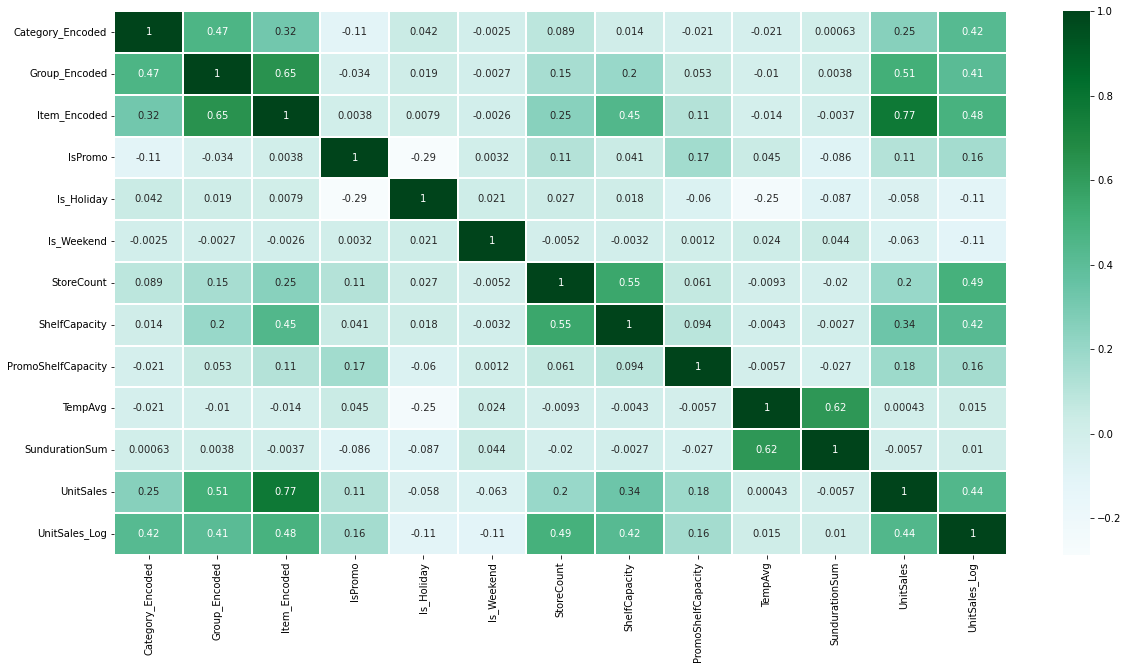

In [70]:
wk_avg_sales_corr = wk_avg_sales.corr()
plt.subplots(figsize=(20,10))
sns.heatmap(wk_avg_sales_corr, cmap = 'BuGn', linewidth =.005, annot = True)

#### After feature Engineering we see good correlation between Unitsales and,
##### Item_encode, Group Encoded, Category_encoded, Is_Promo, Is_Holiday, Is_Weekend, StoreCount, Shelf Capacity and Promo Shelf Capacity

In [71]:
wk_avg_sales_reg = wk_avg_sales[['Category_Encoded', 'Group_Encoded', 'Item_Encoded', 'IsPromo',
       'Is_Holiday', 'Is_Weekend', 'StoreCount', 'ShelfCapacity',
       'PromoShelfCapacity', 'TempAvg', 'SundurationSum',
       'UnitSales_Log']]

In [72]:
wk_avg_sales_reg.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 988930 entries, 2016-03-01 to 2017-12-24
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Category_Encoded    988930 non-null  float64
 1   Group_Encoded       988930 non-null  float64
 2   Item_Encoded        988930 non-null  float64
 3   IsPromo             988930 non-null  int64  
 4   Is_Holiday          988930 non-null  int64  
 5   Is_Weekend          988930 non-null  int64  
 6   StoreCount          988930 non-null  float64
 7   ShelfCapacity       988930 non-null  float64
 8   PromoShelfCapacity  988930 non-null  float64
 9   TempAvg             988930 non-null  float64
 10  SundurationSum      988930 non-null  float64
 11  UnitSales_Log       988930 non-null  float64
dtypes: float64(9), int64(3)
memory usage: 98.1 MB


# Regression Modelling & evaluation
* To create a basic training model, two variables will be assigned for the model to use. Twenty percent of the training data will be split into testing data that we can use to test the model with data for which the Weekly_Sales are already known.

In [74]:
#Split the data and assign 'Weekly_Sales' to 'sales_df' and the rest of the features to 'feat_df'.
feat_df = wk_avg_sales_reg[wk_avg_sales_reg.loc[ :, wk_avg_sales_reg.columns != 'UnitSales_Log'].columns]
sales_df = wk_avg_sales_reg[['UnitSales_Log']]
feat_train, feat_test, sales_train, sales_test = train_test_split(feat_df, sales_df, test_size = 0.2, random_state = 1)

In [75]:
#View inputs and outputs of training model
print('Inputs- \n', feat_train.head())
print('Outputs- \n', sales_train.head())

Inputs- 
             Category_Encoded  Group_Encoded  Item_Encoded  IsPromo  \
Date                                                                 
2017-02-06        880.964825    1583.371432     89.193359        0   
2017-02-27        880.964825     336.022000    454.127352        0   
2017-11-17        514.081430     419.233903     48.131429        0   
2017-07-10        880.964825     608.605549    588.031359        1   
2016-04-11       4056.237070    2138.696534    109.645320        0   

            Is_Holiday  Is_Weekend  StoreCount  ShelfCapacity  \
Date                                                            
2017-02-06           0           1        66.0         1359.0   
2017-02-27           0           1         4.0           56.0   
2017-11-17           1           0       646.0         6074.0   
2017-07-10           0           1       675.0         3128.0   
2016-04-11           0           1       314.5         2196.0   

            PromoShelfCapacity   TempAvg  S

## Model 3 : Linear Regression
* We will use Baseline linear regression here as Weekly_Sales is a continious variable. With all the data, we see that this is a case of Supervised Regression learning. We will establish the baseline model by appling Linear Regression to feat_train, sales_train.

In [76]:
#Create Linear Regression Object and fit the model
lm = LinearRegression()
lm.fit(feat_train,sales_train)

LinearRegression()

In [77]:
#View coeff of Linear Regression object
print(lm.intercept_)
print(lm.coef_)

[3.42386751]
[[ 4.45500188e-04  3.86571148e-05  7.62282714e-05  6.77914550e-01
  -3.87482251e-01 -4.49616895e-01  1.93397278e-03  3.27517013e-05
   2.32030189e-04 -9.95755639e-03  5.08997822e-02]]


In [78]:
#predict Weekly_Sales using training data
yhat = lm.predict(feat_train)

#View first five predictions -
print('First five predictions:' , yhat[0:5])

First five predictions: [[3.74915934]
 [3.523374  ]
 [4.87898618]
 [5.84012464]
 [5.91037789]]


In [79]:
#print MSE - 
print('Root Mean Squared Error of our prediction model', mean_squared_error(sales_train, yhat, squared = False))

Root Mean Squared Error of our prediction model 1.4012108866616202


In [80]:
#print MAE - 
print('Mean Absolute Error of our prediction model', mean_absolute_error(sales_train, yhat))

Mean Absolute Error of our prediction model 1.0515066552704615


In [81]:
# accuracy of the baseline model using 5-cross validation method - Traning Accuracy
score = cross_val_score(lm, feat_train, sales_train, cv = 5)
print('5-Cross Validation accuracy', (np.mean(score)), (np.std(score)))

5-Cross Validation accuracy 0.5238512315937806 0.003006456271142845


In [82]:
#distribution plots 
def dis_data(Rfunction, Bfunction, Rname, Bname, title):
    plt.figure(figsize=(10,6))
    ax1 = sns.distplot(Rfunction, hist = False, color = 'r', label = Rname)
    ax1 = sns.distplot(Bfunction, hist = False, color = 'b', label = Bname)
    plt.title(title)
    plt.xlabel('UnitSales')
    plt.legend()
    plt.show()
    plt.close()

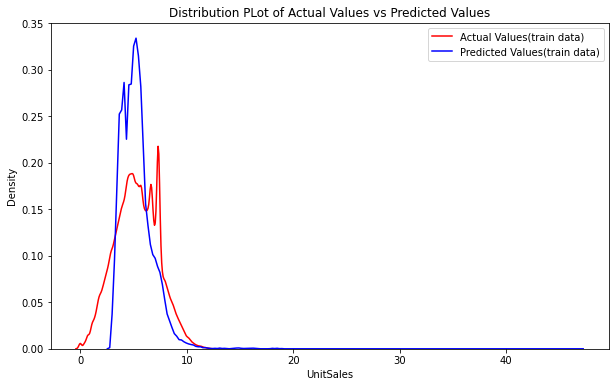

In [83]:
Title = 'Distribution PLot of Actual Values vs Predicted Values'
Rname = 'Actual Values(train data)'
Bname = 'Predicted Values(train data)'
dis_data(sales_train, yhat, Rname, Bname, Title)

In [84]:
# test set predictions in yhat_test 
yhat_test = lm.predict(feat_test)

#view first five predictions - 
print('First five predictions(test data)', yhat_test[0:5])

First five predictions(test data) [[8.087355  ]
 [4.24352085]
 [4.33932018]
 [4.60882156]
 [5.65815978]]


In [85]:
#MAE of test data - 
mae_lm = mean_absolute_error(sales_test, yhat_test)
print('Mean Absolute Error of test data ', mean_absolute_error(sales_test, yhat_test))

Mean Absolute Error of test data  1.051713167738078


In [86]:
# R2 Score - Test Accuracy
r2_lm = lm.score(feat_test, sales_test)
print('R-squared of test data-', lm.score(feat_test, sales_test))

R-squared of test data- 0.5223364803449477


In [87]:
# Rmse
lm_rmse = mean_squared_error(sales_test, yhat_test, squared=False)
lm_rmse

1.401042672282705

In [88]:
#accuracy of test data using 5-cross validation method - 
score = cross_val_score(lm, feat_test, sales_test, cv = 5)
print('5-cross validation accuracy(test data)', (np.mean(score)), (np.std(score)))

5-cross validation accuracy(test data) 0.52189002920882 0.0020665125372624914


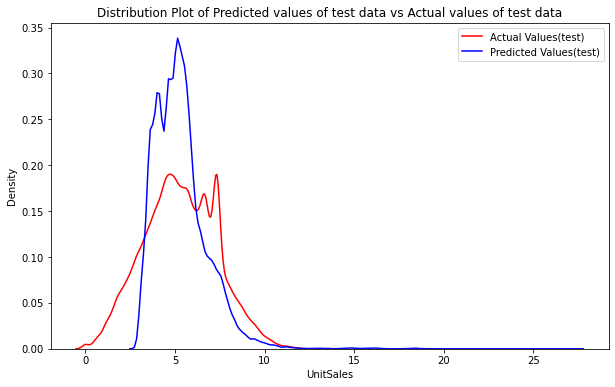

In [89]:
#Distribution plot 
Title = 'Distribution Plot of Predicted values of test data vs Actual values of test data'
dis_data(sales_test, yhat_test, 'Actual Values(test)', 'Predicted Values(test)', title = Title)

#### The baseline Linear Regression has a poor R2 score and high MAE, So let us try to improve with other models

## Model 4 : Random Forest Regressor [ Bagging Model ]

In [90]:
#create a random forest object - 
RF = RandomForestRegressor(n_estimators = 150, n_jobs = 2, max_features = 7)
RF

RandomForestRegressor(max_features=7, n_estimators=150, n_jobs=2)

In [91]:
#fit a Random Forest model on training data - 
RF.fit(feat_train, sales_train)

RandomForestRegressor(max_features=7, n_estimators=150, n_jobs=2)

In [92]:
#predict Weekly_Sales using training data
yhat = RF.predict(feat_train)

#View first five predictions -
print('First five predictions:' , yhat[0:5])

First five predictions: [1.99220687 6.1326372  3.4339872  7.02375895 4.44969483]


In [93]:
# R2 score - Traning Accuracy
print('R-squared of test data-', RF.score(feat_train, sales_train))

R-squared of test data- 0.9886766305363183


In [94]:
#make predictions on testing data and print the first five - 
yhat_RF_test = RF.predict(feat_test)
print('First five predictions-', yhat_RF_test[0:5])

First five predictions- [8.00118541 2.77258872 4.38202663 2.01490302 5.94967947]


In [95]:
#R-squared and MAE of test data - Test Accuracy
mae_rf = mean_absolute_error(sales_test, yhat_RF_test)
r2_rf = RF.score(feat_test, sales_test)
print('R-squared of test data-', RF.score(feat_test, sales_test))
print('MAE of test data-', mean_absolute_error(sales_test, yhat_RF_test))

R-squared of test data- 0.9167591531351083
MAE of test data- 0.19587347023993912


In [96]:
# R2
from sklearn.metrics import r2_score
r2_score(sales_test, yhat_RF_test)

0.9167591531351083

###### The Training Accuracy and Test Accuracy are quite close, with the training accuracy slightly more than test. This means the model is slightly overfitting which is quite common with Random Forest

In [97]:
# RMSE
rf_rmse = mean_squared_error(sales_test, yhat_RF_test, squared=False)
rf_rmse

0.5848689567151427

In [98]:
# accuracy of the  model using 5-cross validation method - Test Accuracy
score = cross_val_score(RF, feat_test, sales_test, cv = 5, scoring = 'r2')
print('5-cross validation accuracy(test data)', (np.mean(score)), (np.std(score)))

5-cross validation accuracy(test data) 0.9066298613764422 0.0029904235264550873


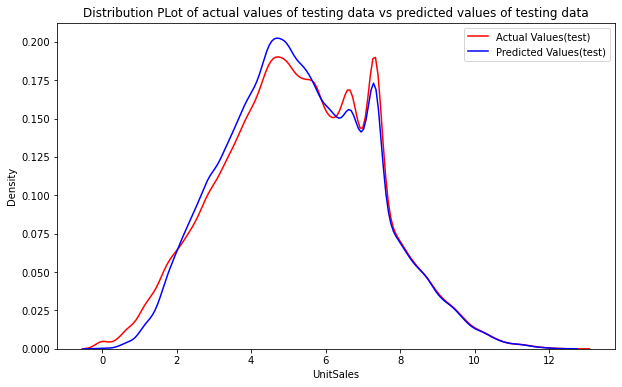

In [339]:
#view distribution plot of actual vs fitted of testing data - 
dis_data(sales_test, yhat_RF_test, 'Actual Values(test)', 'Predicted Values(test)', title = 'Distribution PLot of actual values of testing data vs predicted values of testing data')

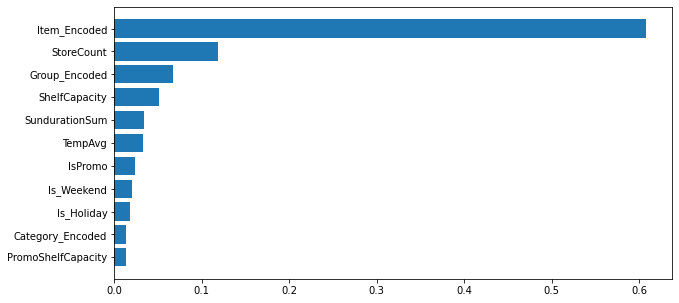

In [107]:
# Let's see the feature importance
fig, ax = plt.subplots(figsize=(10,5))
RF.feature_importances_
sorted_idx = RF.feature_importances_.argsort()
plt.barh(feat_train.columns[sorted_idx], RF.feature_importances_[sorted_idx])
plt.show()

In [378]:
sales_test.head(2)

UnitSales_Log
Date                     
2016-08-23       7.903966
2017-07-07       2.772589

In [358]:
sales_test_original = sales_test
sales_test_original ['actual_unitsale'] = np.exp(sales_test['UnitSales_Log'])
sales_test_original.head(2)

UnitSales_Log  actual_unitsale
Date                                      
2016-08-23       7.903966           2708.0
2017-07-07       2.772589             16.0

In [342]:
pred_unitsales = pd.DataFrame({'Predicted_UnitSales':yhat_RF_test})
pred_unitsales['Date'] = sales_test.index
pred_unitsales.set_index('Date', inplace = True)

In [344]:
pred_unitsales['pred_transformed_to_original_scale'] = np.exp(pred_unitsales['Predicted_UnitSales'])

In [345]:
pred_unitsales.head(2)

Predicted_UnitSales  pred_transformed_to_original_scale
Date                                                               
2016-08-23             7.983891                         2933.322713
2017-07-07             2.772589                           16.000000

#### We can see that the Random forest regressor performed well (having the lowest rmse of 0.58 and high R-squared of 91%)
#### However The Top features contributing to the model is quite significant. Let us try using a Boosting Model


## Model 5 : XGBoost Regressor [ Boosting Model ]

In [99]:
# Create XGboost Regressor
xgb = XGBRegressor()

In [100]:
xgb

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)

In [101]:
# fit xgb model on training data
xgb.fit(feat_train, sales_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [382]:
#make predictions on training data and print the first five - 
yhat = xgb.predict(feat_train)
print('First five predictions-', yhat[0:5])

First five predictions- [2.989148  4.8698153 3.3068314 7.172361  4.086625 ]


In [383]:
#R-squared and MAE of test data - Training Accuracy
print('R-squared of test data-', xgb.score(feat_train, sales_train))
print('MAE of test data-', mean_absolute_error(sales_train, yhat))

R-squared of test data- 0.8821496810728013
MAE of test data- 0.4009710345689344


In [102]:
#make predictions on testing data and print the first five - 
yhat_xgb_test = xgb.predict(feat_test)
print('First five predictions-', yhat_xgb_test[0:5])

First five predictions- [7.9969034 2.782163  4.747465  3.3426805 5.8180146]


In [103]:
#R-squared and MAE of test data - Test Accuracy
mae_xgb = mean_absolute_error(sales_test, yhat_xgb_test)
r2_xgb = xgb.score(feat_test, sales_test)
print('R-squared of test data-', xgb.score(feat_test, sales_test))
print('MAE of test data-', mean_absolute_error(sales_test, yhat_xgb_test))

R-squared of test data- 0.876222506709425
MAE of test data- 0.40748189515833266


In [104]:
from sklearn.metrics import r2_score
r2_score(sales_test, yhat_xgb_test)

0.876222506709425

###### The Training Accuracy and Test Accuracy are close, whic tells there is no over or under fitting

In [105]:
# RMSE
xgb_rmse = mean_squared_error(sales_test, yhat_xgb_test, squared=False)
xgb_rmse

0.7131997256320955

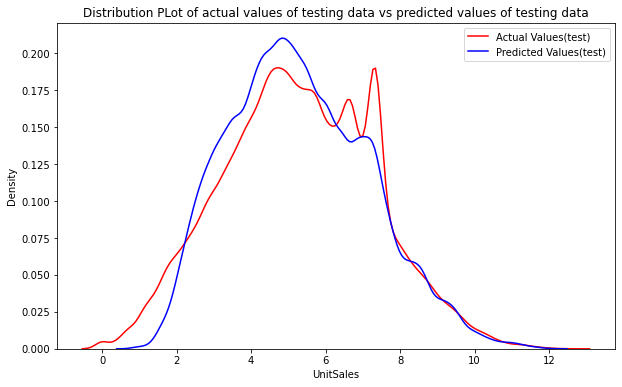

In [388]:
#view distribution plot of actual vs fitted of testing data - 
dis_data(sales_test, yhat_xgb_test, 'Actual Values(test)', 'Predicted Values(test)', title = 'Distribution PLot of actual values of testing data vs predicted values of testing data')

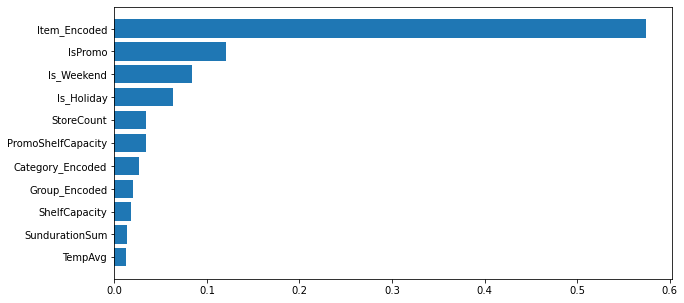

In [106]:
# Let's see the feature importance
fig, ax = plt.subplots(figsize=(10,5))
xgb.feature_importances_
sorted_idx = xgb.feature_importances_.argsort()
plt.barh(feat_train.columns[sorted_idx], xgb.feature_importances_[sorted_idx])
plt.show()

#### We can see that the XGBoost Regressor performed very well (with good R-squared of 87% and RMSE 0.713 )

#### Top 10 Features from the feature importance plot, shows quite well that features like,
* Item
* Promotion
* Is_Weeekend
* Is_Holiday
* Store Count / Promoshelf Capacity
* Category
#### Have a significant impact on the Unit Sales. This gives a high level of confidence on the prediction

# Model Evaluation
## Comparing performance of the models

### Comparison between the Time Series Models (Predicted for Single Item)
##### SARIMA
##### FB Prophet

In [521]:
# Comparing performance of Time Series Models - Through RMSE
rms_arima = format(float(rms_arima))
rms_prophet_1 = format(float(rms_prophet_1))
model_errors = pd.DataFrame({
    "Model": ["SARIMA", "Prophet"],
    "RMSE": [rms_arima, rms_prophet_1]
})
model_errors.sort_values(by = "RMSE")

Model                 RMSE
0   SARIMA  0.12168540374648373
1  Prophet   0.1309999318273127

## Comparison between the Heirarchical Time Series Forecasting Models - HTS Regressor

### On Promotion
   ##### Bottom Up Approach
        * Auto-Arima
        * SARIMAX
   ##### Reconciliation - optimal combination using OLS 
        * SARIMAX
        * FB Prophet

* Bottom Up Approach

In [190]:
#  On Promotion - Comparing performance of Heirarchical Time Series Models - Through RMSE at total level
rmse_bu_arima_total = format(float(rmse_bu_arima_total))
rmse_bu_sarimax_total = format(float(rmse_bu_sarimax_total))
model_errors = pd.DataFrame({
    "Model": ["auto-arima", "sarimax"],
    "RMSE": [rmse_bu_arima_total, rmse_bu_sarimax_total]
})
model_errors.sort_values(by = "RMSE")

Model                RMSE
0  auto-arima   36118286.07110406
1     sarimax  40497710.763149545

* Reconciliation - optimal combination using OLS 

In [194]:
#  On Promotion - Comparing performance of Heirarchical Time Series Models - Through RMSE at total level
rmse_sarimax_ols_total = format(float(rmse_sarimax_ols_total))
rmse_sarimax_ols_cat = format(float(rmse_sarimax_ols_cat))
rmse_sarimax_ols_grp = format(float(rmse_sarimax_ols_grp))
rmse_sarimax_ols_item = format(float(rmse_sarimax_ols_item))

rmse_prophet_ols_total = format(float(rmse_prophet_ols_total))
rmse_prophet_ols_cat = format(float(rmse_prophet_ols_cat))
rmse_prophet_ols_grp = format(float(rmse_prophet_ols_grp))
rmse_prophet_ols_itm = format(float(rmse_prophet_ols_itm))

model_errors = pd.DataFrame({
    "Model_1": ["sarimax", "sarimax","sarimax", "sarimax", "prophet","prophet","prophet","prophet"],
    "Level": ["total", "category","group", "item","total", "category","group", "item"],
    "RMSE": [rmse_sarimax_ols_total, rmse_sarimax_ols_cat, rmse_sarimax_ols_grp, rmse_sarimax_ols_item, rmse_prophet_ols_total, rmse_prophet_ols_cat,\
             rmse_prophet_ols_grp, rmse_prophet_ols_itm ]
})
model_errors
# model_errors.sort_values(by = "RMSE")

Model_1     Level                RMSE
0  sarimax     total  2779190.5345225357
1  sarimax  category   1489068.749571317
2  sarimax     group   295756.5752330262
3  sarimax      item  64324.924077793614
4  prophet     total  1980180.4867480383
5  prophet  category   891718.5526729795
6  prophet     group  246121.15567431506
7  prophet      item  64740.551426786995

### Not on Promotion
   ##### Reconciliation - optimal combination using OLS 
        * SARIMAX
        * FB Prophet

In [176]:
#  On Promotion - Comparing performance of Heirarchical Time Series Models - Through RMSE at total level
rmse_sarimax_ols_total_np = format(float(rmse_sarimax_ols_total_np))
rmse_sarimax_ols_cat_np = format(float(rmse_sarimax_ols_cat_np))
rmse_sarimax_ols_grp_np = format(float(rmse_sarimax_ols_grp_np))
rmse_sarimax_ols_itm_np = format(float(rmse_sarimax_ols_itm_np))

rmse_prophet_ols_total_np = format(float(rmse_prophet_ols_total_np))
rmse_prophet_ols_cat_np = format(float(rmse_prophet_ols_cat_np))
rmse_prophet_ols_grp_np = format(float(rmse_prophet_ols_grp_np))
rmse_prophet_ols_itm_np = format(float(rmse_prophet_ols_itm_np))

model_errors = pd.DataFrame({
    "Model_1": ["sarimax", "sarimax","sarimax", "sarimax", "prophet","prophet","prophet","prophet"],
    "Level": ["total", "category","group", "item","total", "category","group", "item"],
    "RMSE": [rmse_sarimax_ols_total_np, rmse_sarimax_ols_cat_np, rmse_sarimax_ols_grp_np, rmse_sarimax_ols_itm_np, rmse_prophet_ols_total_np, rmse_prophet_ols_cat_np,\
             rmse_prophet_ols_grp_np, rmse_prophet_ols_itm_np ]
})
model_errors.sort_values(by = "RMSE")

Model_1     Level                RMSE
7  prophet      item  23173.859296951603
3  sarimax      item  29605.820665953353
6  prophet     group  409033.61605918605
2  sarimax     group   442576.7054800319
4  prophet     total   5145024.210634299
0  sarimax     total   5708076.033818679
5  prophet  category     7187954.3463129
1  sarimax  category    7337108.29546026

### Comparison between the Regression Models 
##### Linear Regression
##### Random Forest Regressor (Bagging)
##### XGBoost Regressor (Boosting) 

In [109]:
# Comparing performance of Regression Models - Through RMSE & R2 Score
lm_rmse = format(float(lm_rmse))
rf_rmse = format(float(rf_rmse))
xgb_rmse = format(float(xgb_rmse))
r2_lm = format(float(r2_lm))
r2_rf = format(float(r2_rf))
r2_xgb = format(float(r2_xgb))
model_errors = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest Regressor", "XGBoost Regressor"],
    "RMSE": [lm_rmse, rf_rmse,xgb_rmse],
    "R2_Score": [r2_lm, r2_rf, r2_xgb]
})
model_errors.sort_values(by = "R2_Score")

Model                RMSE            R2_Score
0        Linear Regression   1.401042672282705  0.5223364803449477
2        XGBoost Regressor  0.7131997256320955   0.876222506709425
1  Random Forest Regressor  0.5848689567151427  0.9167591531351084

### Model Comparison & Selection

##### 1. The Timeseries models both SARIMAX and FB Prophet performs reasonably well for the single item trial. 
    * It works well considering by considering major patterns in the data such as seasonality, trend, residual noices
    * But running Time Series approach on an Item Level is Time Consuming as we would need separate forecast for each product and may require production servers with significant configuration and coputational strengths.
    * So provided we have a high end production environment (On Premises or Cloud) the best option would be is to use Timeseries forecating for any future non stationary Data.

##### 2. The Heirachical Time Series Forecasting 
    * The Heirachical Time Series Forecating using SARIMAX an Prophet with OLS Reconcillation on both Promotion and Non Promotion DF worked well on an Total and Category level, reasonably at group level, but not significant on Item Level.
    * Might need further Hyper Parameter Tuning to improve the performance
##### 3. Regression Methods
    * Though Rgression models are not specifically built for Time-series data, They tend to work well in cases like this where we need predict sales on a item level.
    * Models like XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It performs perform extremely well in all kinds of regression problems.
    
#### Final Model Selected : XGBoost Regressor
    * Though the Random Forest Regressor had better R2 score and low rmse, based on the feature importance the proportion of the variance for unit slaes that's explained by the features of importance was less significant. Top reasons were not captured.
    
    * XGBoost Regressor had good accuracy and rleatively low MSE, beyond that, it was able to capture the top reasons that affects the Unitsales per item
        * Item
        * Promotion
        * Is_Weekend
        * Is_Holiday
        * Store Count / Promoshelf Capacity
        * Category

# Automate and Deploy the model

#### Automate pipeline
* To deploy the selected model, a data pipeline will be created to automate the needed transformations once data is given as an input to the model.

In [111]:
#create pipeline for XGBoost Regressor 
input = [('model', XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=np.nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None))]
pipe = Pipeline(input)
pipe

Pipeline(steps=[('model',
                 XGBRegressor(base_score=None, booster=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, enable_categorical=False,
                              gamma=None, gpu_id=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_delta_step=None, max_depth=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, reg_alpha=None,
                              reg_lambda=None, scale_pos_weight=None,
                              subsample=None, tree_method=None,
                              validate_parameters=None, verbosity=None))])

In [112]:
#fit the pipeline to the training data
XGBmodel = pipe.fit(feat_train, sales_train)

#### The pipeline will produce predictions

In [113]:
#make predictions on the test data and print first five - 
ypipe = pipe.predict(feat_test)
ypipe[0:5]

array([7.9969034, 2.782163 , 4.747465 , 3.3426805, 5.8180146],
      dtype=float32)

#### Now the model will be saved so it can be used whenever needed.

In [114]:
import pickle
# save the classifier
with open('UnitSales_forecasting_XGB.pkl', 'wb') as fid:
    pickle.dump(XGBmodel, fid)    

#### Load the saved model

In [115]:
# load it again
with open('UnitSales_forecasting_XGB.pkl', 'rb') as fid:
    xgb_loaded = pickle.load(fid)

In [116]:
#see results of test data with known Weekly UnitSales 
result = xgb_loaded.score(feat_test, sales_test)
print(result)

0.876222506709425


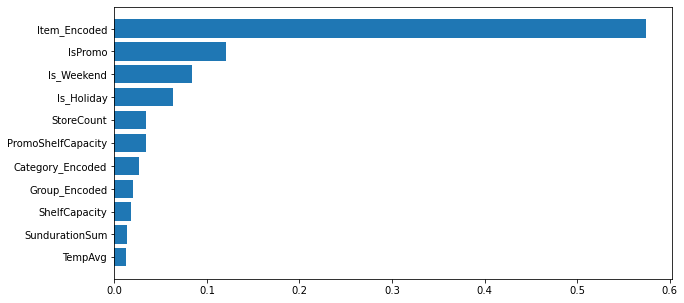

In [117]:
#Plot feature importances -
fig, ax = plt.subplots(figsize=(10,5))
xgb.feature_importances_
sorted_idx = xgb.feature_importances_.argsort()
plt.barh(feat_train.columns[sorted_idx], xgb.feature_importances_[sorted_idx])
plt.show()

# Deployment Ideas

## Approach 1 - Deployment on premises environment, using HDFS storage, Ansible for Config management, Jenkins to  create Builds, Airflow for Scheduling and ELK stack for dashboarding

* Create an Ansible playbook configuration
    * To read input from HDFS and write it back to HDFS
    * Create the Kafka topics to which the output from HDFS has to be pushed to
    * Create the Elastic Search Index to which the data from Kafka topic has to be pushed to. 
* Read data from hdfs and process it as per above steps
* Load the pre-trained model saved in HDFS , make predictions and push back the resulted dataframe to hdfs.
* Output from HDFS is pushed to Elastic Search using Kafka brokers
* Dockerize and create builds using Jenkins
* Create the Airflow dags using Jinja2 templates for executing the steps above
* When the scheduled job along with it's configurations gets executed in Airflow, Iput is read from HDFS, the processed, pretrained model is loaded and prediction happens, predicted output is pushed to HDFS, then to Kafka topic, then to Elastic Search index 
* The visual dashboard can be created on Grafana / Kibana using the data from the Elastic Search


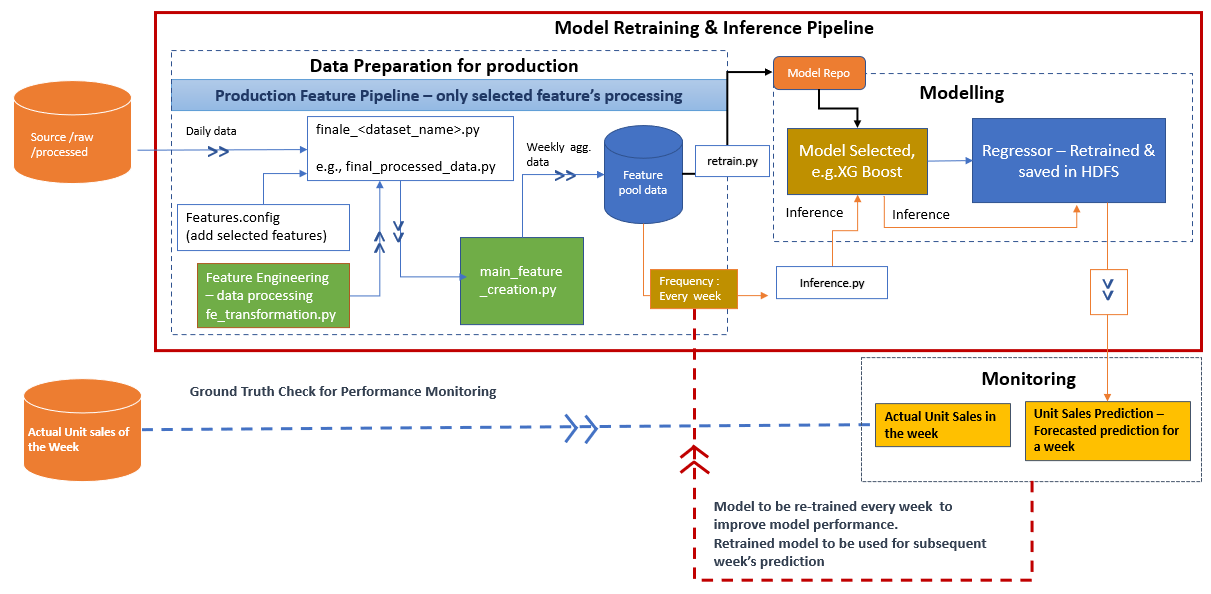

## Approach 2 - Deployment Using Containers orchestrated with Kubernetes (On Cloud or On Premises)

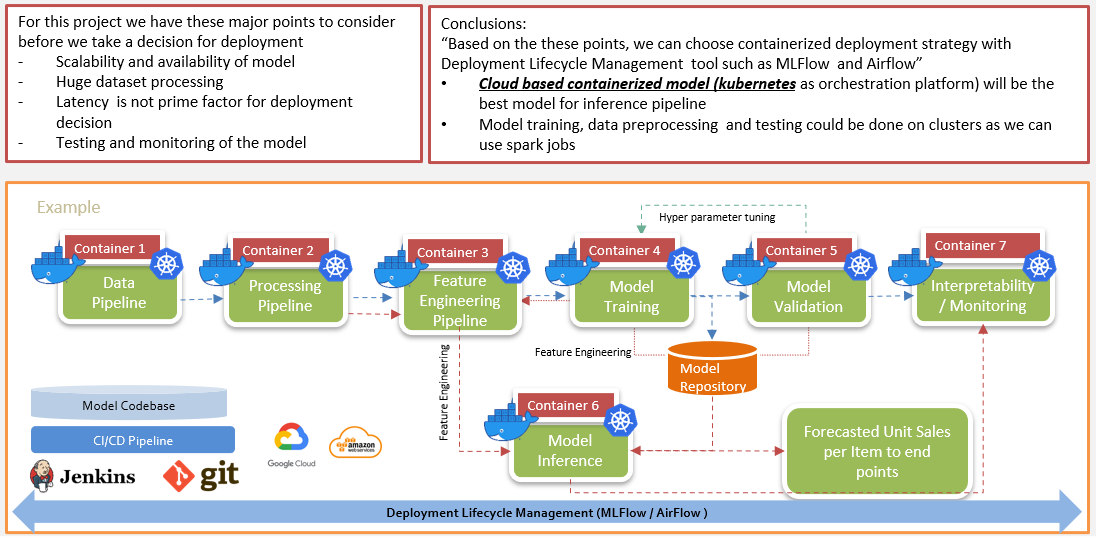

## Approach 3 - Deployment in Google Cloud using Kubeflow

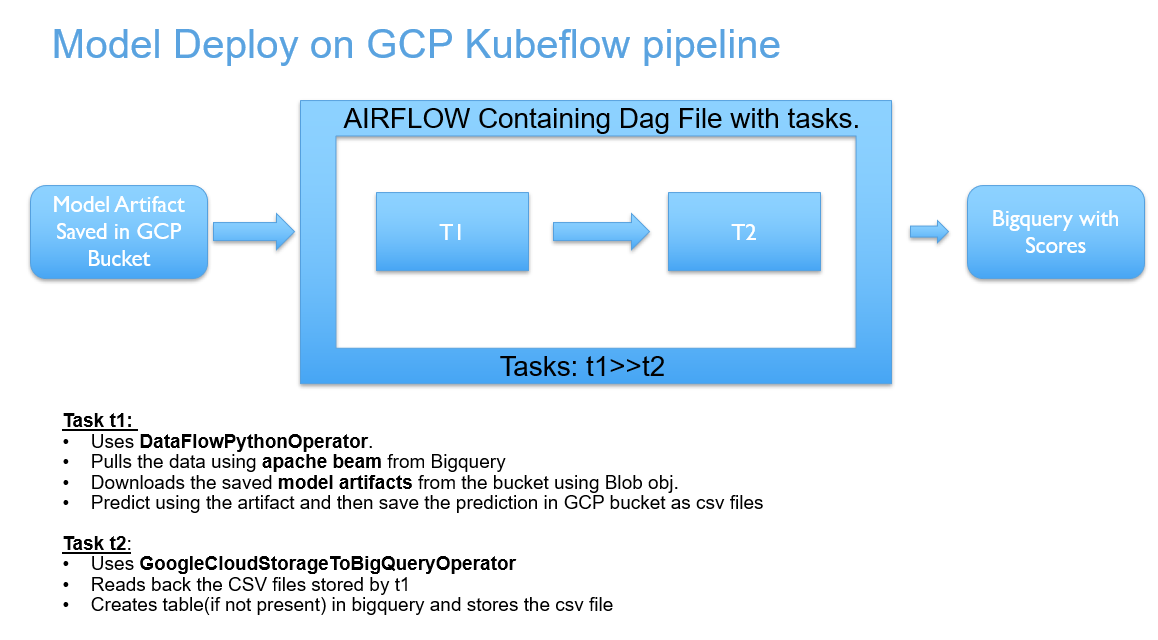